InceptionResNetV2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldInceptionResnetV2.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 29s 274ms/step
Epoch 1 - Validation Loss: 0.7827, Validation Accuracy: 0.7282, Validation Precision: 0.6770

Epoch 1: val_loss improved from inf to 0.78274, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 0.9442 - acc: 0.6698 - val_loss: 0.7827 - val_acc: 0.7282 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 274ms/step
Epoch 2 - Validation Loss: 0.7212, Validation Accuracy: 0.7469, Validation Precision: 0.7337

Epoch 2: val_loss improved from 0.78274 to 0.72116, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.7937 - acc: 0.7042 - val_loss: 0.7212 - val_acc: 0.7469 - lr: 1.0000e-04 - 400s/epoch - 997ms/step
Epoch 3/1000
101/101 [==============================] - 27s 273ms/step
Epoch 3 - Validation Loss: 0.5861, Validation Accuracy: 0.7993, Validation Precision: 0.7679

Epoch 3: val_loss improved from 0.72116 to 0.58613, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.6811 - acc: 0.7521 - val_loss: 0.5861 - val_acc: 0.7993 - lr: 1.0000e-04 - 400s/epoch - 997ms/step
Epoch 4/1000
101/101 [==============================] - 28s 274ms/step
Epoch 4 - Validation Loss: 0.7517, Validation Accuracy: 0.7394, Validation Precision: 0.8310

Epoch 4: val_loss did not improve from 0.58613
401/401 - 398s - loss: 0.6020 - acc: 0.7937 - val_loss: 0.7517 - val_acc: 0.7394 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.5240, Validation Accuracy: 0.8292, Validation Precision: 0.8213

Epoch 5: val_loss improved from 0.58613 to 0.52396, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.5287 - acc: 0.8271 - val_loss: 0.5240 - val_acc: 0.8292 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 6/1000
101/101 [==============================] - 27s 273ms/step
Epoch 6 - Validation Loss: 0.9147, Validation Accuracy: 0.7506, Validation Precision: 0.8283

Epoch 6: val_loss did not improve from 0.52396
401/401 - 398s - loss: 0.4738 - acc: 0.8427 - val_loss: 0.9147 - val_acc: 0.7506 - lr: 1.0000e-04 - 398s/epoch - 994ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 7 - Validation Loss: 0.5201, Validation Accuracy: 0.8460, Validation Precision: 0.8489

Epoch 7: val_loss improved from 0.52396 to 0.52010, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.4178 - acc: 0.8592 - val_loss: 0.5201 - val_acc: 0.8460 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 8/1000
101/101 [==============================] - 28s 274ms/step
Epoch 8 - Validation Loss: 0.6646, Validation Accuracy: 0.8136, Validation Precision: 0.8447

Epoch 8: val_loss did not improve from 0.52010
401/401 - 399s - loss: 0.3776 - acc: 0.8773 - val_loss: 0.6646 - val_acc: 0.8136 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 9 - Validation Loss: 0.6452, Validation Accuracy: 0.8279, Validation Precision: 0.8379

Epoch 9: val_loss did not improve from 0.52010
401/401 - 398s - loss: 0.3563 - acc: 0.8857 - val_loss: 0.6452 - val_acc: 0.8279 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 10 - Validation Loss: 0.7453, Validation Accuracy: 0.8335, Validation Precision: 0.8349

Epoch 10: val_loss did not improve from 0.52010
401/401 - 398s - loss: 0.3079 - acc: 0.9008 - val_loss: 0.7453 - val_acc: 0.8335 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 11 - Validation Loss: 0.6575, Validation Accuracy: 0.8498, Validation Precision: 0.8593

Epoch 11: val_loss did not improve from 0.52010
401/401 - 399s - loss: 0.2789 - acc: 0.9094 - val_loss: 0.6575 - val_acc: 0.8498 - lr: 1.0000e-04 - 399s/epoch - 995ms/step
Epoch 12/1000
101/101 [==============================] - 27s 273ms/step
Epoch 12 - Validation Loss: 0.5984, Validation Accuracy: 0.8429, Validation Precision: 0.8489

Epoch 12: val_loss did not improve from 0.52010
401/401 - 399s - loss: 0.2431 - acc: 0.9238 - val_loss: 0.5984 - val_acc: 0.8429 - lr: 1.0000e-04 - 399s/epoch - 995ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 29s 274ms/step
Epoch 1 - Validation Loss: 0.8285, Validation Accuracy: 0.7020, Validation Precision: 0.5958

Epoch 1: val_loss improved from inf to 0.82849, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 414s - loss: 1.0576 - acc: 0.6302 - val_loss: 0.8285 - val_acc: 0.7020 - lr: 1.0000e-04 - 414s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 274ms/step
Epoch 2 - Validation Loss: 0.7498, Validation Accuracy: 0.6958, Validation Precision: 0.7787

Epoch 2: val_loss improved from 0.82849 to 0.74978, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.7864 - acc: 0.7233 - val_loss: 0.7498 - val_acc: 0.6958 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 3/1000
101/101 [==============================] - 28s 274ms/step
Epoch 3 - Validation Loss: 0.6012, Validation Accuracy: 0.8136, Validation Precision: 0.8031

Epoch 3: val_loss improved from 0.74978 to 0.60123, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.6655 - acc: 0.7694 - val_loss: 0.6012 - val_acc: 0.8136 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 4/1000
101/101 [==============================] - 27s 273ms/step
Epoch 4 - Validation Loss: 0.8108, Validation Accuracy: 0.7400, Validation Precision: 0.8187

Epoch 4: val_loss did not improve from 0.60123
401/401 - 398s - loss: 0.5767 - acc: 0.8078 - val_loss: 0.8108 - val_acc: 0.7400 - lr: 1.0000e-04 - 398s/epoch - 992ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 5 - Validation Loss: 0.6797, Validation Accuracy: 0.8086, Validation Precision: 0.8198

Epoch 5: val_loss did not improve from 0.60123
401/401 - 398s - loss: 0.5041 - acc: 0.8291 - val_loss: 0.6797 - val_acc: 0.8086 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 6 - Validation Loss: 0.6463, Validation Accuracy: 0.8074, Validation Precision: 0.8324

Epoch 6: val_loss did not improve from 0.60123
401/401 - 399s - loss: 0.4696 - acc: 0.8436 - val_loss: 0.6463 - val_acc: 0.8074 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 7 - Validation Loss: 0.4976, Validation Accuracy: 0.8267, Validation Precision: 0.8388

Epoch 7: val_loss improved from 0.60123 to 0.49762, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.4148 - acc: 0.8580 - val_loss: 0.4976 - val_acc: 0.8267 - lr: 1.0000e-04 - 400s/epoch - 997ms/step
Epoch 8/1000
101/101 [==============================] - 27s 273ms/step
Epoch 8 - Validation Loss: 0.7903, Validation Accuracy: 0.7830, Validation Precision: 0.8257

Epoch 8: val_loss did not improve from 0.49762
401/401 - 398s - loss: 0.3910 - acc: 0.8714 - val_loss: 0.7903 - val_acc: 0.7830 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 9 - Validation Loss: 0.5608, Validation Accuracy: 0.8155, Validation Precision: 0.8591

Epoch 9: val_loss did not improve from 0.49762
401/401 - 398s - loss: 0.3252 - acc: 0.8955 - val_loss: 0.5608 - val_acc: 0.8155 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 10/1000
101/101 [==============================] - 28s 273ms/step
Epoch 10 - Validation Loss: 0.6262, Validation Accuracy: 0.7874, Validation Precision: 0.8514

Epoch 10: val_loss did not improve from 0.49762
401/401 - 398s - loss: 0.3056 - acc: 0.8982 - val_loss: 0.6262 - val_acc: 0.7874 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 11/1000
101/101 [==============================] - 27s 273ms/step
Epoch 11 - Validation Loss: 0.7589, Validation Accuracy: 0.8298, Validation Precision: 0.8474

Epoch 11: val_loss did not improve from 0.49762
401/401 - 398s - loss: 0.2620 - acc: 0.9157 - val_loss: 0.7589 - val_acc: 0.8298 - lr: 1.0000e-04 - 398s/epoch - 992ms/step

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.9368 - acc: 0.6768 - val_loss: 0.7550 - val_acc: 0.7363 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 274ms/step
Epoch 2 - Validation Loss: 0.8117, Validation Accuracy: 0.7126, Validation Precision: 0.7593

Epoch 2: val_loss did not improve from 0.75503
401/401 - 399s - loss: 0.7319 - acc: 0.7336 - val_loss: 0.8117 - val_acc: 0.7126 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 3 - Validation Loss: 0.5510, Validation Accuracy: 0.8142, Validation Precision: 0.8274

Epoch 3: val_loss improved from 0.75503 to 0.55104, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.6273 - acc: 0.7777 - val_loss: 0.5510 - val_acc: 0.8142 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 4/1000
101/101 [==============================] - 28s 274ms/step
Epoch 4 - Validation Loss: 0.6240, Validation Accuracy: 0.7880, Validation Precision: 0.8250

Epoch 4: val_loss did not improve from 0.55104
401/401 - 399s - loss: 0.5499 - acc: 0.8085 - val_loss: 0.6240 - val_acc: 0.7880 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.5763, Validation Accuracy: 0.7731, Validation Precision: 0.8286

Epoch 5: val_loss did not improve from 0.55104
401/401 - 398s - loss: 0.4878 - acc: 0.8305 - val_loss: 0.5763 - val_acc: 0.7731 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 6 - Validation Loss: 0.5525, Validation Accuracy: 0.8454, Validation Precision: 0.8554

Epoch 6: val_loss did not improve from 0.55104
401/401 - 398s - loss: 0.4324 - acc: 0.8545 - val_loss: 0.5525 - val_acc: 0.8454 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 7/1000
101/101 [==============================] - 28s 274ms/step
Epoch 7 - Validation Loss: 0.4470, Validation Accuracy: 0.8392, Validation Precision: 0.8588

Epoch 7: val_loss improved from 0.55104 to 0.44703, saving model to 5foldInceptionResnetV2.h5
401/401 - 400s - loss: 0.3770 - acc: 0.8690 - val_loss: 0.4470 - val_acc: 0.8392 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 8/1000
101/101 [==============================] - 27s 273ms/step
Epoch 8 - Validation Loss: 0.5440, Validation Accuracy: 0.8373, Validation Precision: 0.8617

Epoch 8: val_loss did not improve from 0.44703
401/401 - 399s - loss: 0.3494 - acc: 0.8835 - val_loss: 0.5440 - val_acc: 0.8373 -

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 419s - loss: 1.0969 - acc: 0.6075 - val_loss: 0.8056 - val_acc: 0.6893 - lr: 1.0000e-04 - 419s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 274ms/step
Epoch 2 - Validation Loss: 0.6890, Validation Accuracy: 0.7636, Validation Precision: 0.7351

Epoch 2: val_loss improved from 0.80561 to 0.68896, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.7983 - acc: 0.7217 - val_loss: 0.6890 - val_acc: 0.7636 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 3/1000
101/101 [==============================] - 28s 273ms/step
Epoch 3 - Validation Loss: 0.9576, Validation Accuracy: 0.7205, Validation Precision: 0.7404

Epoch 3: val_loss did not improve from 0.68896
401/401 - 399s - loss: 0.6862 - acc: 0.7626 - val_loss: 0.9576 - val_acc: 0.7205 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 4 - Validation Loss: 0.7356, Validation Accuracy: 0.7817, Validation Precision: 0.7553

Epoch 4: val_loss did not improve from 0.68896
401/401 - 398s - loss: 0.6072 - acc: 0.7995 - val_loss: 0.7356 - val_acc: 0.7817 - lr: 1.0000e-04 - 398s/epoch - 993ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 273ms/step
Epoch 5 - Validation Loss: 0.7996, Validation Accuracy: 0.8054, Validation Precision: 0.8086

Epoch 5: val_loss did not improve from 0.68896
401/401 - 399s - loss: 0.5203 - acc: 0.8229 - val_loss: 0.7996 - val_acc: 0.8054 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 6 - Validation Loss: 0.8154, Validation Accuracy: 0.7779, Validation Precision: 0.8199

Epoch 6: val_loss did not improve from 0.68896
401/401 - 399s - loss: 0.4985 - acc: 0.8362 - val_loss: 0.8154 - val_acc: 0.7779 - lr: 1.0000e-04 - 399s/epoch - 995ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 7 - Validation Loss: 0.5125, Validation Accuracy: 0.8284, Validation Precision: 0.8331

Epoch 7: val_loss improved from 0.68896 to 0.51252, saving model to 5foldInceptionResnetV2.h5
401/401 - 400s - loss: 0.4304 - acc: 0.8566 - val_loss: 0.5125 - val_acc: 0.8284 - lr: 1.0000e-04 - 400s/epoch - 996ms/step
Epoch 8/1000
101/101 [==============================] - 28s 274ms/step
Epoch 8 - Validation Loss: 0.5490, Validation Accuracy: 0.8309, Validation Precision: 0.8356

Epoch 8: val_loss did not improve from 0.51252
401/401 - 399s - loss: 0.3763 - acc: 0.8748 - val_loss: 0.5490 - val_acc: 0.8309 - lr: 1.0000e-04 - 399s/epoch - 995ms/step
Epoch 9/1000
101/101 [==============================] - 28s 273ms/step
Epoch 9 - Validation Loss: 0.7986, Validation Accuracy: 0.7586, Validation Precision: 0.8249

Epoch 9: val_loss did not improve from 0.51252
401/401 - 399s - loss: 0.3534 - acc: 0.8837 - val_loss: 0.7986 - val_acc: 0.7586 -

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 415s - loss: 0.9385 - acc: 0.6689 - val_loss: 0.9177 - val_acc: 0.6925 - lr: 1.0000e-04 - 415s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 28s 274ms/step
Epoch 2 - Validation Loss: 1.1354, Validation Accuracy: 0.5939, Validation Precision: 0.7350

Epoch 2: val_loss did not improve from 0.91771
401/401 - 399s - loss: 0.7600 - acc: 0.7141 - val_loss: 1.1354 - val_acc: 0.5939 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 3 - Validation Loss: 2.0646, Validation Accuracy: 0.3200, Validation Precision: 0.7455

Epoch 3: val_loss did not improve from 0.91771
401/401 - 399s - loss: 0.6630 - acc: 0.7606 - val_loss: 2.0646 - val_acc: 0.3200 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 4 - Validation Loss: 1.0457, Validation Accuracy: 0.5970, Validation Precision: 0.7622

Epoch 4: val_loss did not improve from 0.91771
401/401 - 399s - loss: 0.5822 - acc: 0.8020 - val_loss: 1.0457 - val_acc: 0.5970 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 273ms/step
Epoch 5 - Validation Loss: 1.0988, Validation Accuracy: 0.5178, Validation Precision: 0.6986

Epoch 5: val_loss did not improve from 0.91771
401/401 - 398s - loss: 0.5037 - acc: 0.8253 - val_loss: 1.0988 - val_acc: 0.5178 - lr: 1.0000e-04 - 398s/epoch - 994ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 28s 274ms/step
Epoch 6 - Validation Loss: 0.7416, Validation Accuracy: 0.7043, Validation Precision: 0.8061

Epoch 6: val_loss improved from 0.91771 to 0.74158, saving model to 5foldInceptionResnetV2.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 400s - loss: 0.4680 - acc: 0.8379 - val_loss: 0.7416 - val_acc: 0.7043 - lr: 1.0000e-04 - 400s/epoch - 998ms/step
Epoch 7/1000
101/101 [==============================] - 28s 274ms/step
Epoch 7 - Validation Loss: 0.9625, Validation Accuracy: 0.6613, Validation Precision: 0.7959

Epoch 7: val_loss did not improve from 0.74158
401/401 - 399s - loss: 0.4152 - acc: 0.8583 - val_loss: 0.9625 - val_acc: 0.6613 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 8/1000
101/101 [==============================] - 28s 274ms/step
Epoch 8 - Validation Loss: 1.6229, Validation Accuracy: 0.4616, Validation Precision: 0.8036

Epoch 8: val_loss did not improve from 0.74158
401/401 - 399s - loss: 0.3849 - acc: 0.8745 - val_loss: 1.6229 - val_acc: 0.4616 - lr: 1.0000e-04 - 399s/epoch - 994ms/step
Epoch 9/1000
101/101 [==============================] - 28s 274ms/step
Epoch 9 - Validation Loss: 2.3446, Validation Accuracy: 0.3930, Validation Precision: 0.8120

Epoch 9: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1015 (Conv2D)           (None, 299, 224, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1015 (Batc  (None, 299, 224, 32  96         ['conv2d_1015[0][0]']            
 hNormalization)                )                                                           

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 277ms/step - loss: 0.7125 - acc: 0.7677
Test accuracy: 0.7676567435264587
95/95 [==============================] - 26s 272ms/step
Test Precision: 0.7598
Test Recall: 0.7677
Test F1-Score: 0.7613



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 227s 452ms/step


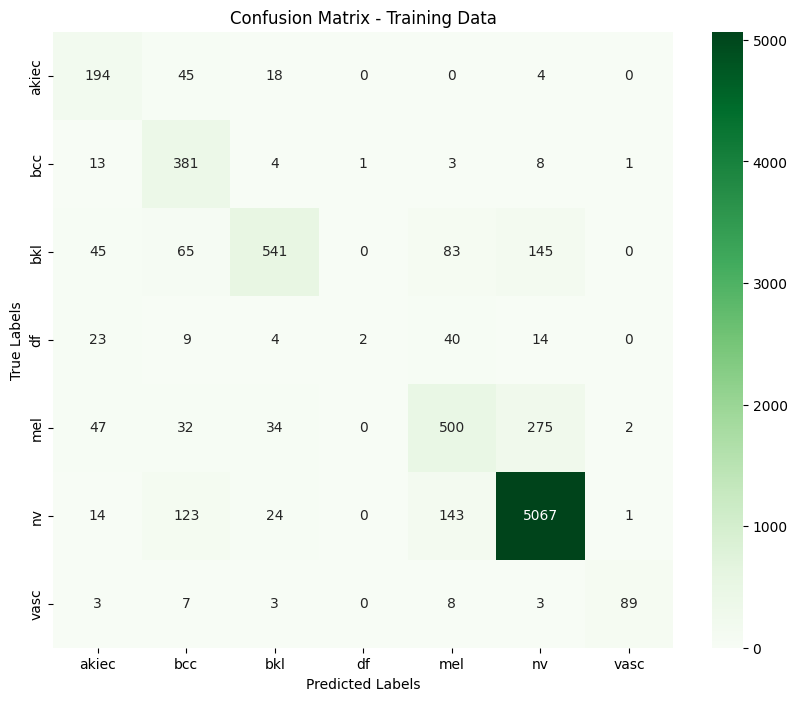

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.57      0.74      0.65       261
         bcc       0.58      0.93      0.71       411
         bkl       0.86      0.62      0.72       879
          df       0.67      0.02      0.04        92
         mel       0.64      0.56      0.60       890
          nv       0.92      0.94      0.93      5372
        vasc       0.96      0.79      0.86       113

    accuracy                           0.84      8018
   macro avg       0.74      0.66      0.64      8018
weighted avg       0.85      0.84      0.84      8018

126/126 [==============================] - 34s 272ms/step


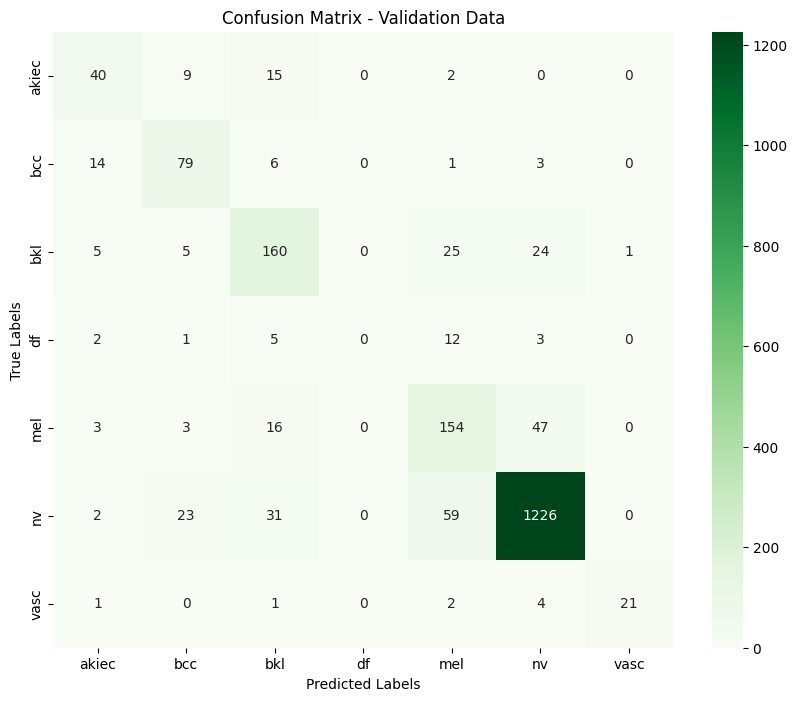

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.60      0.61      0.60        66
         bcc       0.66      0.77      0.71       103
         bkl       0.68      0.73      0.70       220
          df       0.00      0.00      0.00        23
         mel       0.60      0.69      0.64       223
          nv       0.94      0.91      0.93      1341
        vasc       0.95      0.72      0.82        29

    accuracy                           0.84      2005
   macro avg       0.63      0.63      0.63      2005
weighted avg       0.84      0.84      0.84      2005

95/95 [==============================] - 26s 272ms/step


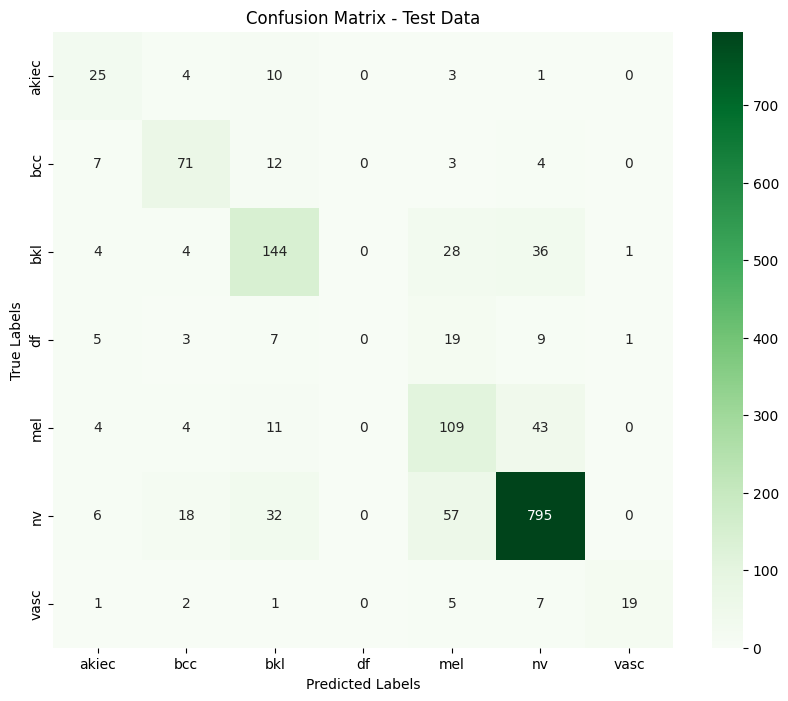

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.48      0.58      0.53        43
         bcc       0.67      0.73      0.70        97
         bkl       0.66      0.66      0.66       217
          df       0.00      0.00      0.00        44
         mel       0.49      0.64      0.55       171
          nv       0.89      0.88      0.88       908
        vasc       0.90      0.54      0.68        35

    accuracy                           0.77      1515
   macro avg       0.58      0.58      0.57      1515
weighted avg       0.76      0.77      0.76      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldInceptionResnetV2.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

InceptionV3

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldInceptionV3.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 12s 112ms/step
Epoch 1 - Validation Loss: 0.9410, Validation Accuracy: 0.6771, Validation Precision: 0.6560

Epoch 1: val_loss improved from inf to 0.94103, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 221s - loss: 1.0614 - acc: 0.6427 - val_loss: 0.9410 - val_acc: 0.6771 - lr: 1.0000e-04 - 221s/epoch - 551ms/step
Epoch 2/1000
101/101 [==============================] - 11s 112ms/step
Epoch 2 - Validation Loss: 0.7472, Validation Accuracy: 0.7438, Validation Precision: 0.7192

Epoch 2: val_loss improved from 0.94103 to 0.74724, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 212s - loss: 0.8368 - acc: 0.6993 - val_loss: 0.7472 - val_acc: 0.7438 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 3/1000
101/101 [==============================] - 11s 111ms/step
Epoch 3 - Validation Loss: 0.9345, Validation Accuracy: 0.7431, Validation Precision: 0.8076

Epoch 3: val_loss did not improve from 0.74724
401/401 - 211s - loss: 0.7194 - acc: 0.7569 - val_loss: 0.9345 - val_acc: 0.7431 - lr: 1.0000e-04 - 211s/epoch - 527ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 4 - Validation Loss: 0.5952, Validation Accuracy: 0.7986, Validation Precision: 0.8018

Epoch 4: val_loss improved from 0.74724 to 0.59519, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 212s - loss: 0.6505 - acc: 0.7794 - val_loss: 0.5952 - val_acc: 0.7986 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 5/1000
101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 0.5267, Validation Accuracy: 0.8248, Validation Precision: 0.8115

Epoch 5: val_loss improved from 0.59519 to 0.52667, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 211s - loss: 0.5809 - acc: 0.8046 - val_loss: 0.5267 - val_acc: 0.8248 - lr: 1.0000e-04 - 211s/epoch - 527ms/step
Epoch 6/1000
101/101 [==============================] - 11s 112ms/step
Epoch 6 - Validation Loss: 0.6277, Validation Accuracy: 0.8161, Validation Precision: 0.8031

Epoch 6: val_loss did not improve from 0.52667
401/401 - 209s - loss: 0.5306 - acc: 0.8227 - val_loss: 0.6277 - val_acc: 0.8161 - lr: 1.0000e-04 - 209s/epoch - 522ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 7 - Validation Loss: 1.5059, Validation Accuracy: 0.6534, Validation Precision: 0.8133

Epoch 7: val_loss did not improve from 0.52667
401/401 - 210s - loss: 0.4685 - acc: 0.8427 - val_loss: 1.5059 - val_acc: 0.6534 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 8 - Validation Loss: 0.6829, Validation Accuracy: 0.7849, Validation Precision: 0.8380

Epoch 8: val_loss did not improve from 0.52667
401/401 - 209s - loss: 0.4354 - acc: 0.8581 - val_loss: 0.6829 - val_acc: 0.7849 - lr: 1.0000e-04 - 209s/epoch - 522ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 9 - Validation Loss: 0.5648, Validation Accuracy: 0.8329, Validation Precision: 0.8267

Epoch 9: val_loss did not improve from 0.52667
401/401 - 210s - loss: 0.4155 - acc: 0.8622 - val_loss: 0.5648 - val_acc: 0.8329 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 10 - Validation Loss: 0.7949, Validation Accuracy: 0.7868, Validation Precision: 0.8115

Epoch 10: val_loss did not improve from 0.52667
401/401 - 210s - loss: 0.3888 - acc: 0.8709 - val_loss: 0.7949 - val_acc: 0.7868 - lr: 1.0000e-04 - 210s/epoch - 523ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 112ms/step
Epoch 1 - Validation Loss: 0.9503, Validation Accuracy: 0.6820, Validation Precision: 0.7194

Epoch 1: val_loss improved from inf to 0.95030, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 217s - loss: 1.0226 - acc: 0.6464 - val_loss: 0.9503 - val_acc: 0.6820 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 2/1000
101/101 [==============================] - 11s 112ms/step
Epoch 2 - Validation Loss: 0.7821, Validation Accuracy: 0.7531, Validation Precision: 0.7605

Epoch 2: val_loss improved from 0.95030 to 0.78211, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 210s - loss: 0.7863 - acc: 0.7222 - val_loss: 0.7821 - val_acc: 0.7531 - lr: 1.0000e-04 - 210s/epoch - 525ms/step
Epoch 3/1000
101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 1.4415, Validation Accuracy: 0.6559, Validation Precision: 0.7999

Epoch 3: val_loss did not improve from 0.78211
401/401 - 209s - loss: 0.6944 - acc: 0.7624 - val_loss: 1.4415 - val_acc: 0.6559 - lr: 1.0000e-04 - 209s/epoch - 522ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 0.6437, Validation Accuracy: 0.8067, Validation Precision: 0.7927

Epoch 4: val_loss improved from 0.78211 to 0.64372, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 209s - loss: 0.6242 - acc: 0.7894 - val_loss: 0.6437 - val_acc: 0.8067 - lr: 1.0000e-04 - 209s/epoch - 522ms/step
Epoch 5/1000
101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 0.8759, Validation Accuracy: 0.7562, Validation Precision: 0.8287

Epoch 5: val_loss did not improve from 0.64372
401/401 - 210s - loss: 0.5584 - acc: 0.8060 - val_loss: 0.8759 - val_acc: 0.7562 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 6 - Validation Loss: 0.7288, Validation Accuracy: 0.8017, Validation Precision: 0.8334

Epoch 6: val_loss did not improve from 0.64372
401/401 - 211s - loss: 0.5114 - acc: 0.8283 - val_loss: 0.7288 - val_acc: 0.8017 - lr: 1.0000e-04 - 211s/epoch - 525ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 7 - Validation Loss: 0.7273, Validation Accuracy: 0.7830, Validation Precision: 0.8186

Epoch 7: val_loss did not improve from 0.64372
401/401 - 209s - loss: 0.4643 - acc: 0.8452 - val_loss: 0.7273 - val_acc: 0.7830 - lr: 1.0000e-04 - 209s/epoch - 521ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 8 - Validation Loss: 0.4367, Validation Accuracy: 0.8498, Validation Precision: 0.8422

Epoch 8: val_loss improved from 0.64372 to 0.43668, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 210s - loss: 0.4340 - acc: 0.8559 - val_loss: 0.4367 - val_acc: 0.8498 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Epoch 9/1000
101/101 [==============================] - 11s 112ms/step
Epoch 9 - Validation Loss: 0.5442, Validation Accuracy: 0.8348, Validation Precision: 0.8215

Epoch 9: val_loss did not improve from 0.43668
401/401 - 210s - loss: 0.4088 - acc: 0.8662 - val_loss: 0.5442 - val_acc: 0.8348 - lr: 1.0000e-04 - 210s/epoch - 523ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 10 - Validation Loss: 0.7584, Validation Accuracy: 0.8105, Validation Precision: 0.8284

Epoch 10: val_loss did not improve from 0.43668
401/401 - 209s - loss: 0.3904 - acc: 0.8728 - val_loss: 0.7584 - val_acc: 0.8105 - lr: 1.0000e-04 - 209s/epoch - 522ms/step
Epoch 11/1000
101/101 [==============================] - 11s 111ms/step
Epoch 11 - Validation Loss: 0.5613, Validation Accuracy: 0.8223, Validation Precision: 0.8358

Epoch 11: val_loss did not improve from 0.43668
401/401 - 209s - loss: 0.3452 - acc: 0.8843 - val_loss: 0.5613 - val_acc: 0.8223 - lr: 1.0000e-04 - 209s/epoch - 521ms/step
Epoch 12/1000
101/101 [==============================] - 11s 112ms/step
Epoch 12 - Validation Loss: 0.6915, Validation Accuracy: 0.8123, Validation Precision: 0.8536

Epoch 12: val_loss did not improve from 0.43668
401/401 - 209s - loss: 0.3323 - acc: 0.8907 - val_loss: 0.6915 - val_acc: 0.8123 - lr: 1.0000e-04 - 209s/epoch - 522ms/st

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 112ms/step
Epoch 1 - Validation Loss: 0.7649, Validation Accuracy: 0.7195, Validation Precision: 0.6240

Epoch 1: val_loss improved from inf to 0.76488, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 219s - loss: 1.0352 - acc: 0.6688 - val_loss: 0.7649 - val_acc: 0.7195 - lr: 1.0000e-04 - 219s/epoch - 545ms/step
Epoch 2/1000
101/101 [==============================] - 11s 112ms/step
Epoch 2 - Validation Loss: 0.7125, Validation Accuracy: 0.7419, Validation Precision: 0.7089

Epoch 2: val_loss improved from 0.76488 to 0.71248, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 214s - loss: 0.8200 - acc: 0.7133 - val_loss: 0.7125 - val_acc: 0.7419 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 3/1000
101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 0.9073, Validation Accuracy: 0.6665, Validation Precision: 0.7411

Epoch 3: val_loss did not improve from 0.71248
401/401 - 212s - loss: 0.7199 - acc: 0.7540 - val_loss: 0.9073 - val_acc: 0.6665 - lr: 1.0000e-04 - 212s/epoch - 529ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 1.2868, Validation Accuracy: 0.6970, Validation Precision: 0.8183

Epoch 4: val_loss did not improve from 0.71248
401/401 - 212s - loss: 0.6414 - acc: 0.7794 - val_loss: 1.2868 - val_acc: 0.6970 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 0.5557, Validation Accuracy: 0.8092, Validation Precision: 0.8024

Epoch 5: val_loss improved from 0.71248 to 0.55566, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 212s - loss: 0.5600 - acc: 0.8149 - val_loss: 0.5557 - val_acc: 0.8092 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 6/1000
101/101 [==============================] - 11s 112ms/step
Epoch 6 - Validation Loss: 0.5695, Validation Accuracy: 0.8198, Validation Precision: 0.8007

Epoch 6: val_loss did not improve from 0.55566
401/401 - 211s - loss: 0.5111 - acc: 0.8262 - val_loss: 0.5695 - val_acc: 0.8198 - lr: 1.0000e-04 - 211s/epoch - 526ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 7 - Validation Loss: 0.6522, Validation Accuracy: 0.8061, Validation Precision: 0.8259

Epoch 7: val_loss did not improve from 0.55566
401/401 - 211s - loss: 0.4556 - acc: 0.8447 - val_loss: 0.6522 - val_acc: 0.8061 - lr: 1.0000e-04 - 211s/epoch - 527ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 8 - Validation Loss: 0.7537, Validation Accuracy: 0.7968, Validation Precision: 0.8378

Epoch 8: val_loss did not improve from 0.55566
401/401 - 212s - loss: 0.4331 - acc: 0.8573 - val_loss: 0.7537 - val_acc: 0.7968 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 116ms/step
Epoch 9 - Validation Loss: 1.2556, Validation Accuracy: 0.6908, Validation Precision: 0.8185

Epoch 9: val_loss did not improve from 0.55566
401/401 - 214s - loss: 0.3831 - acc: 0.8700 - val_loss: 1.2556 - val_acc: 0.6908 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 10 - Validation Loss: 0.5492, Validation Accuracy: 0.8429, Validation Precision: 0.8415

Epoch 10: val_loss improved from 0.55566 to 0.54918, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 259s - loss: 0.3488 - acc: 0.8820 - val_loss: 0.5492 - val_acc: 0.8429 - lr: 1.0000e-04 - 259s/epoch - 645ms/step
Epoch 11/1000
101/101 [==============================] - 11s 113ms/step
Epoch 11 - Validation Loss: 0.6432, Validation Accuracy: 0.8229, Validation Precision: 0.8346

Epoch 11: val_loss did not improve from 0.54918
401/401 - 214s - loss: 0.3377 - acc: 0.8907 - val_loss: 0.6432 - val_acc: 0.8229 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 12/1000
101/101 [==============================] - 11s 112ms/step
Epoch 12 - Validation Loss: 0.6958, Validation Accuracy: 0.8180, Validation Precision: 0.8605

Epoch 12: val_loss did not improve from 0.54918
401/401 - 213s - loss: 0.2901 - acc: 0.9004 - val_loss: 0.6958 - val_acc: 0.8180 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Epoch 13/1000
101/101 [==============================] - 11s 112ms/step
Epoch 13 - Validation Loss: 0.6318, Validation Accuracy: 0.8304, Validation Precision: 0.8477

Epoch 13: val_loss did not impr

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 12s 112ms/step
Epoch 1 - Validation Loss: 0.8144, Validation Accuracy: 0.7018, Validation Precision: 0.7325

Epoch 1: val_loss improved from inf to 0.81435, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 0.9697 - acc: 0.6652 - val_loss: 0.8144 - val_acc: 0.7018 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 2/1000
101/101 [==============================] - 11s 112ms/step
Epoch 2 - Validation Loss: 0.9347, Validation Accuracy: 0.7006, Validation Precision: 0.7667

Epoch 2: val_loss did not improve from 0.81435
401/401 - 213s - loss: 0.7923 - acc: 0.7102 - val_loss: 0.9347 - val_acc: 0.7006 - lr: 1.0000e-04 - 213s/epoch - 530ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 0.6922, Validation Accuracy: 0.7598, Validation Precision: 0.7832

Epoch 3: val_loss improved from 0.81435 to 0.69224, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 214s - loss: 0.6994 - acc: 0.7567 - val_loss: 0.6922 - val_acc: 0.7598 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 4/1000
101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 1.0018, Validation Accuracy: 0.6432, Validation Precision: 0.8018

Epoch 4: val_loss did not improve from 0.69224
401/401 - 212s - loss: 0.6136 - acc: 0.7900 - val_loss: 1.0018 - val_acc: 0.6432 - lr: 1.0000e-04 - 212s/epoch - 529ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 1.0876, Validation Accuracy: 0.5914, Validation Precision: 0.7787

Epoch 5: val_loss did not improve from 0.69224
401/401 - 213s - loss: 0.5764 - acc: 0.8037 - val_loss: 1.0876 - val_acc: 0.5914 - lr: 1.0000e-04 - 213s/epoch - 532ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 6 - Validation Loss: 0.7332, Validation Accuracy: 0.7667, Validation Precision: 0.7722

Epoch 6: val_loss did not improve from 0.69224
401/401 - 213s - loss: 0.5052 - acc: 0.8288 - val_loss: 0.7332 - val_acc: 0.7667 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 7 - Validation Loss: 0.7306, Validation Accuracy: 0.7767, Validation Precision: 0.8072

Epoch 7: val_loss did not improve from 0.69224
401/401 - 212s - loss: 0.4660 - acc: 0.8369 - val_loss: 0.7306 - val_acc: 0.7767 - lr: 1.0000e-04 - 212s/epoch - 529ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 8 - Validation Loss: 0.7237, Validation Accuracy: 0.7754, Validation Precision: 0.7832

Epoch 8: val_loss did not improve from 0.69224
401/401 - 213s - loss: 0.4465 - acc: 0.8432 - val_loss: 0.7237 - val_acc: 0.7754 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1603 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 12s 111ms/step
Epoch 1 - Validation Loss: 0.8965, Validation Accuracy: 0.6725, Validation Precision: 0.6860

Epoch 1: val_loss improved from inf to 0.89650, saving model to 5foldInceptionV3.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 218s - loss: 1.0031 - acc: 0.6379 - val_loss: 0.8965 - val_acc: 0.6725 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 2/1000
101/101 [==============================] - 11s 111ms/step
Epoch 2 - Validation Loss: 1.0948, Validation Accuracy: 0.5315, Validation Precision: 0.7401

Epoch 2: val_loss did not improve from 0.89650
401/401 - 212s - loss: 0.7409 - acc: 0.7331 - val_loss: 1.0948 - val_acc: 0.5315 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 0.9063, Validation Accuracy: 0.6145, Validation Precision: 0.7562

Epoch 3: val_loss did not improve from 0.89650
401/401 - 211s - loss: 0.6389 - acc: 0.7786 - val_loss: 0.9063 - val_acc: 0.6145 - lr: 1.0000e-04 - 211s/epoch - 526ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 1.1825, Validation Accuracy: 0.4991, Validation Precision: 0.7665

Epoch 4: val_loss did not improve from 0.89650
401/401 - 212s - loss: 0.5759 - acc: 0.8048 - val_loss: 1.1825 - val_acc: 0.4991 - lr: 1.0000e-04 - 212s/epoch - 527ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 1.6643, Validation Accuracy: 0.4566, Validation Precision: 0.7717

Epoch 5: val_loss did not improve from 0.89650
401/401 - 212s - loss: 0.5103 - acc: 0.8263 - val_loss: 1.6643 - val_acc: 0.4566 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 6 - Validation Loss: 1.0905, Validation Accuracy: 0.5271, Validation Precision: 0.6860

Epoch 6: val_loss did not improve from 0.89650
401/401 - 212s - loss: 0.4804 - acc: 0.8441 - val_loss: 1.0905 - val_acc: 0.5271 - lr: 1.0000e-04 - 212s/epoch - 528ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1594 (Conv2D)           (None, 299, 224, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_1594 (Batc  (None, 299, 224, 32  96         ['conv2d_1594[0][0]']            
 hNormalization)                )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 25s 196ms/step - loss: 0.7515 - acc: 0.7212
Validation accuracy: 0.7211970090866089
126/126 [==============================] - 14s 111ms/step
Validation Precision: 0.6187
Validation Recall: 0.7212
Validation F1-Score: 0.6635



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 19s 198ms/step - loss: 0.8892 - acc: 0.6594
Test accuracy: 0.6594059467315674
95/95 [==============================] - 11s 112ms/step
Test Precision: 0.5412
Test Recall: 0.6594
Test F1-Score: 0.5914



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 225s 448ms/step


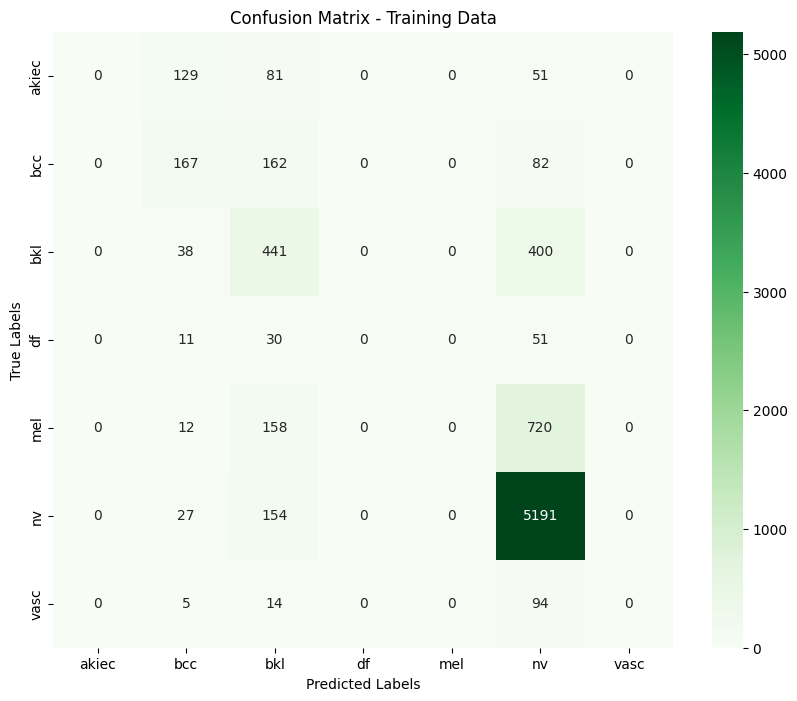

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.43      0.41      0.42       411
         bkl       0.42      0.50      0.46       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.79      0.97      0.87      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.72      8018
   macro avg       0.23      0.27      0.25      8018
weighted avg       0.60      0.72      0.65      8018

126/126 [==============================] - 14s 113ms/step


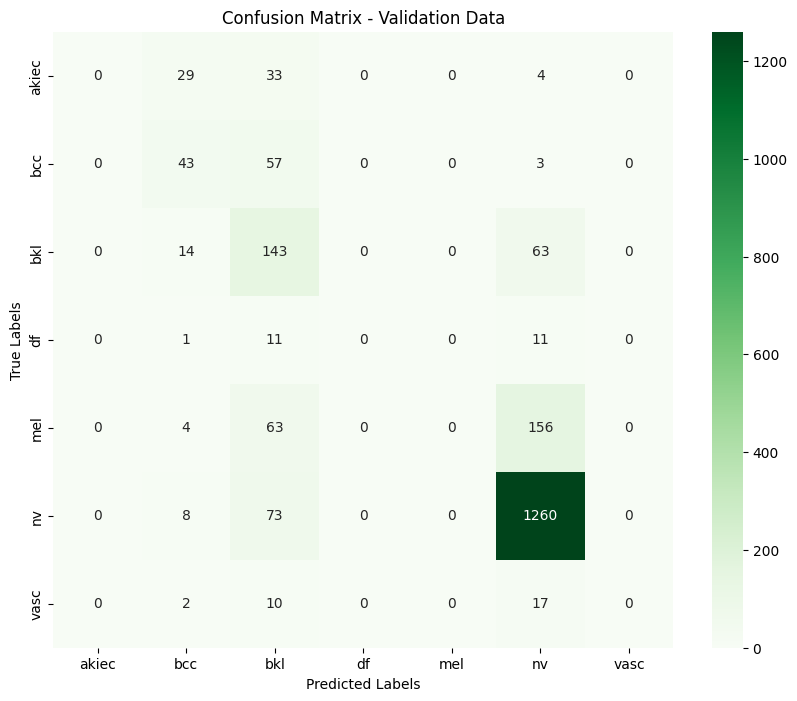

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.43      0.42      0.42       103
         bkl       0.37      0.65      0.47       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.83      0.94      0.88      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.72      2005
   macro avg       0.23      0.29      0.25      2005
weighted avg       0.62      0.72      0.66      2005



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

95/95 [==============================] - 11s 114ms/step


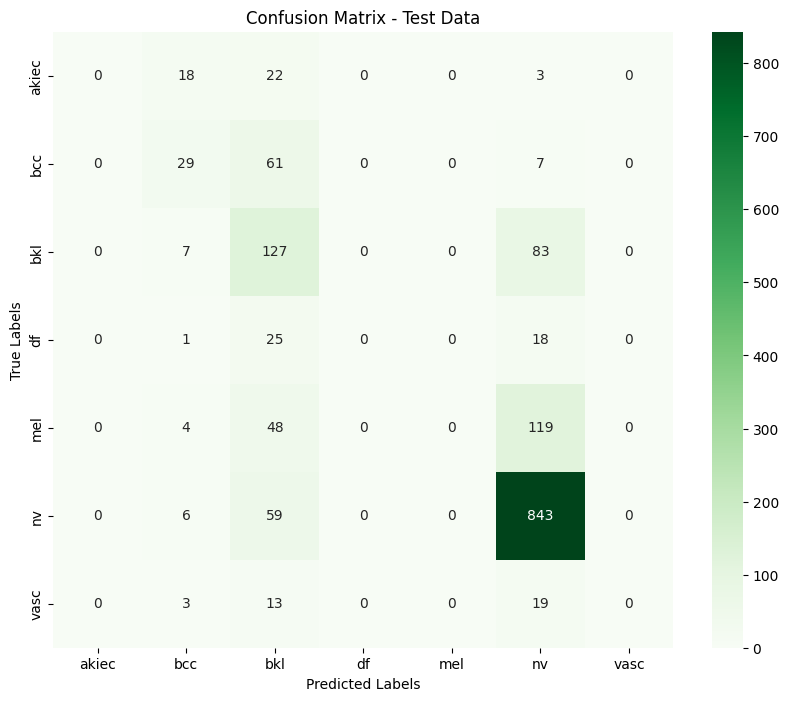

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.43      0.30      0.35        97
         bkl       0.36      0.59      0.44       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.77      0.93      0.84       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.66      1515
   macro avg       0.22      0.26      0.23      1515
weighted avg       0.54      0.66      0.59      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldInceptionV3.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

DenseNet121

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldDenseNet121.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )

Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 17s 161ms/step
Epoch 1 - Validation Loss: 1.2369, Validation Accuracy: 0.6789, Validation Precision: 0.5294

Epoch 1: val_loss improved from inf to 1.23691, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 359s - loss: 0.9496 - acc: 0.6701 - val_loss: 1.2369 - val_acc: 0.6789 - lr: 1.0000e-04 - 359s/epoch - 894ms/step
Epoch 2/1000
101/101 [==============================] - 16s 161ms/step
Epoch 2 - Validation Loss: 0.8298, Validation Accuracy: 0.7051, Validation Precision: 0.7321

Epoch 2: val_loss improved from 1.23691 to 0.82984, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.7987 - acc: 0.7181 - val_loss: 0.8298 - val_acc: 0.7051 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 3/1000
101/101 [==============================] - 16s 161ms/step
Epoch 3 - Validation Loss: 0.8741, Validation Accuracy: 0.7151, Validation Precision: 0.7489

Epoch 3: val_loss did not improve from 0.82984
401/401 - 349s - loss: 0.6995 - acc: 0.7590 - val_loss: 0.8741 - val_acc: 0.7151 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 160ms/step
Epoch 4 - Validation Loss: 0.7511, Validation Accuracy: 0.7263, Validation Precision: 0.8039

Epoch 4: val_loss improved from 0.82984 to 0.75108, saving model to 5foldDenseNet121.h5
401/401 - 350s - loss: 0.6338 - acc: 0.7794 - val_loss: 0.7511 - val_acc: 0.7263 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 5/1000
101/101 [==============================] - 16s 160ms/step
Epoch 5 - Validation Loss: 0.5294, Validation Accuracy: 0.8242, Validation Precision: 0.8325

Epoch 5: val_loss improved from 0.75108 to 0.52945, saving model to 5foldDenseNet121.h5
401/401 - 350s - loss: 0.5568 - acc: 0.8026 - val_loss: 0.5294 - val_acc: 0.8242 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 6/1000
101/101 [==============================] - 16s 160ms/step
Epoch 6 - Validation Loss: 0.5911, Validation Accuracy: 0.7936, Validation Precision: 0.8132

Epoch 6: val_loss did not improve from 0.52945
401/401 - 349s - loss: 0.5140 - acc: 0.8179 - v

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 358s - loss: 1.0066 - acc: 0.6388 - val_loss: 0.9215 - val_acc: 0.6552 - lr: 1.0000e-04 - 358s/epoch - 893ms/step
Epoch 2/1000
101/101 [==============================] - 16s 161ms/step
Epoch 2 - Validation Loss: 0.8046, Validation Accuracy: 0.7201, Validation Precision: 0.7628

Epoch 2: val_loss improved from 0.92150 to 0.80460, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.7846 - acc: 0.7192 - val_loss: 0.8046 - val_acc: 0.7201 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 3/1000
101/101 [==============================] - 16s 161ms/step
Epoch 3 - Validation Loss: 0.8099, Validation Accuracy: 0.7244, Validation Precision: 0.7249

Epoch 3: val_loss did not improve from 0.80460
401/401 - 349s - loss: 0.6753 - acc: 0.7541 - val_loss: 0.8099 - val_acc: 0.7244 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 4 - Validation Loss: 0.6580, Validation Accuracy: 0.7768, Validation Precision: 0.8119

Epoch 4: val_loss improved from 0.80460 to 0.65805, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.6169 - acc: 0.7816 - val_loss: 0.6580 - val_acc: 0.7768 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 5/1000
101/101 [==============================] - 16s 160ms/step
Epoch 5 - Validation Loss: 0.5758, Validation Accuracy: 0.8186, Validation Precision: 0.8060

Epoch 5: val_loss improved from 0.65805 to 0.57583, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.5650 - acc: 0.8022 - val_loss: 0.5758 - val_acc: 0.8186 - lr: 1.0000e-04 - 350s/epoch - 872ms/step
Epoch 6/1000
101/101 [==============================] - 16s 161ms/step
Epoch 6 - Validation Loss: 0.7406, Validation Accuracy: 0.7743, Validation Precision: 0.8232

Epoch 6: val_loss did not improve from 0.57583
401/401 - 349s - loss: 0.5189 - acc: 0.8268 - val_loss: 0.7406 - val_acc: 0.7743 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 7 - Validation Loss: 0.7543, Validation Accuracy: 0.7911, Validation Precision: 0.7915

Epoch 7: val_loss did not improve from 0.57583
401/401 - 349s - loss: 0.4792 - acc: 0.8315 - val_loss: 0.7543 - val_acc: 0.7911 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 8 - Validation Loss: 0.6554, Validation Accuracy: 0.8005, Validation Precision: 0.8134

Epoch 8: val_loss did not improve from 0.57583
401/401 - 349s - loss: 0.4515 - acc: 0.8495 - val_loss: 0.6554 - val_acc: 0.8005 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 9 - Validation Loss: 0.5606, Validation Accuracy: 0.8024, Validation Precision: 0.8433

Epoch 9: val_loss improved from 0.57583 to 0.56059, saving model to 5foldDenseNet121.h5
401/401 - 350s - loss: 0.4175 - acc: 0.8545 - val_loss: 0.5606 - val_acc: 0.8024 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 10/1000
101/101 [==============================] - 16s 161ms/step
Epoch 10 - Validation Loss: 0.5050, Validation Accuracy: 0.8273, Validation Precision: 0.8553

Epoch 10: val_loss improved from 0.56059 to 0.50498, saving model to 5foldDenseNet121.h5
401/401 - 350s - loss: 0.3874 - acc: 0.8661 - val_loss: 0.5050 - val_acc: 0.8273 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 11/1000
101/101 [==============================] - 16s 161ms/step
Epoch 11 - Validation Loss: 0.5181, Validation Accuracy: 0.8242, Validation Precision: 0.8333

Epoch 11: val_loss did not improve from 0.50498
401/401 - 349s - loss: 0.3601 - acc: 0.87

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 358s - loss: 1.0823 - acc: 0.6466 - val_loss: 0.8756 - val_acc: 0.6908 - lr: 1.0000e-04 - 358s/epoch - 893ms/step
Epoch 2/1000
101/101 [==============================] - 16s 161ms/step
Epoch 2 - Validation Loss: 0.7588, Validation Accuracy: 0.7039, Validation Precision: 0.6260

Epoch 2: val_loss improved from 0.87556 to 0.75878, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.8369 - acc: 0.7092 - val_loss: 0.7588 - val_acc: 0.7039 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 3/1000
101/101 [==============================] - 16s 161ms/step
Epoch 3 - Validation Loss: 0.9425, Validation Accuracy: 0.6502, Validation Precision: 0.7966

Epoch 3: val_loss did not improve from 0.75878
401/401 - 349s - loss: 0.7239 - acc: 0.7470 - val_loss: 0.9425 - val_acc: 0.6502 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 4 - Validation Loss: 0.7371, Validation Accuracy: 0.7300, Validation Precision: 0.7996

Epoch 4: val_loss improved from 0.75878 to 0.73715, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.6382 - acc: 0.7839 - val_loss: 0.7371 - val_acc: 0.7300 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 5/1000
101/101 [==============================] - 16s 161ms/step
Epoch 5 - Validation Loss: 0.7902, Validation Accuracy: 0.7488, Validation Precision: 0.7957

Epoch 5: val_loss did not improve from 0.73715
401/401 - 349s - loss: 0.6002 - acc: 0.7940 - val_loss: 0.7902 - val_acc: 0.7488 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 6/1000
101/101 [==============================] - 16s 160ms/step
Epoch 6 - Validation Loss: 0.5853, Validation Accuracy: 0.8067, Validation Precision: 0.8020

Epoch 6: val_loss improved from 0.73715 to 0.58531, saving model to 5foldDenseNet121.h5
401/401 - 350s - loss: 0.5493 - acc: 0.8082 - val_loss: 0.5853 - val_acc: 0.8067 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 7/1000
101/101 [==============================] - 16s 161ms/step
Epoch 7 - Validation Loss: 0.7772, Validation Accuracy: 0.7600, Validation Precision: 0.7788

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 359s - loss: 0.9444 - acc: 0.6753 - val_loss: 0.9370 - val_acc: 0.6818 - lr: 1.0000e-04 - 359s/epoch - 894ms/step
Epoch 2/1000
101/101 [==============================] - 16s 160ms/step
Epoch 2 - Validation Loss: 0.7098, Validation Accuracy: 0.7436, Validation Precision: 0.7710

Epoch 2: val_loss improved from 0.93703 to 0.70979, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.7770 - acc: 0.7272 - val_loss: 0.7098 - val_acc: 0.7436 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 3/1000
101/101 [==============================] - 19s 187ms/step
Epoch 3 - Validation Loss: 0.8480, Validation Accuracy: 0.6787, Validation Precision: 0.7995

Epoch 3: val_loss did not improve from 0.70979
401/401 - 353s - loss: 0.6942 - acc: 0.7560 - val_loss: 0.8480 - val_acc: 0.6787 - lr: 1.0000e-04 - 353s/epoch - 879ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 160ms/step
Epoch 4 - Validation Loss: 0.7172, Validation Accuracy: 0.7604, Validation Precision: 0.7459

Epoch 4: val_loss did not improve from 0.70979
401/401 - 349s - loss: 0.6336 - acc: 0.7772 - val_loss: 0.7172 - val_acc: 0.7604 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 160ms/step
Epoch 5 - Validation Loss: 0.5797, Validation Accuracy: 0.8141, Validation Precision: 0.8172

Epoch 5: val_loss improved from 0.70979 to 0.57970, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.5870 - acc: 0.7966 - val_loss: 0.5797 - val_acc: 0.8141 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 6/1000
101/101 [==============================] - 16s 160ms/step
Epoch 6 - Validation Loss: 0.6550, Validation Accuracy: 0.7704, Validation Precision: 0.7628

Epoch 6: val_loss did not improve from 0.57970
401/401 - 349s - loss: 0.5381 - acc: 0.8114 - val_loss: 0.6550 - val_acc: 0.7704 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 7 - Validation Loss: 0.7906, Validation Accuracy: 0.7785, Validation Precision: 0.7705

Epoch 7: val_loss did not improve from 0.57970
401/401 - 349s - loss: 0.4792 - acc: 0.8363 - val_loss: 0.7906 - val_acc: 0.7785 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 160ms/step
Epoch 8 - Validation Loss: 0.7193, Validation Accuracy: 0.7430, Validation Precision: 0.7995

Epoch 8: val_loss did not improve from 0.57970
401/401 - 349s - loss: 0.4548 - acc: 0.8435 - val_loss: 0.7193 - val_acc: 0.7430 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 9/1000
101/101 [==============================] - 16s 161ms/step
Epoch 9 - Validation Loss: 0.8487, Validation Accuracy: 0.7598, Validation Precision: 0.8409

Epoch 9: val_loss did not improve from 0.57970
401/401 - 349s - loss: 0.4252 - acc: 0.8564 - val_loss: 0.8487 - val_acc: 0.7598 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 10/1000
101/101 [==============================] - 16s 160ms/step
Epoch 10 - Validation Loss: 1.0109, Validation Accuracy: 0.5976, Validation Precision: 0.8172

Epoch 10: val_loss did not improve from 0.57970
401/401 - 350s - loss: 0.3906 - acc: 0.8705 - val_loss: 1.0109 - val_acc: 0.5976 - lr: 1.0000e-04 - 350s/epoch - 872ms/step
Fo

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1603 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 17s 160ms/step
Epoch 1 - Validation Loss: 0.8315, Validation Accuracy: 0.6993, Validation Precision: 0.5828

Epoch 1: val_loss improved from inf to 0.83149, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 358s - loss: 0.9257 - acc: 0.6728 - val_loss: 0.8315 - val_acc: 0.6993 - lr: 1.0000e-04 - 358s/epoch - 894ms/step
Epoch 2/1000
101/101 [==============================] - 16s 160ms/step
Epoch 2 - Validation Loss: 1.0640, Validation Accuracy: 0.4860, Validation Precision: 0.7566

Epoch 2: val_loss did not improve from 0.83149
401/401 - 349s - loss: 0.7180 - acc: 0.7467 - val_loss: 1.0640 - val_acc: 0.4860 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 3 - Validation Loss: 1.0001, Validation Accuracy: 0.6213, Validation Precision: 0.7179

Epoch 3: val_loss did not improve from 0.83149
401/401 - 349s - loss: 0.6440 - acc: 0.7691 - val_loss: 1.0001 - val_acc: 0.6213 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 4 - Validation Loss: 0.7462, Validation Accuracy: 0.7118, Validation Precision: 0.7695

Epoch 4: val_loss improved from 0.83149 to 0.74616, saving model to 5foldDenseNet121.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 350s - loss: 0.5618 - acc: 0.8059 - val_loss: 0.7462 - val_acc: 0.7118 - lr: 1.0000e-04 - 350s/epoch - 873ms/step
Epoch 5/1000
101/101 [==============================] - 16s 160ms/step
Epoch 5 - Validation Loss: 1.0018, Validation Accuracy: 0.5839, Validation Precision: 0.7878

Epoch 5: val_loss did not improve from 0.74616
401/401 - 349s - loss: 0.5249 - acc: 0.8210 - val_loss: 1.0018 - val_acc: 0.5839 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 16s 161ms/step
Epoch 6 - Validation Loss: 0.7823, Validation Accuracy: 0.7324, Validation Precision: 0.8021

Epoch 6: val_loss did not improve from 0.74616
401/401 - 349s - loss: 0.4732 - acc: 0.8387 - val_loss: 0.7823 - val_acc: 0.7324 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 7/1000
101/101 [==============================] - 16s 160ms/step
Epoch 7 - Validation Loss: 0.9052, Validation Accuracy: 0.6600, Validation Precision: 0.7985

Epoch 7: val_loss did not improve from 0.74616
401/401 - 349s - loss: 0.4547 - acc: 0.8489 - val_loss: 0.9052 - val_acc: 0.6600 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch 8/1000
101/101 [==============================] - 16s 160ms/step
Epoch 8 - Validation Loss: 0.8044, Validation Accuracy: 0.7012, Validation Precision: 0.8003

Epoch 8: val_loss did not improve from 0.74616
401/401 - 349s - loss: 0.4110 - acc: 0.8631 - val_loss: 0.8044 - val_acc: 0.7012 - lr: 1.0000e-04 - 349s/epoch - 871ms/step
Epoch

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 606, 456, 3)  0          ['input_16[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 300, 225, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 24s 190ms/step - loss: 0.5320 - acc: 0.8125
Validation accuracy: 0.8124688267707825
126/126 [==============================] - 20s 160ms/step
Validation Precision: 0.8039
Validation Recall: 0.8125
Validation F1-Score: 0.7923



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 18s 193ms/step - loss: 0.7142 - acc: 0.7558
Test accuracy: 0.7557755708694458
95/95 [==============================] - 15s 160ms/step
Test Precision: 0.7388
Test Recall: 0.7558
Test F1-Score: 0.7291



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 226s 451ms/step


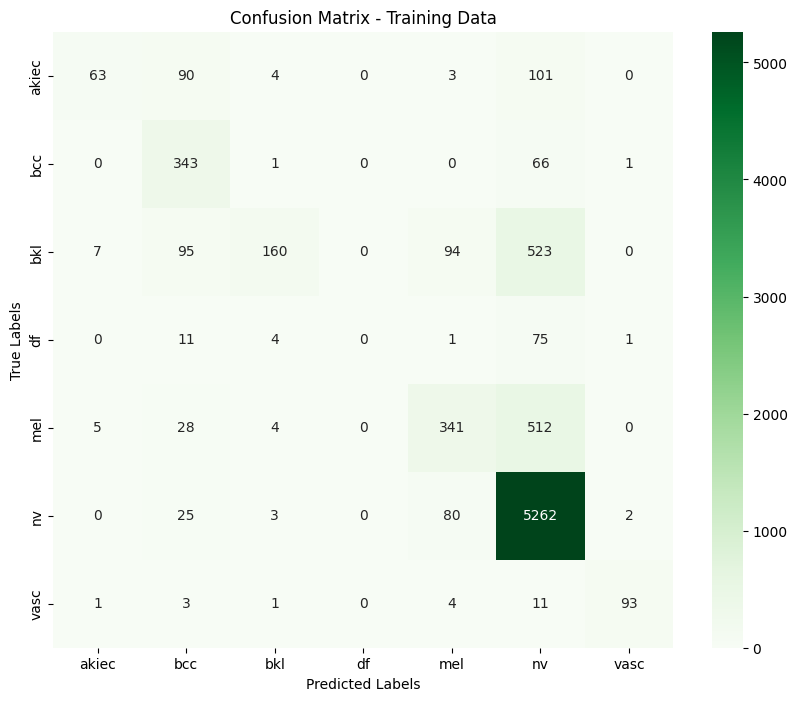

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.83      0.24      0.37       261
         bcc       0.58      0.83      0.68       411
         bkl       0.90      0.18      0.30       879
          df       0.00      0.00      0.00        92
         mel       0.65      0.38      0.48       890
          nv       0.80      0.98      0.88      5372
        vasc       0.96      0.82      0.89       113

    accuracy                           0.78      8018
   macro avg       0.67      0.49      0.52      8018
weighted avg       0.78      0.78      0.74      8018

126/126 [==============================] - 20s 160ms/step


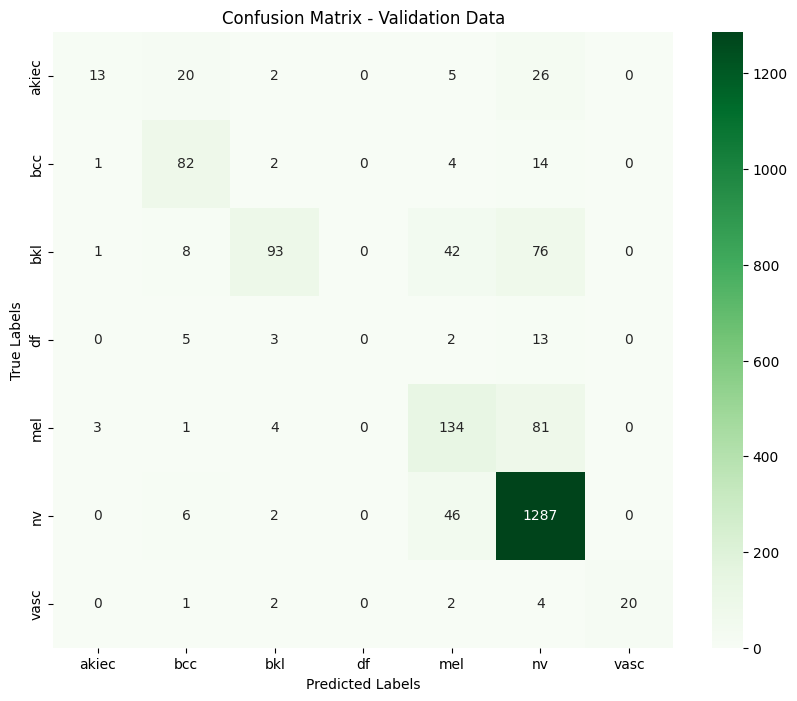

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.72      0.20      0.31        66
         bcc       0.67      0.80      0.73       103
         bkl       0.86      0.42      0.57       220
          df       0.00      0.00      0.00        23
         mel       0.57      0.60      0.59       223
          nv       0.86      0.96      0.91      1341
        vasc       1.00      0.69      0.82        29

    accuracy                           0.81      2005
   macro avg       0.67      0.52      0.56      2005
weighted avg       0.80      0.81      0.79      2005



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

95/95 [==============================] - 15s 160ms/step


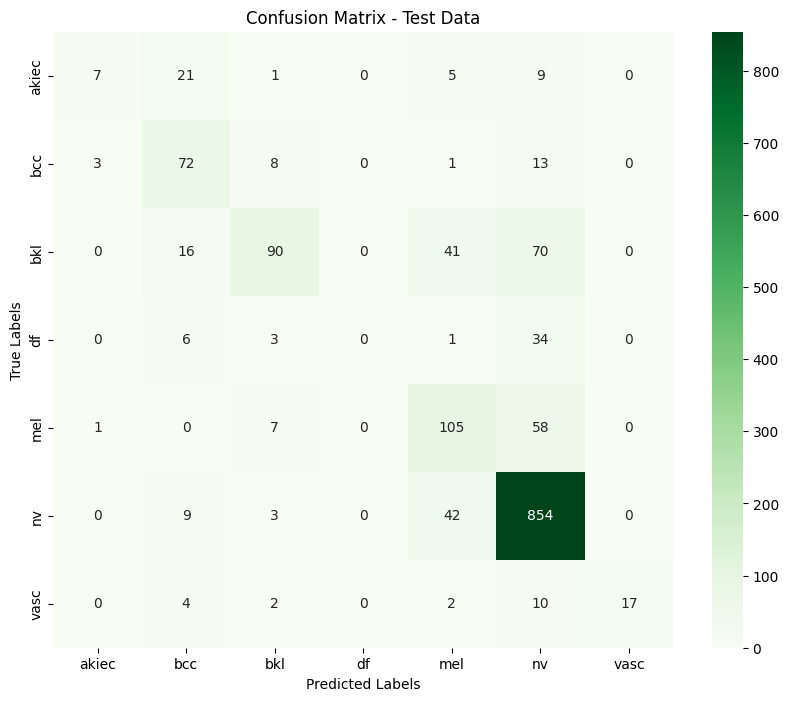

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.64      0.16      0.26        43
         bcc       0.56      0.74      0.64        97
         bkl       0.79      0.41      0.54       217
          df       0.00      0.00      0.00        44
         mel       0.53      0.61      0.57       171
          nv       0.81      0.94      0.87       908
        vasc       1.00      0.49      0.65        35

    accuracy                           0.76      1515
   macro avg       0.62      0.48      0.51      1515
weighted avg       0.74      0.76      0.73      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldDenseNet121.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

NASNetMobile

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldNASNetMobile.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )

Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 13s 112ms/step
Epoch 1 - Validation Loss: 1.1315, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.13153, saving model to 5foldNASNetMobile.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 231s - loss: 0.9982 - acc: 0.6762 - val_loss: 1.1315 - val_acc: 0.6696 - lr: 1.0000e-04 - 231s/epoch - 577ms/step
Epoch 2/1000
101/101 [==============================] - 11s 110ms/step
Epoch 2 - Validation Loss: 1.2620, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.13153
401/401 - 215s - loss: 0.7754 - acc: 0.7278 - val_loss: 1.2620 - val_acc: 0.6696 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 1.5003, Validation Accuracy: 0.6714, Validation Precision: 0.4911

Epoch 3: val_loss did not improve from 1.13153
401/401 - 215s - loss: 0.6472 - acc: 0.7777 - val_loss: 1.5003 - val_acc: 0.6714 - lr: 1.0000e-04 - 215s/epoch - 535ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 4 - Validation Loss: 1.2412, Validation Accuracy: 0.7095, Validation Precision: 0.6583

Epoch 4: val_loss did not improve from 1.13153
401/401 - 214s - loss: 0.5656 - acc: 0.8096 - val_loss: 1.2412 - val_acc: 0.7095 - lr: 1.0000e-04 - 214s/epoch - 535ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 5 - Validation Loss: 1.6920, Validation Accuracy: 0.6889, Validation Precision: 0.5609

Epoch 5: val_loss did not improve from 1.13153
401/401 - 213s - loss: 0.4906 - acc: 0.8344 - val_loss: 1.6920 - val_acc: 0.6889 - lr: 1.0000e-04 - 213s/epoch - 532ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 110ms/step
Epoch 6 - Validation Loss: 3.9004, Validation Accuracy: 0.6877, Validation Precision: 0.4483

Epoch 6: val_loss did not improve from 1.13153
401/401 - 213s - loss: 0.4377 - acc: 0.8513 - val_loss: 3.9004 - val_acc: 0.6877 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 14s 118ms/step
Epoch 1 - Validation Loss: 1.3975, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.39753, saving model to 5foldNASNetMobile.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 234s - loss: 1.0070 - acc: 0.6607 - val_loss: 1.3975 - val_acc: 0.6696 - lr: 1.0000e-04 - 234s/epoch - 585ms/step
Epoch 2/1000
101/101 [==============================] - 11s 113ms/step
Epoch 2 - Validation Loss: 1.7008, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.39753
401/401 - 216s - loss: 0.7620 - acc: 0.7346 - val_loss: 1.7008 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 3 - Validation Loss: 1.8340, Validation Accuracy: 0.6727, Validation Precision: 0.5022

Epoch 3: val_loss did not improve from 1.39753
401/401 - 214s - loss: 0.6396 - acc: 0.7771 - val_loss: 1.8340 - val_acc: 0.6727 - lr: 1.0000e-04 - 214s/epoch - 534ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 1.8878, Validation Accuracy: 0.6777, Validation Precision: 0.5253

Epoch 4: val_loss did not improve from 1.39753
401/401 - 216s - loss: 0.5709 - acc: 0.8070 - val_loss: 1.8878 - val_acc: 0.6777 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 113ms/step
Epoch 5 - Validation Loss: 2.8074, Validation Accuracy: 0.6733, Validation Precision: 0.6080

Epoch 5: val_loss did not improve from 1.39753
401/401 - 214s - loss: 0.5083 - acc: 0.8326 - val_loss: 2.8074 - val_acc: 0.6733 - lr: 1.0000e-04 - 214s/epoch - 535ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 113ms/step
Epoch 6 - Validation Loss: 3.5732, Validation Accuracy: 0.6764, Validation Precision: 0.4483

Epoch 6: val_loss did not improve from 1.39753
401/401 - 217s - loss: 0.4578 - acc: 0.8457 - val_loss: 3.5732 - val_acc: 0.6764 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 14s 114ms/step
Epoch 1 - Validation Loss: 1.5078, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.50779, saving model to 5foldNASNetMobile.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 233s - loss: 0.9788 - acc: 0.6731 - val_loss: 1.5078 - val_acc: 0.6696 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 2/1000
101/101 [==============================] - 11s 113ms/step
Epoch 2 - Validation Loss: 1.6056, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.50779
401/401 - 214s - loss: 0.7996 - acc: 0.7180 - val_loss: 1.6056 - val_acc: 0.6696 - lr: 1.0000e-04 - 214s/epoch - 533ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 3 - Validation Loss: 1.8484, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss did not improve from 1.50779
401/401 - 219s - loss: 0.6738 - acc: 0.7677 - val_loss: 1.8484 - val_acc: 0.6696 - lr: 1.0000e-04 - 219s/epoch - 545ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 3.2548, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss did not improve from 1.50779
401/401 - 215s - loss: 0.5790 - acc: 0.7992 - val_loss: 3.2548 - val_acc: 0.6696 - lr: 1.0000e-04 - 215s/epoch - 535ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 5 - Validation Loss: 4.0821, Validation Accuracy: 0.6708, Validation Precision: 0.5673

Epoch 5: val_loss did not improve from 1.50779
401/401 - 216s - loss: 0.5099 - acc: 0.8252 - val_loss: 4.0821 - val_acc: 0.6708 - lr: 1.0000e-04 - 216s/epoch - 537ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 113ms/step
Epoch 6 - Validation Loss: 5.4119, Validation Accuracy: 0.6702, Validation Precision: 0.4483

Epoch 6: val_loss did not improve from 1.50779
401/401 - 216s - loss: 0.4517 - acc: 0.8452 - val_loss: 5.4119 - val_acc: 0.6702 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 14s 116ms/step
Epoch 1 - Validation Loss: 1.1963, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.19629, saving model to 5foldNASNetMobile.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 235s - loss: 1.1055 - acc: 0.6242 - val_loss: 1.1963 - val_acc: 0.6706 - lr: 1.0000e-04 - 235s/epoch - 586ms/step
Epoch 2/1000
101/101 [==============================] - 11s 113ms/step
Epoch 2 - Validation Loss: 1.2012, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss did not improve from 1.19629
401/401 - 216s - loss: 0.8087 - acc: 0.7221 - val_loss: 1.2012 - val_acc: 0.6706 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 3 - Validation Loss: 2.9150, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss did not improve from 1.19629
401/401 - 222s - loss: 0.6704 - acc: 0.7747 - val_loss: 2.9150 - val_acc: 0.6706 - lr: 1.0000e-04 - 222s/epoch - 555ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 4 - Validation Loss: 2.8883, Validation Accuracy: 0.6775, Validation Precision: 0.4740

Epoch 4: val_loss did not improve from 1.19629
401/401 - 212s - loss: 0.5742 - acc: 0.8086 - val_loss: 2.8883 - val_acc: 0.6775 - lr: 1.0000e-04 - 212s/epoch - 530ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 110ms/step
Epoch 5 - Validation Loss: 3.5599, Validation Accuracy: 0.6706, Validation Precision: 0.4676

Epoch 5: val_loss did not improve from 1.19629
401/401 - 211s - loss: 0.5175 - acc: 0.8253 - val_loss: 3.5599 - val_acc: 0.6706 - lr: 1.0000e-04 - 211s/epoch - 526ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 111ms/step
Epoch 6 - Validation Loss: 4.2700, Validation Accuracy: 0.6719, Validation Precision: 0.4497

Epoch 6: val_loss did not improve from 1.19629
401/401 - 210s - loss: 0.4551 - acc: 0.8479 - val_loss: 4.2700 - val_acc: 0.6719 - lr: 1.0000e-04 - 210s/epoch - 524ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 14s 115ms/step
Epoch 1 - Validation Loss: 1.8572, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.85719, saving model to 5foldNASNetMobile.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 230s - loss: 0.9660 - acc: 0.6814 - val_loss: 1.8572 - val_acc: 0.6706 - lr: 1.0000e-04 - 230s/epoch - 574ms/step
Epoch 2/1000
101/101 [==============================] - 11s 113ms/step
Epoch 2 - Validation Loss: 2.3264, Validation Accuracy: 0.6706, Validation Precision: 0.4503

Epoch 2: val_loss did not improve from 1.85719
401/401 - 213s - loss: 0.7458 - acc: 0.7409 - val_loss: 2.3264 - val_acc: 0.6706 - lr: 1.0000e-04 - 213s/epoch - 531ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 3 - Validation Loss: 2.3108, Validation Accuracy: 0.6725, Validation Precision: 0.5020

Epoch 3: val_loss did not improve from 1.85719
401/401 - 212s - loss: 0.6476 - acc: 0.7797 - val_loss: 2.3108 - val_acc: 0.6725 - lr: 1.0000e-04 - 212s/epoch - 529ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 12s 114ms/step
Epoch 4 - Validation Loss: 2.8844, Validation Accuracy: 0.6725, Validation Precision: 0.4712

Epoch 4: val_loss did not improve from 1.85719
401/401 - 213s - loss: 0.5663 - acc: 0.8094 - val_loss: 2.8844 - val_acc: 0.6725 - lr: 1.0000e-04 - 213s/epoch - 532ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 113ms/step
Epoch 5 - Validation Loss: 2.4099, Validation Accuracy: 0.6850, Validation Precision: 0.5874

Epoch 5: val_loss did not improve from 1.85719
401/401 - 212s - loss: 0.4991 - acc: 0.8282 - val_loss: 2.4099 - val_acc: 0.6850 - lr: 1.0000e-04 - 212s/epoch - 528ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 11s 112ms/step
Epoch 6 - Validation Loss: 2.5508, Validation Accuracy: 0.6750, Validation Precision: 0.4497

Epoch 6: val_loss did not improve from 1.85719
401/401 - 213s - loss: 0.4429 - acc: 0.8546 - val_loss: 2.5508 - val_acc: 0.6750 - lr: 1.0000e-04 - 213s/epoch - 532ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 299, 224, 32  864         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 299, 224, 32  128         ['stem_conv1[0][0]']             
                                )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 15s 115ms/step - loss: 1.8768 - acc: 0.6688
Validation accuracy: 0.6688279509544373
126/126 [==============================] - 14s 111ms/step
Validation Precision: 0.4473
Validation Recall: 0.6688
Validation F1-Score: 0.5361



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 11s 111ms/step - loss: 2.2867 - acc: 0.5993
Test accuracy: 0.5993399620056152
95/95 [==============================] - 11s 113ms/step
Test Precision: 0.3592
Test Recall: 0.5993
Test F1-Score: 0.4492



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 239s 476ms/step


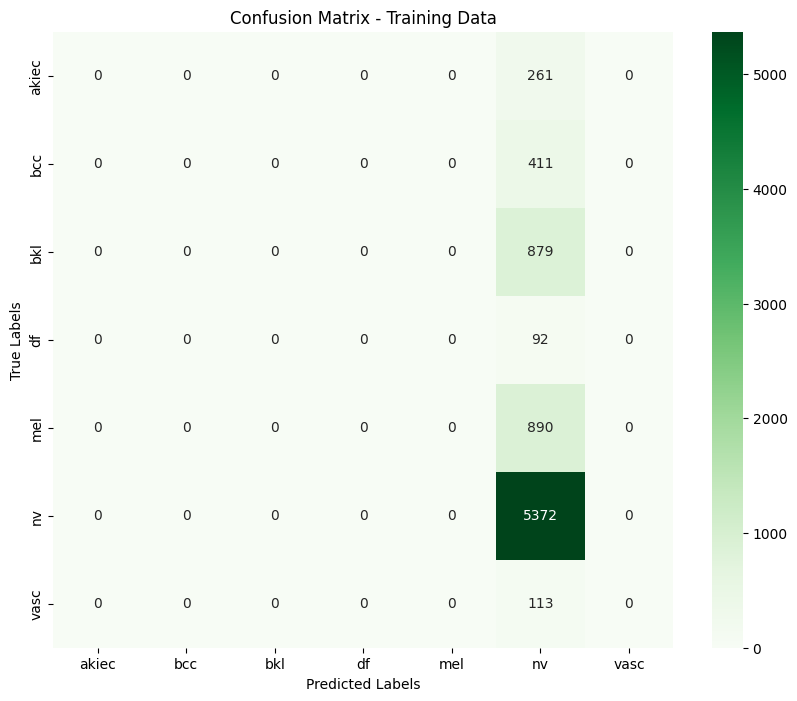

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.67      1.00      0.80      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.10      0.14      0.11      8018
weighted avg       0.45      0.67      0.54      8018

126/126 [==============================] - 16s 124ms/step


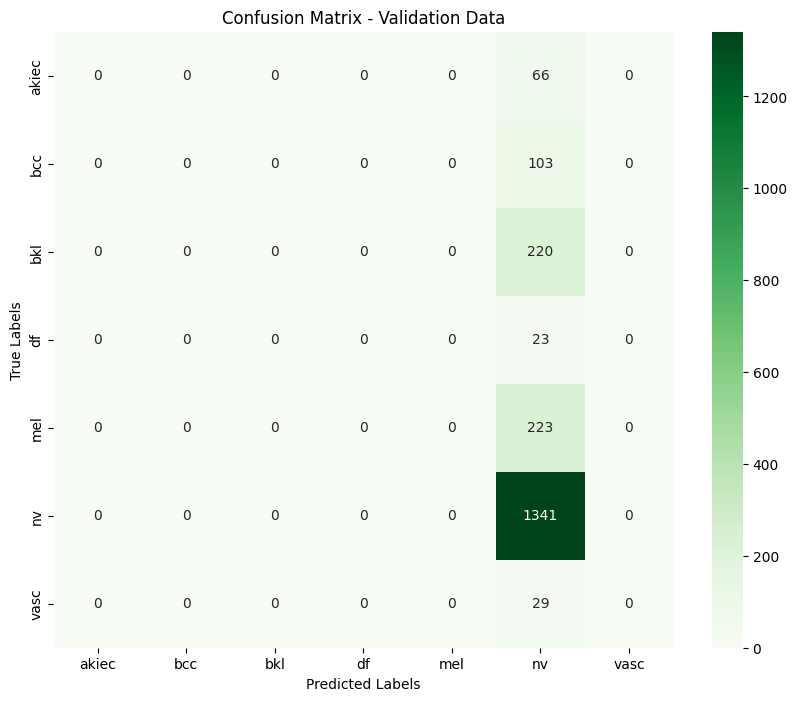

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005

95/95 [==============================] - 12s 126ms/step


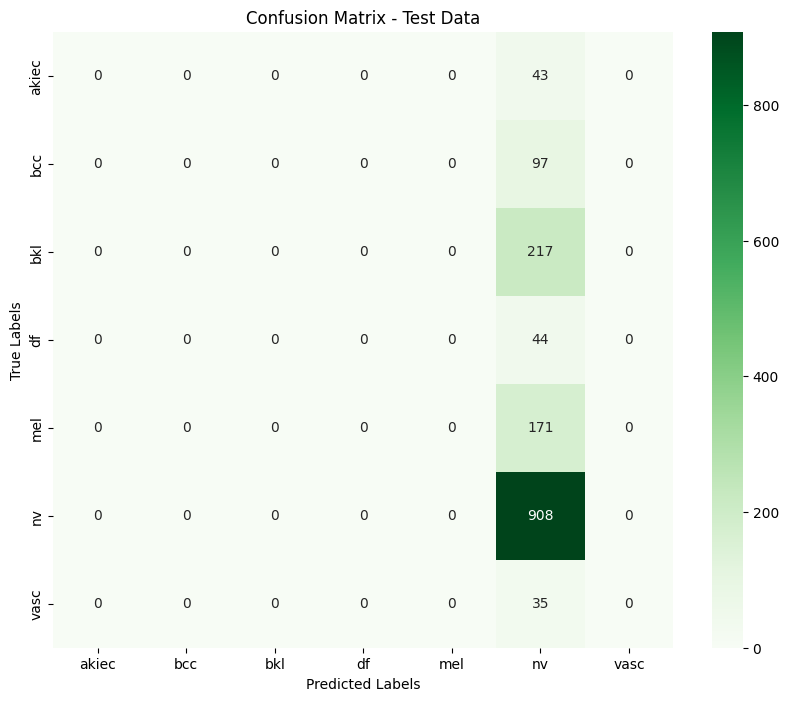

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.60      1.00      0.75       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.60      1515
   macro avg       0.09      0.14      0.11      1515
weighted avg       0.36      0.60      0.45      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldNASNetMobile.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

ResNet50

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldResNet50.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 17s 165ms/step
Epoch 1 - Validation Loss: 14.3728, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 14.37284, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 297s - loss: 0.9441 - acc: 0.6657 - val_loss: 14.3728 - val_acc: 0.6696 - lr: 1.0000e-04 - 297s/epoch - 741ms/step
Epoch 2/1000
101/101 [==============================] - 17s 165ms/step
Epoch 2 - Validation Loss: 1.1960, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 14.37284 to 1.19600, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 281s - loss: 0.7939 - acc: 0.7164 - val_loss: 1.1960 - val_acc: 0.6696 - lr: 1.0000e-04 - 281s/epoch - 701ms/step
Epoch 3/1000
101/101 [==============================] - 17s 165ms/step
Epoch 3 - Validation Loss: 0.6917, Validation Accuracy: 0.7537, Validation Precision: 0.7884

Epoch 3: val_loss improved from 1.19600 to 0.69172, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 272s - loss: 0.7200 - acc: 0.7421 - val_loss: 0.6917 - val_acc: 0.7537 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 4/1000
101/101 [==============================] - 17s 165ms/step
Epoch 4 - Validation Loss: 0.7021, Validation Accuracy: 0.7618, Validation Precision: 0.7946

Epoch 4: val_loss did not improve from 0.69172
401/401 - 271s - loss: 0.6566 - acc: 0.7700 - val_loss: 0.7021 - val_acc: 0.7618 - lr: 1.0000e-04 - 271s/epoch - 676ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 5 - Validation Loss: 1.0814, Validation Accuracy: 0.5948, Validation Precision: 0.7488

Epoch 5: val_loss did not improve from 0.69172
401/401 - 271s - loss: 0.6287 - acc: 0.7811 - val_loss: 1.0814 - val_acc: 0.5948 - lr: 1.0000e-04 - 271s/epoch - 677ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 6 - Validation Loss: 0.8528, Validation Accuracy: 0.7525, Validation Precision: 0.7985

Epoch 6: val_loss did not improve from 0.69172
401/401 - 271s - loss: 0.5971 - acc: 0.7940 - val_loss: 0.8528 - val_acc: 0.7525 - lr: 1.0000e-04 - 271s/epoch - 677ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 7 - Validation Loss: 0.6934, Validation Accuracy: 0.7600, Validation Precision: 0.7977

Epoch 7: val_loss did not improve from 0.69172
401/401 - 273s - loss: 0.5725 - acc: 0.8026 - val_loss: 0.6934 - val_acc: 0.7600 - lr: 1.0000e-04 - 273s/epoch - 680ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 8 - Validation Loss: 0.6744, Validation Accuracy: 0.7731, Validation Precision: 0.7959

Epoch 8: val_loss improved from 0.69172 to 0.67441, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 272s - loss: 0.5181 - acc: 0.8157 - val_loss: 0.6744 - val_acc: 0.7731 - lr: 1.0000e-04 - 272s/epoch - 679ms/step
Epoch 9/1000
101/101 [==============================] - 17s 165ms/step
Epoch 9 - Validation Loss: 0.7509, Validation Accuracy: 0.7650, Validation Precision: 0.7302

Epoch 9: val_loss did not improve from 0.67441
401/401 - 272s - loss: 0.5034 - acc: 0.8230 - val_loss: 0.7509 - val_acc: 0.7650 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 10 - Validation Loss: 0.6902, Validation Accuracy: 0.7587, Validation Precision: 0.7524

Epoch 10: val_loss did not improve from 0.67441
401/401 - 272s - loss: 0.4685 - acc: 0.8383 - val_loss: 0.6902 - val_acc: 0.7587 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 11/1000
101/101 [==============================] - 17s 165ms/step
Epoch 11 - Validation Loss: 0.7250, Validation Accuracy: 0.7812, Validation Precision: 0.7876

Epoch 11: val_loss did not improve from 0.67441
401/401 - 272s - loss: 0.4374 - acc: 0.8499 - val_loss: 0.7250 - val_acc: 0.7812 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 12/1000
101/101 [==============================] - 17s 165ms/step
Epoch 12 - Validation Loss: 0.9177, Validation Accuracy: 0.7450, Validation Precision: 0.8257

Epoch 12: val_loss did not improve from 0.67441
401/401 - 272s - loss: 0.4223 - acc: 0.8522 - val_loss: 0.9177 - val_acc: 0.7450 - lr: 1.0000e-04 - 272s/epoch - 677ms/st

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 279s - loss: 0.9210 - acc: 0.6749 - val_loss: 1.1528 - val_acc: 0.6696 - lr: 1.0000e-04 - 279s/epoch - 697ms/step
Epoch 2/1000
101/101 [==============================] - 17s 167ms/step
Epoch 2 - Validation Loss: 2.0440, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.15280
401/401 - 274s - loss: 0.7843 - acc: 0.7131 - val_loss: 2.0440 - val_acc: 0.6696 - lr: 1.0000e-04 - 274s/epoch - 682ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 166ms/step
Epoch 3 - Validation Loss: 0.8732, Validation Accuracy: 0.7057, Validation Precision: 0.7235

Epoch 3: val_loss improved from 1.15280 to 0.87319, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 274s - loss: 0.7194 - acc: 0.7356 - val_loss: 0.8732 - val_acc: 0.7057 - lr: 1.0000e-04 - 274s/epoch - 683ms/step
Epoch 4/1000
101/101 [==============================] - 17s 166ms/step
Epoch 4 - Validation Loss: 0.7919, Validation Accuracy: 0.7506, Validation Precision: 0.7170

Epoch 4: val_loss improved from 0.87319 to 0.79192, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 275s - loss: 0.6719 - acc: 0.7579 - val_loss: 0.7919 - val_acc: 0.7506 - lr: 1.0000e-04 - 275s/epoch - 685ms/step
Epoch 5/1000
101/101 [==============================] - 17s 166ms/step
Epoch 5 - Validation Loss: 0.6884, Validation Accuracy: 0.7550, Validation Precision: 0.7934

Epoch 5: val_loss improved from 0.79192 to 0.68842, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 274s - loss: 0.6138 - acc: 0.7820 - val_loss: 0.6884 - val_acc: 0.7550 - lr: 1.0000e-04 - 274s/epoch - 683ms/step
Epoch 6/1000
101/101 [==============================] - 17s 166ms/step
Epoch 6 - Validation Loss: 0.6217, Validation Accuracy: 0.7980, Validation Precision: 0.7593

Epoch 6: val_loss improved from 0.68842 to 0.62170, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 274s - loss: 0.5818 - acc: 0.7909 - val_loss: 0.6217 - val_acc: 0.7980 - lr: 1.0000e-04 - 274s/epoch - 684ms/step
Epoch 7/1000
101/101 [==============================] - 17s 167ms/step
Epoch 7 - Validation Loss: 0.8054, Validation Accuracy: 0.7612, Validation Precision: 0.7207

Epoch 7: val_loss did not improve from 0.62170
401/401 - 274s - loss: 0.5530 - acc: 0.8017 - val_loss: 0.8054 - val_acc: 0.7612 - lr: 1.0000e-04 - 274s/epoch - 682ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 166ms/step
Epoch 8 - Validation Loss: 0.7378, Validation Accuracy: 0.7899, Validation Precision: 0.7989

Epoch 8: val_loss did not improve from 0.62170
401/401 - 274s - loss: 0.5187 - acc: 0.8170 - val_loss: 0.7378 - val_acc: 0.7899 - lr: 1.0000e-04 - 274s/epoch - 682ms/step
Epoch 9/1000
101/101 [==============================] - 17s 167ms/step
Epoch 9 - Validation Loss: 0.7971, Validation Accuracy: 0.7512, Validation Precision: 0.7709

Epoch 9: val_loss did not improve from 0.62170
401/401 - 274s - loss: 0.5010 - acc: 0.8230 - val_loss: 0.7971 - val_acc: 0.7512 - lr: 1.0000e-04 - 274s/epoch - 683ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 166ms/step
Epoch 10 - Validation Loss: 0.6868, Validation Accuracy: 0.7444, Validation Precision: 0.7997

Epoch 10: val_loss did not improve from 0.62170
401/401 - 274s - loss: 0.4868 - acc: 0.8260 - val_loss: 0.6868 - val_acc: 0.7444 - lr: 1.0000e-04 - 274s/epoch - 682ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 11 - Validation Loss: 0.7681, Validation Accuracy: 0.7724, Validation Precision: 0.7593

Epoch 11: val_loss did not improve from 0.62170
401/401 - 273s - loss: 0.4524 - acc: 0.8382 - val_loss: 0.7681 - val_acc: 0.7724 - lr: 1.0000e-04 - 273s/epoch - 682ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 17s 165ms/step
Epoch 1 - Validation Loss: 1.6534, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.65342, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 280s - loss: 0.9499 - acc: 0.6740 - val_loss: 1.6534 - val_acc: 0.6696 - lr: 1.0000e-04 - 280s/epoch - 697ms/step
Epoch 2/1000
101/101 [==============================] - 17s 165ms/step
Epoch 2 - Validation Loss: 1.4937, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.65342 to 1.49372, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 273s - loss: 0.7936 - acc: 0.7095 - val_loss: 1.4937 - val_acc: 0.6696 - lr: 1.0000e-04 - 273s/epoch - 680ms/step
Epoch 3/1000
101/101 [==============================] - 17s 165ms/step
Epoch 3 - Validation Loss: 0.9157, Validation Accuracy: 0.7145, Validation Precision: 0.7029

Epoch 3: val_loss improved from 1.49372 to 0.91574, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 273s - loss: 0.7205 - acc: 0.7392 - val_loss: 0.9157 - val_acc: 0.7145 - lr: 1.0000e-04 - 273s/epoch - 680ms/step
Epoch 4/1000
101/101 [==============================] - 17s 165ms/step
Epoch 4 - Validation Loss: 0.7045, Validation Accuracy: 0.7488, Validation Precision: 0.7354

Epoch 4: val_loss improved from 0.91574 to 0.70453, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 273s - loss: 0.6738 - acc: 0.7534 - val_loss: 0.7045 - val_acc: 0.7488 - lr: 1.0000e-04 - 273s/epoch - 680ms/step
Epoch 5/1000
101/101 [==============================] - 17s 165ms/step
Epoch 5 - Validation Loss: 1.1699, Validation Accuracy: 0.6964, Validation Precision: 0.7995

Epoch 5: val_loss did not improve from 0.70453
401/401 - 272s - loss: 0.6272 - acc: 0.7856 - val_loss: 1.1699 - val_acc: 0.6964 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 167ms/step
Epoch 6 - Validation Loss: 0.5499, Validation Accuracy: 0.8074, Validation Precision: 0.8076

Epoch 6: val_loss improved from 0.70453 to 0.54991, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 274s - loss: 0.5966 - acc: 0.7954 - val_loss: 0.5499 - val_acc: 0.8074 - lr: 1.0000e-04 - 274s/epoch - 684ms/step
Epoch 7/1000
101/101 [==============================] - 17s 165ms/step
Epoch 7 - Validation Loss: 0.8317, Validation Accuracy: 0.7544, Validation Precision: 0.7289

Epoch 7: val_loss did not improve from 0.54991
401/401 - 273s - loss: 0.5429 - acc: 0.8053 - val_loss: 0.8317 - val_acc: 0.7544 - lr: 1.0000e-04 - 273s/epoch - 681ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 8 - Validation Loss: 0.6664, Validation Accuracy: 0.7737, Validation Precision: 0.8044

Epoch 8: val_loss did not improve from 0.54991
401/401 - 272s - loss: 0.5034 - acc: 0.8240 - val_loss: 0.6664 - val_acc: 0.7737 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 9 - Validation Loss: 0.7118, Validation Accuracy: 0.7887, Validation Precision: 0.8161

Epoch 9: val_loss did not improve from 0.54991
401/401 - 272s - loss: 0.5032 - acc: 0.8268 - val_loss: 0.7118 - val_acc: 0.7887 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 10/1000
101/101 [==============================] - 17s 165ms/step
Epoch 10 - Validation Loss: 0.8085, Validation Accuracy: 0.7612, Validation Precision: 0.7863

Epoch 10: val_loss did not improve from 0.54991
401/401 - 272s - loss: 0.4580 - acc: 0.8402 - val_loss: 0.8085 - val_acc: 0.7612 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 11 - Validation Loss: 0.5913, Validation Accuracy: 0.7793, Validation Precision: 0.8076

Epoch 11: val_loss did not improve from 0.54991
401/401 - 272s - loss: 0.4327 - acc: 0.8483 - val_loss: 0.5913 - val_acc: 0.7793 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 17s 165ms/step
Epoch 1 - Validation Loss: 3.3261, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 3.32614, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 279s - loss: 0.9418 - acc: 0.6753 - val_loss: 3.3261 - val_acc: 0.6706 - lr: 1.0000e-04 - 279s/epoch - 696ms/step
Epoch 2/1000
101/101 [==============================] - 17s 165ms/step
Epoch 2 - Validation Loss: 1.2967, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 3.32614 to 1.29675, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 272s - loss: 0.7953 - acc: 0.7161 - val_loss: 1.2967 - val_acc: 0.6706 - lr: 1.0000e-04 - 272s/epoch - 679ms/step
Epoch 3/1000
101/101 [==============================] - 17s 165ms/step
Epoch 3 - Validation Loss: 0.8351, Validation Accuracy: 0.6974, Validation Precision: 0.6239

Epoch 3: val_loss improved from 1.29675 to 0.83513, saving model to 5foldResNet50.h5
401/401 - 272s - loss: 0.7117 - acc: 0.7462 - val_loss: 0.8351 - val_acc: 0.6974 - lr: 1.0000e-04 - 272s/epoch - 679ms/step
Epoch 4/1000
101/101 [==============================] - 17s 165ms/step
Epoch 4 - Validation Loss: 0.7239, Validation Accuracy: 0.7180, Validation Precision: 0.7685

Epoch 4: val_loss improved from 0.83513 to 0.72388, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 272s - loss: 0.6690 - acc: 0.7592 - val_loss: 0.7239 - val_acc: 0.7180 - lr: 1.0000e-04 - 272s/epoch - 679ms/step
Epoch 5/1000
101/101 [==============================] - 17s 165ms/step
Epoch 5 - Validation Loss: 0.7245, Validation Accuracy: 0.7667, Validation Precision: 0.7418

Epoch 5: val_loss did not improve from 0.72388
401/401 - 272s - loss: 0.6075 - acc: 0.7883 - val_loss: 0.7245 - val_acc: 0.7667 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 6 - Validation Loss: 0.6639, Validation Accuracy: 0.7617, Validation Precision: 0.7688

Epoch 6: val_loss improved from 0.72388 to 0.66390, saving model to 5foldResNet50.h5
401/401 - 272s - loss: 0.5781 - acc: 0.7939 - val_loss: 0.6639 - val_acc: 0.7617 - lr: 1.0000e-04 - 272s/epoch - 679ms/step
Epoch 7/1000
101/101 [==============================] - 17s 165ms/step
Epoch 7 - Validation Loss: 0.7898, Validation Accuracy: 0.7062, Validation Precision: 0.7994

Epoch 7: val_loss did not improve from 0.66390
401/401 - 272s - loss: 0.5510 - acc: 0.8045 - val_loss: 0.7898 - val_acc: 0.7062 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 8/1000
101/101 [==============================] - 17s 165ms/step
Epoch 8 - Validation Loss: 0.8548, Validation Accuracy: 0.7629, Validation Precision: 0.7857

Epoch 8: val_loss did not improve from 0.66390
401/401 - 272s - loss: 0.5176 - acc: 0.8161 - val_loss: 0.8548 - val_acc: 0.7629 - lr: 1.00

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 9 - Validation Loss: 1.7506, Validation Accuracy: 0.5926, Validation Precision: 0.7771

Epoch 9: val_loss did not improve from 0.66390
401/401 - 272s - loss: 0.4971 - acc: 0.8265 - val_loss: 1.7506 - val_acc: 0.5926 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 10 - Validation Loss: 0.7227, Validation Accuracy: 0.7779, Validation Precision: 0.8106

Epoch 10: val_loss did not improve from 0.66390
401/401 - 271s - loss: 0.4701 - acc: 0.8346 - val_loss: 0.7227 - val_acc: 0.7779 - lr: 1.0000e-04 - 271s/epoch - 677ms/step
Epoch 11/1000
101/101 [==============================] - 17s 165ms/step
Epoch 11 - Validation Loss: 0.6262, Validation Accuracy: 0.7548, Validation Precision: 0.8333

Epoch 11: val_loss improved from 0.66390 to 0.62616, saving model to 5foldResNet50.h5
401/401 - 272s - loss: 0.4430 - acc: 0.8466 - val_loss: 0.6262 - val_acc: 0.7548 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 12/1000
101/101 [==============================] - 17s 165ms/step
Epoch 12 - Validation Loss: 0.7991, Validation Accuracy: 0.7754, Validation Precision: 0.8016

Epoch 12: val_loss did not improve from 0.62616
401/401 - 272s - loss: 0.4160 - acc: 0.8560 - val_loss: 0.7991 - val_acc: 0.7754 - 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 15 - Validation Loss: 0.8836, Validation Accuracy: 0.7386, Validation Precision: 0.8097

Epoch 15: val_loss did not improve from 0.62616
401/401 - 272s - loss: 0.3761 - acc: 0.8639 - val_loss: 0.8836 - val_acc: 0.7386 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 16/1000
101/101 [==============================] - 17s 165ms/step
Epoch 16 - Validation Loss: 0.7352, Validation Accuracy: 0.7604, Validation Precision: 0.8333

Epoch 16: val_loss did not improve from 0.62616
401/401 - 272s - loss: 0.3538 - acc: 0.8750 - val_loss: 0.7352 - val_acc: 0.7604 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 17s 165ms/step
Epoch 1 - Validation Loss: 1.1561, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 276s - loss: 0.9502 - acc: 0.6659 - val_loss: 1.1561 - val_acc: 0.6706 - lr: 1.0000e-04 - 276s/epoch - 689ms/step
Epoch 2/1000
101/101 [==============================] - 17s 165ms/step
Epoch 2 - Validation Loss: 1.9072, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss did not improve from 1.15609
401/401 - 272s - loss: 0.7728 - acc: 0.7119 - val_loss: 1.9072 - val_acc: 0.6706 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 3 - Validation Loss: 0.8769, Validation Accuracy: 0.6831, Validation Precision: 0.7223

Epoch 3: val_loss improved from 1.15609 to 0.87694, saving model to 5foldResNet50.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 272s - loss: 0.7202 - acc: 0.7405 - val_loss: 0.8769 - val_acc: 0.6831 - lr: 1.0000e-04 - 272s/epoch - 678ms/step
Epoch 4/1000
101/101 [==============================] - 17s 165ms/step
Epoch 4 - Validation Loss: 1.8358, Validation Accuracy: 0.3075, Validation Precision: 0.6975

Epoch 4: val_loss did not improve from 0.87694
401/401 - 272s - loss: 0.6569 - acc: 0.7595 - val_loss: 1.8358 - val_acc: 0.3075 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 5 - Validation Loss: 0.8956, Validation Accuracy: 0.6600, Validation Precision: 0.7405

Epoch 5: val_loss did not improve from 0.87694
401/401 - 272s - loss: 0.6063 - acc: 0.7882 - val_loss: 0.8956 - val_acc: 0.6600 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 6 - Validation Loss: 1.1089, Validation Accuracy: 0.5502, Validation Precision: 0.7589

Epoch 6: val_loss did not improve from 0.87694
401/401 - 272s - loss: 0.5705 - acc: 0.8027 - val_loss: 1.1089 - val_acc: 0.5502 - lr: 1.0000e-04 - 272s/epoch - 677ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 7 - Validation Loss: 1.3640, Validation Accuracy: 0.4311, Validation Precision: 0.7755

Epoch 7: val_loss did not improve from 0.87694
401/401 - 271s - loss: 0.5243 - acc: 0.8153 - val_loss: 1.3640 - val_acc: 0.4311 - lr: 1.0000e-04 - 271s/epoch - 677ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 17s 165ms/step
Epoch 8 - Validation Loss: 1.2628, Validation Accuracy: 0.4261, Validation Precision: 0.7223

Epoch 8: val_loss did not improve from 0.87694
401/401 - 272s - loss: 0.4968 - acc: 0.8243 - val_loss: 1.2628 - val_acc: 0.4261 - lr: 1.0000e-04 - 272s/epoch - 677ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 606, 456, 3)  0           ['input_26[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 300, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 25s 195ms/step - loss: 0.7518 - acc: 0.7207
Validation accuracy: 0.7206982374191284
126/126 [==============================] - 21s 165ms/step
Validation Precision: 0.7372
Validation Recall: 0.7207
Validation F1-Score: 0.6949



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 18s 193ms/step - loss: 0.8815 - acc: 0.6832
Test accuracy: 0.6831682920455933
95/95 [==============================] - 16s 165ms/step
Test Precision: 0.6684
Test Recall: 0.6832
Test F1-Score: 0.6455



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 224s 446ms/step


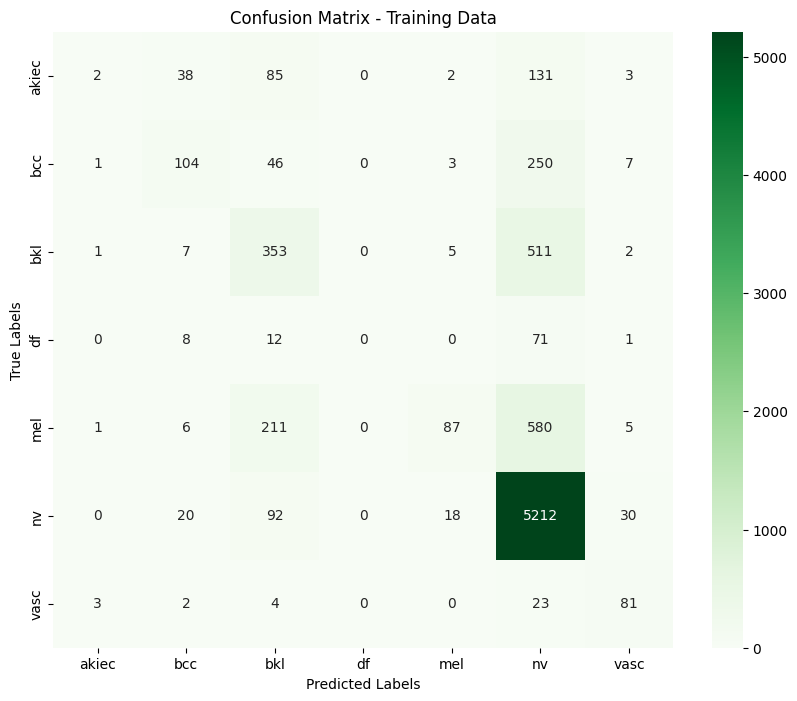

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.25      0.01      0.01       261
         bcc       0.56      0.25      0.35       411
         bkl       0.44      0.40      0.42       879
          df       0.00      0.00      0.00        92
         mel       0.76      0.10      0.17       890
          nv       0.77      0.97      0.86      5372
        vasc       0.63      0.72      0.67       113

    accuracy                           0.73      8018
   macro avg       0.49      0.35      0.35      8018
weighted avg       0.69      0.73      0.67      8018

126/126 [==============================] - 21s 165ms/step


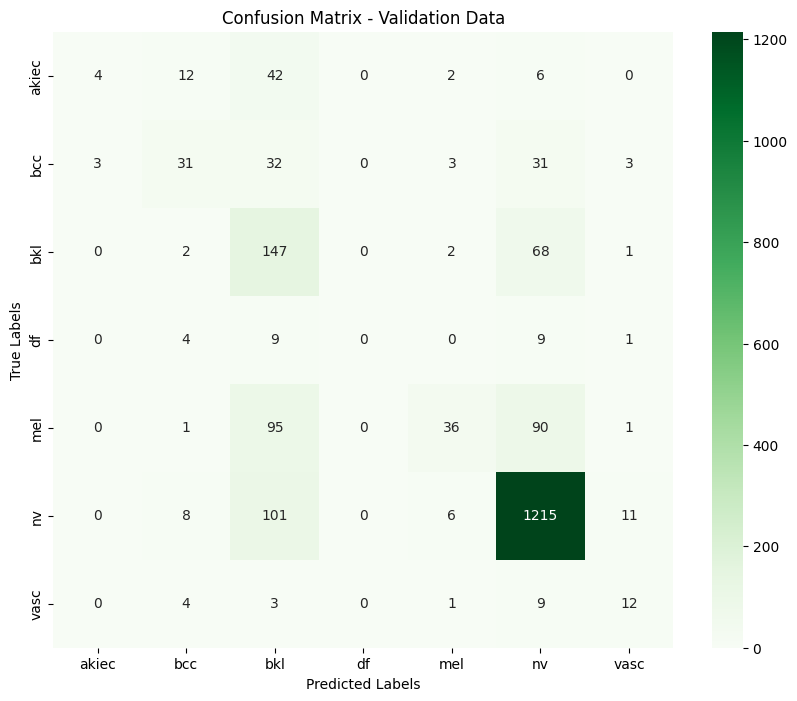

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.57      0.06      0.11        66
         bcc       0.50      0.30      0.38       103
         bkl       0.34      0.67      0.45       220
          df       0.00      0.00      0.00        23
         mel       0.72      0.16      0.26       223
          nv       0.85      0.91      0.88      1341
        vasc       0.41      0.41      0.41        29

    accuracy                           0.72      2005
   macro avg       0.49      0.36      0.36      2005
weighted avg       0.74      0.72      0.69      2005



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

95/95 [==============================] - 16s 165ms/step


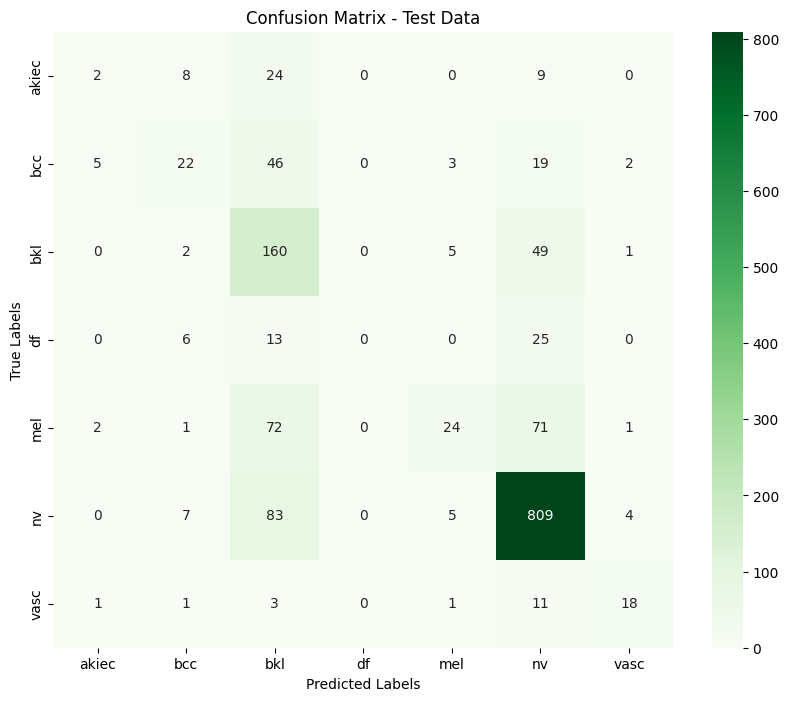

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.20      0.05      0.08        43
         bcc       0.47      0.23      0.31        97
         bkl       0.40      0.74      0.52       217
          df       0.00      0.00      0.00        44
         mel       0.63      0.14      0.23       171
          nv       0.81      0.89      0.85       908
        vasc       0.69      0.51      0.59        35

    accuracy                           0.68      1515
   macro avg       0.46      0.37      0.37      1515
weighted avg       0.67      0.68      0.65      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldResNet50.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

Resnet101

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldResNet101.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 26s 253ms/step
Epoch 1 - Validation Loss: 4.5519, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 4.55191, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 431s - loss: 0.9554 - acc: 0.6654 - val_loss: 4.5519 - val_acc: 0.6696 - lr: 1.0000e-04 - 431s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 26s 254ms/step
Epoch 2 - Validation Loss: 1.7090, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 4.55191 to 1.70904, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 422s - loss: 0.8028 - acc: 0.7178 - val_loss: 1.7090 - val_acc: 0.6696 - lr: 1.0000e-04 - 422s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 26s 254ms/step
Epoch 3 - Validation Loss: 0.7911, Validation Accuracy: 0.7014, Validation Precision: 0.7025

Epoch 3: val_loss improved from 1.70904 to 0.79106, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 422s - loss: 0.7364 - acc: 0.7357 - val_loss: 0.7911 - val_acc: 0.7014 - lr: 1.0000e-04 - 422s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 26s 254ms/step
Epoch 4 - Validation Loss: 0.9325, Validation Accuracy: 0.6796, Validation Precision: 0.7535

Epoch 4: val_loss did not improve from 0.79106
401/401 - 420s - loss: 0.6860 - acc: 0.7626 - val_loss: 0.9325 - val_acc: 0.6796 - lr: 1.0000e-04 - 420s/epoch - 1s/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 5 - Validation Loss: 0.6101, Validation Accuracy: 0.7812, Validation Precision: 0.7850

Epoch 5: val_loss improved from 0.79106 to 0.61011, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 0.6308 - acc: 0.7820 - val_loss: 0.6101 - val_acc: 0.7812 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 6/1000
101/101 [==============================] - 26s 254ms/step
Epoch 6 - Validation Loss: 1.0602, Validation Accuracy: 0.7014, Validation Precision: 0.7938

Epoch 6: val_loss did not improve from 0.61011
401/401 - 420s - loss: 0.5966 - acc: 0.7880 - val_loss: 1.0602 - val_acc: 0.7014 - lr: 1.0000e-04 - 420s/epoch - 1s/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 7 - Validation Loss: 1.1778, Validation Accuracy: 0.6291, Validation Precision: 0.7750

Epoch 7: val_loss did not improve from 0.61011
401/401 - 419s - loss: 0.5596 - acc: 0.8068 - val_loss: 1.1778 - val_acc: 0.6291 - lr: 1.0000e-04 - 419s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 8 - Validation Loss: 0.5742, Validation Accuracy: 0.8123, Validation Precision: 0.8029

Epoch 8: val_loss improved from 0.61011 to 0.57417, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 0.5283 - acc: 0.8146 - val_loss: 0.5742 - val_acc: 0.8123 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 9/1000
101/101 [==============================] - 26s 254ms/step
Epoch 9 - Validation Loss: 0.5810, Validation Accuracy: 0.7918, Validation Precision: 0.7886

Epoch 9: val_loss did not improve from 0.57417
401/401 - 420s - loss: 0.4936 - acc: 0.8330 - val_loss: 0.5810 - val_acc: 0.7918 - lr: 1.0000e-04 - 420s/epoch - 1s/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 10 - Validation Loss: 1.1633, Validation Accuracy: 0.7357, Validation Precision: 0.7922

Epoch 10: val_loss did not improve from 0.57417
401/401 - 419s - loss: 0.4742 - acc: 0.8371 - val_loss: 1.1633 - val_acc: 0.7357 - lr: 1.0000e-04 - 419s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 11 - Validation Loss: 0.6827, Validation Accuracy: 0.8186, Validation Precision: 0.8102

Epoch 11: val_loss did not improve from 0.57417
401/401 - 419s - loss: 0.4560 - acc: 0.8408 - val_loss: 0.6827 - val_acc: 0.8186 - lr: 1.0000e-04 - 419s/epoch - 1s/step
Epoch 12/1000
101/101 [==============================] - 26s 254ms/step
Epoch 12 - Validation Loss: 1.0565, Validation Accuracy: 0.7569, Validation Precision: 0.7955

Epoch 12: val_loss did not improve from 0.57417
401/401 - 419s - loss: 0.4305 - acc: 0.8464 - val_loss: 1.0565 - val_acc: 0.7569 - lr: 1.0000e-04 - 419s/epoch - 1s/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 254ms/step
Epoch 13 - Validation Loss: 0.7331, Validation Accuracy: 0.7799, Validation Precision: 0.8029

Epoch 13: val_loss did not improve from 0.57417
401/401 - 420s - loss: 0.4145 - acc: 0.8580 - val_loss: 0.7331 - val_acc: 0.7799 - lr: 1.0000e-04 - 420s/epoch - 1s/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 26s 254ms/step
Epoch 1 - Validation Loss: 8.5657, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 8.56569, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 429s - loss: 1.0969 - acc: 0.6263 - val_loss: 8.5657 - val_acc: 0.6696 - lr: 1.0000e-04 - 429s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 25s 248ms/step
Epoch 2 - Validation Loss: 1.1899, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 8.56569 to 1.18986, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 414s - loss: 0.8836 - acc: 0.6940 - val_loss: 1.1899 - val_acc: 0.6696 - lr: 1.0000e-04 - 414s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 25s 248ms/step
Epoch 3 - Validation Loss: 0.7501, Validation Accuracy: 0.7357, Validation Precision: 0.7454

Epoch 3: val_loss improved from 1.18986 to 0.75006, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.7992 - acc: 0.7100 - val_loss: 0.7501 - val_acc: 0.7357 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 25s 248ms/step
Epoch 4 - Validation Loss: 0.7928, Validation Accuracy: 0.7562, Validation Precision: 0.6934

Epoch 4: val_loss did not improve from 0.75006
401/401 - 412s - loss: 0.7347 - acc: 0.7409 - val_loss: 0.7928 - val_acc: 0.7562 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 248ms/step
Epoch 5 - Validation Loss: 0.7895, Validation Accuracy: 0.7170, Validation Precision: 0.7987

Epoch 5: val_loss did not improve from 0.75006
401/401 - 412s - loss: 0.6855 - acc: 0.7602 - val_loss: 0.7895 - val_acc: 0.7170 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 6 - Validation Loss: 0.6532, Validation Accuracy: 0.7650, Validation Precision: 0.7551

Epoch 6: val_loss improved from 0.75006 to 0.65320, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.6399 - acc: 0.7771 - val_loss: 0.6532 - val_acc: 0.7650 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 7/1000
101/101 [==============================] - 25s 249ms/step
Epoch 7 - Validation Loss: 0.6987, Validation Accuracy: 0.7631, Validation Precision: 0.8042

Epoch 7: val_loss did not improve from 0.65320
401/401 - 412s - loss: 0.5935 - acc: 0.8006 - val_loss: 0.6987 - val_acc: 0.7631 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 248ms/step
Epoch 8 - Validation Loss: 0.5707, Validation Accuracy: 0.8117, Validation Precision: 0.7916

Epoch 8: val_loss improved from 0.65320 to 0.57070, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.5558 - acc: 0.8028 - val_loss: 0.5707 - val_acc: 0.8117 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 9/1000
101/101 [==============================] - 25s 249ms/step
Epoch 9 - Validation Loss: 1.5700, Validation Accuracy: 0.5549, Validation Precision: 0.7010

Epoch 9: val_loss did not improve from 0.57070
401/401 - 412s - loss: 0.5381 - acc: 0.8177 - val_loss: 1.5700 - val_acc: 0.5549 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 10 - Validation Loss: 1.7663, Validation Accuracy: 0.5586, Validation Precision: 0.7578

Epoch 10: val_loss did not improve from 0.57070
401/401 - 412s - loss: 0.5087 - acc: 0.8277 - val_loss: 1.7663 - val_acc: 0.5586 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 11 - Validation Loss: 0.6909, Validation Accuracy: 0.7525, Validation Precision: 0.8062

Epoch 11: val_loss did not improve from 0.57070
401/401 - 412s - loss: 0.4915 - acc: 0.8315 - val_loss: 0.6909 - val_acc: 0.7525 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 12 - Validation Loss: 0.5276, Validation Accuracy: 0.8273, Validation Precision: 0.8145

Epoch 12: val_loss improved from 0.57070 to 0.52761, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.4562 - acc: 0.8371 - val_loss: 0.5276 - val_acc: 0.8273 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 13/1000
101/101 [==============================] - 25s 248ms/step
Epoch 13 - Validation Loss: 1.3263, Validation Accuracy: 0.6939, Validation Precision: 0.8442

Epoch 13: val_loss did not improve from 0.52761
401/401 - 412s - loss: 0.4290 - acc: 0.8488 - val_loss: 1.3263 - val_acc: 0.6939 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 14/1000
101/101 [==============================] - 25s 249ms/step
Epoch 14 - Validation Loss: 0.8010, Validation Accuracy: 0.7681, Validation Precision: 0.8208

Epoch 14: val_loss did not improve from 0.52761
401/401 - 412s - loss: 0.4044 - acc: 0.8586 - val_loss: 0.8010 - val_acc: 0.7681 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 15/1000
101/101 [==============================] - 25s 249ms/step
Epoch 15 - Validation Loss: 0.6447, Validation Accuracy: 0.7936, Validation Precision: 0.8302

Epoch 15: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 26s 249ms/step
Epoch 1 - Validation Loss: 1.2906, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.29064, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 1.0018 - acc: 0.6497 - val_loss: 1.2906 - val_acc: 0.6696 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 25s 249ms/step
Epoch 2 - Validation Loss: 1.3803, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss did not improve from 1.29064
401/401 - 412s - loss: 0.8453 - acc: 0.6969 - val_loss: 1.3803 - val_acc: 0.6696 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 3 - Validation Loss: 0.7119, Validation Accuracy: 0.7307, Validation Precision: 0.7177

Epoch 3: val_loss improved from 1.29064 to 0.71190, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.7653 - acc: 0.7270 - val_loss: 0.7119 - val_acc: 0.7307 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 25s 249ms/step
Epoch 4 - Validation Loss: 0.6609, Validation Accuracy: 0.7618, Validation Precision: 0.7292

Epoch 4: val_loss improved from 0.71190 to 0.66092, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.7021 - acc: 0.7487 - val_loss: 0.6609 - val_acc: 0.7618 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 25s 249ms/step
Epoch 5 - Validation Loss: 0.9813, Validation Accuracy: 0.7463, Validation Precision: 0.8087

Epoch 5: val_loss did not improve from 0.66092
401/401 - 412s - loss: 0.6541 - acc: 0.7777 - val_loss: 0.9813 - val_acc: 0.7463 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 6 - Validation Loss: 0.6419, Validation Accuracy: 0.7911, Validation Precision: 0.7918

Epoch 6: val_loss improved from 0.66092 to 0.64191, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.6048 - acc: 0.7878 - val_loss: 0.6419 - val_acc: 0.7911 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 7/1000
101/101 [==============================] - 25s 249ms/step
Epoch 7 - Validation Loss: 0.7171, Validation Accuracy: 0.7400, Validation Precision: 0.6847

Epoch 7: val_loss did not improve from 0.64191
401/401 - 412s - loss: 0.5815 - acc: 0.8023 - val_loss: 0.7171 - val_acc: 0.7400 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 8 - Validation Loss: 0.5719, Validation Accuracy: 0.8080, Validation Precision: 0.7963

Epoch 8: val_loss improved from 0.64191 to 0.57191, saving model to 5foldResNet101.h5
401/401 - 413s - loss: 0.5223 - acc: 0.8199 - val_loss: 0.5719 - val_acc: 0.8080 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 9/1000
101/101 [==============================] - 25s 249ms/step
Epoch 9 - Validation Loss: 0.7962, Validation Accuracy: 0.7656, Validation Precision: 0.7515

Epoch 9: val_loss did not improve from 0.57191
401/401 - 412s - loss: 0.5011 - acc: 0.8223 - val_loss: 0.7962 - val_acc: 0.7656 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 10/1000
101/101 [==============================] - 25s 249ms/step
Epoch 10 - Validation Loss: 0.5305, Validation Accuracy: 0.8236, Validation Precision: 0.8278

Epoch 10: val_loss improved from 0.57191 to 0.53050, saving model to 5foldResNet101.h5
401/401 - 413s - loss: 0.4909 - acc: 0.8291 - val_loss

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 12 - Validation Loss: 0.7847, Validation Accuracy: 0.7350, Validation Precision: 0.8232

Epoch 12: val_loss did not improve from 0.53050
401/401 - 412s - loss: 0.4278 - acc: 0.8558 - val_loss: 0.7847 - val_acc: 0.7350 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 13/1000
101/101 [==============================] - 25s 249ms/step
Epoch 13 - Validation Loss: 0.5200, Validation Accuracy: 0.8223, Validation Precision: 0.8524

Epoch 13: val_loss improved from 0.53050 to 0.52002, saving model to 5foldResNet101.h5
401/401 - 413s - loss: 0.4159 - acc: 0.8603 - val_loss: 0.5200 - val_acc: 0.8223 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 14/1000
101/101 [==============================] - 25s 249ms/step
Epoch 14 - Validation Loss: 1.1451, Validation Accuracy: 0.7687, Validation Precision: 0.7765

Epoch 14: val_loss did not improve from 0.52002
401/401 - 412s - loss: 0.3758 - acc: 0.8722 - val_loss: 1.1451 - val_acc: 0.7687 - lr: 1

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 421s - loss: 0.9826 - acc: 0.6630 - val_loss: 1.5232 - val_acc: 0.6706 - lr: 1.0000e-04 - 421s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 25s 249ms/step
Epoch 2 - Validation Loss: 1.4736, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.52319 to 1.47357, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.8090 - acc: 0.7157 - val_loss: 1.4736 - val_acc: 0.6706 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 25s 249ms/step
Epoch 3 - Validation Loss: 0.8762, Validation Accuracy: 0.7012, Validation Precision: 0.7209

Epoch 3: val_loss improved from 1.47357 to 0.87619, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.7233 - acc: 0.7458 - val_loss: 0.8762 - val_acc: 0.7012 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 25s 249ms/step
Epoch 4 - Validation Loss: 0.7694, Validation Accuracy: 0.7380, Validation Precision: 0.7639

Epoch 4: val_loss improved from 0.87619 to 0.76944, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.6641 - acc: 0.7652 - val_loss: 0.7694 - val_acc: 0.7380 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 5/1000
101/101 [==============================] - 25s 249ms/step
Epoch 5 - Validation Loss: 0.6798, Validation Accuracy: 0.7611, Validation Precision: 0.7702

Epoch 5: val_loss improved from 0.76944 to 0.67982, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.6229 - acc: 0.7872 - val_loss: 0.6798 - val_acc: 0.7611 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 6/1000
101/101 [==============================] - 25s 249ms/step
Epoch 6 - Validation Loss: 1.0568, Validation Accuracy: 0.7261, Validation Precision: 0.8128

Epoch 6: val_loss did not improve from 0.67982
401/401 - 412s - loss: 0.6034 - acc: 0.7883 - val_loss: 1.0568 - val_acc: 0.7261 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 7 - Validation Loss: 1.2468, Validation Accuracy: 0.6625, Validation Precision: 0.7815

Epoch 7: val_loss did not improve from 0.67982
401/401 - 412s - loss: 0.5556 - acc: 0.8092 - val_loss: 1.2468 - val_acc: 0.6625 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 8 - Validation Loss: 0.5103, Validation Accuracy: 0.8122, Validation Precision: 0.8028

Epoch 8: val_loss improved from 0.67982 to 0.51032, saving model to 5foldResNet101.h5
401/401 - 413s - loss: 0.5162 - acc: 0.8201 - val_loss: 0.5103 - val_acc: 0.8122 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 9/1000
101/101 [==============================] - 25s 249ms/step
Epoch 9 - Validation Loss: 0.5512, Validation Accuracy: 0.7991, Validation Precision: 0.8213

Epoch 9: val_loss did not improve from 0.51032
401/401 - 412s - loss: 0.4865 - acc: 0.8349 - val_loss: 0.5512 - val_acc: 0.7991 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 10/1000
101/101 [==============================] - 25s 249ms/step
Epoch 10 - Validation Loss: 0.6472, Validation Accuracy: 0.7966, Validation Precision: 0.8283

Epoch 10: val_loss did not improve from 0.51032
401/401 - 412s - loss: 0.4685 - acc: 0.8388 - val_loss: 0.6472 - val_acc: 0.7966 - lr: 1.0000

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 422s - loss: 1.0262 - acc: 0.6352 - val_loss: 1.2460 - val_acc: 0.6706 - lr: 1.0000e-04 - 422s/epoch - 1s/step
Epoch 2/1000
101/101 [==============================] - 25s 249ms/step
Epoch 2 - Validation Loss: 1.2439, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.24597 to 1.24388, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.8150 - acc: 0.7080 - val_loss: 1.2439 - val_acc: 0.6706 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 3/1000
101/101 [==============================] - 25s 249ms/step
Epoch 3 - Validation Loss: 0.9054, Validation Accuracy: 0.6712, Validation Precision: 0.7120

Epoch 3: val_loss improved from 1.24388 to 0.90543, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.7302 - acc: 0.7423 - val_loss: 0.9054 - val_acc: 0.6712 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 4/1000
101/101 [==============================] - 25s 249ms/step
Epoch 4 - Validation Loss: 0.9475, Validation Accuracy: 0.6949, Validation Precision: 0.7194

Epoch 4: val_loss did not improve from 0.90543
401/401 - 412s - loss: 0.6652 - acc: 0.7613 - val_loss: 0.9475 - val_acc: 0.6949 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 5 - Validation Loss: 0.8532, Validation Accuracy: 0.7305, Validation Precision: 0.6945

Epoch 5: val_loss improved from 0.90543 to 0.85325, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.6263 - acc: 0.7810 - val_loss: 0.8532 - val_acc: 0.7305 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 6/1000
101/101 [==============================] - 25s 249ms/step
Epoch 6 - Validation Loss: 1.5046, Validation Accuracy: 0.3075, Validation Precision: 0.7277

Epoch 6: val_loss did not improve from 0.85325
401/401 - 412s - loss: 0.5859 - acc: 0.7955 - val_loss: 1.5046 - val_acc: 0.3075 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 7 - Validation Loss: 0.7641, Validation Accuracy: 0.7392, Validation Precision: 0.7276

Epoch 7: val_loss improved from 0.85325 to 0.76414, saving model to 5foldResNet101.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 413s - loss: 0.5535 - acc: 0.8094 - val_loss: 0.7641 - val_acc: 0.7392 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 8/1000
101/101 [==============================] - 25s 249ms/step
Epoch 8 - Validation Loss: 1.7311, Validation Accuracy: 0.3718, Validation Precision: 0.7713

Epoch 8: val_loss did not improve from 0.76414
401/401 - 412s - loss: 0.5310 - acc: 0.8190 - val_loss: 1.7311 - val_acc: 0.3718 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 9 - Validation Loss: 2.1151, Validation Accuracy: 0.2801, Validation Precision: 0.7052

Epoch 9: val_loss did not improve from 0.76414
401/401 - 412s - loss: 0.5116 - acc: 0.8210 - val_loss: 2.1151 - val_acc: 0.2801 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 10 - Validation Loss: 2.5094, Validation Accuracy: 0.2651, Validation Precision: 0.7676

Epoch 10: val_loss did not improve from 0.76414
401/401 - 412s - loss: 0.4828 - acc: 0.8388 - val_loss: 2.5094 - val_acc: 0.2651 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 11 - Validation Loss: 2.2540, Validation Accuracy: 0.3100, Validation Precision: 0.7884

Epoch 11: val_loss did not improve from 0.76414
401/401 - 412s - loss: 0.4597 - acc: 0.8429 - val_loss: 2.2540 - val_acc: 0.3100 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 12 - Validation Loss: 0.6606, Validation Accuracy: 0.7817, Validation Precision: 0.7785

Epoch 12: val_loss improved from 0.76414 to 0.66064, saving model to 5foldResNet101.h5
401/401 - 413s - loss: 0.4222 - acc: 0.8516 - val_loss: 0.6606 - val_acc: 0.7817 - lr: 1.0000e-04 - 413s/epoch - 1s/step
Epoch 13/1000
101/101 [==============================] - 25s 249ms/step
Epoch 13 - Validation Loss: 1.8602, Validation Accuracy: 0.5271, Validation Precision: 0.7940

Epoch 13: val_loss did not improve from 0.66064
401/401 - 412s - loss: 0.4120 - acc: 0.8594 - val_loss: 1.8602 - val_acc: 0.5271 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 14 - Validation Loss: 1.6693, Validation Accuracy: 0.4255, Validation Precision: 0.8013

Epoch 14: val_loss did not improve from 0.66064
401/401 - 412s - loss: 0.3942 - acc: 0.8625 - val_loss: 1.6693 - val_acc: 0.4255 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 15/1000
101/101 [==============================] - 25s 249ms/step
Epoch 15 - Validation Loss: 3.2164, Validation Accuracy: 0.3419, Validation Precision: 0.7699

Epoch 15: val_loss did not improve from 0.66064
401/401 - 412s - loss: 0.3650 - acc: 0.8753 - val_loss: 3.2164 - val_acc: 0.3419 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 25s 249ms/step
Epoch 16 - Validation Loss: 0.7964, Validation Accuracy: 0.7555, Validation Precision: 0.7625

Epoch 16: val_loss did not improve from 0.66064
401/401 - 412s - loss: 0.3482 - acc: 0.8779 - val_loss: 0.7964 - val_acc: 0.7555 - lr: 1.0000e-04 - 412s/epoch - 1s/step
Epoch 17/1000
101/101 [==============================] - 26s 255ms/step
Epoch 17 - Validation Loss: 1.3976, Validation Accuracy: 0.6631, Validation Precision: 0.7785

Epoch 17: val_loss did not improve from 0.66064
401/401 - 416s - loss: 0.3369 - acc: 0.8862 - val_loss: 1.3976 - val_acc: 0.6631 - lr: 1.0000e-04 - 416s/epoch - 1s/step


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 606, 456, 3)  0           ['input_31[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 300, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

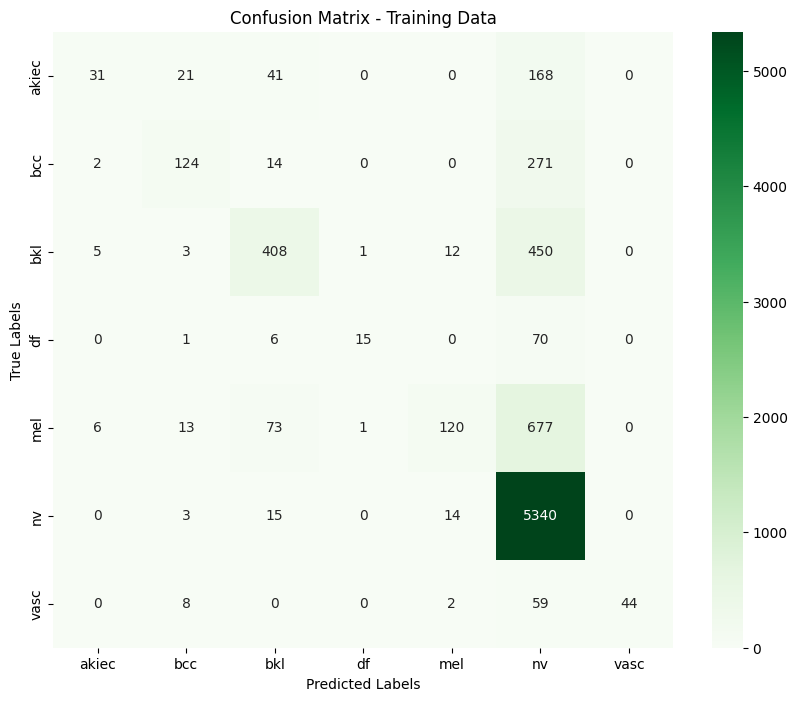

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.70      0.12      0.20       261
         bcc       0.72      0.30      0.42       411
         bkl       0.73      0.46      0.57       879
          df       0.88      0.16      0.28        92
         mel       0.81      0.13      0.23       890
          nv       0.76      0.99      0.86      5372
        vasc       1.00      0.39      0.56       113

    accuracy                           0.76      8018
   macro avg       0.80      0.37      0.45      8018
weighted avg       0.76      0.76      0.70      8018

126/126 [==============================] - 32s 253ms/step


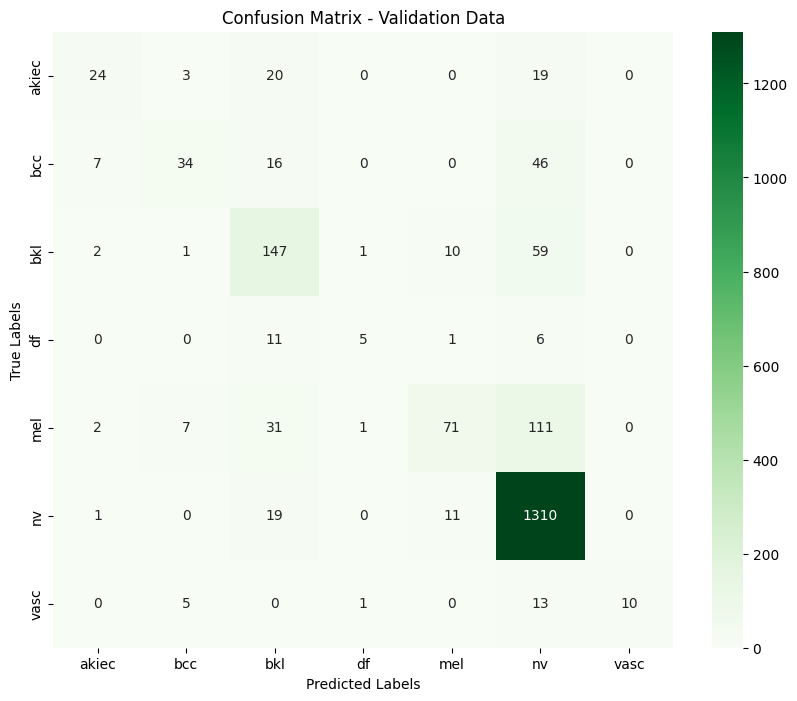

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.67      0.36      0.47        66
         bcc       0.68      0.33      0.44       103
         bkl       0.60      0.67      0.63       220
          df       0.62      0.22      0.32        23
         mel       0.76      0.32      0.45       223
          nv       0.84      0.98      0.90      1341
        vasc       1.00      0.34      0.51        29

    accuracy                           0.80      2005
   macro avg       0.74      0.46      0.53      2005
weighted avg       0.79      0.80      0.77      2005

95/95 [==============================] - 24s 253ms/step


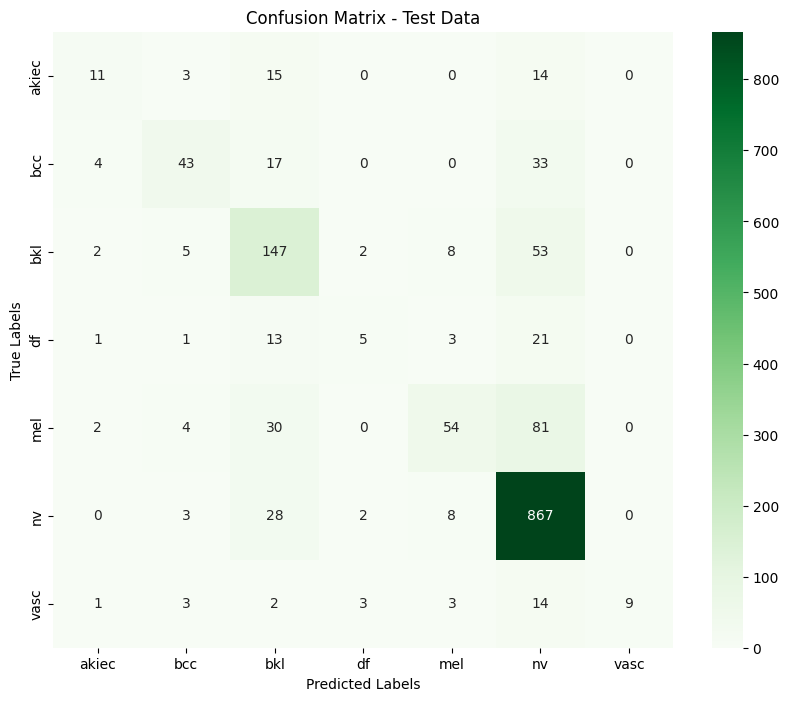

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.52      0.26      0.34        43
         bcc       0.69      0.44      0.54        97
         bkl       0.58      0.68      0.63       217
          df       0.42      0.11      0.18        44
         mel       0.71      0.32      0.44       171
          nv       0.80      0.95      0.87       908
        vasc       1.00      0.26      0.41        35

    accuracy                           0.75      1515
   macro avg       0.68      0.43      0.49      1515
weighted avg       0.74      0.75      0.72      1515



In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldResNet101.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

11111111111111111111111111111111111111

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 650, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 650, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 650, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 325, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 325, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 325, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 162, 112, 128)     0     

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 31s 249ms/step
Val accuracy: 0.6992518703241896
Val Precision: 0.6562612040038911
Val Recall: 0.6992518703241896
Val F1 Score: 0.6662909230024044


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 276ms/step
Test Accuracy: 0.6613861386138614
Test Precision: 0.5869453949599411
Test Recall: 0.6613861386138614
Test F1 Score: 0.6114755606951414


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 221s 440ms/step


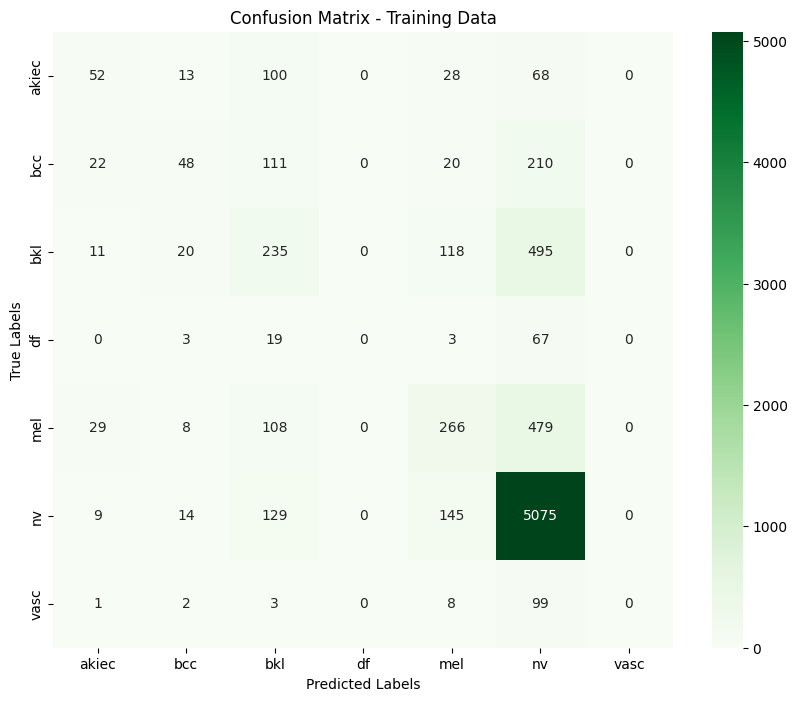

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.42      0.20      0.27       261
         bcc       0.44      0.12      0.18       411
         bkl       0.33      0.27      0.30       879
          df       0.00      0.00      0.00        92
         mel       0.45      0.30      0.36       890
          nv       0.78      0.94      0.86      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.71      8018
   macro avg       0.35      0.26      0.28      8018
weighted avg       0.65      0.71      0.66      8018

126/126 [==============================] - 29s 227ms/step


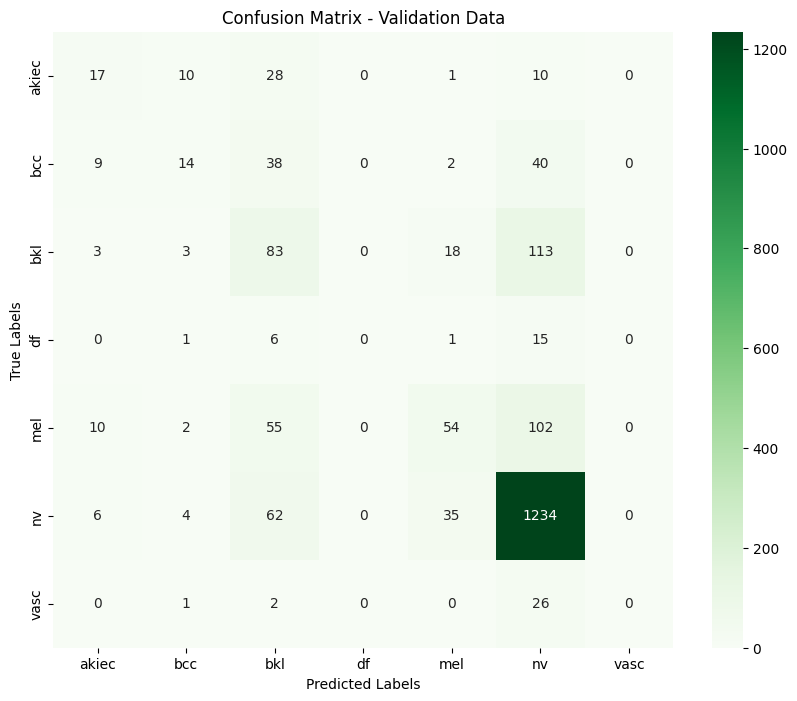

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.38      0.26      0.31        66
         bcc       0.40      0.14      0.20       103
         bkl       0.30      0.38      0.34       220
          df       0.00      0.00      0.00        23
         mel       0.49      0.24      0.32       223
          nv       0.80      0.92      0.86      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.70      2005
   macro avg       0.34      0.28      0.29      2005
weighted avg       0.66      0.70      0.67      2005

95/95 [==============================] - 22s 228ms/step


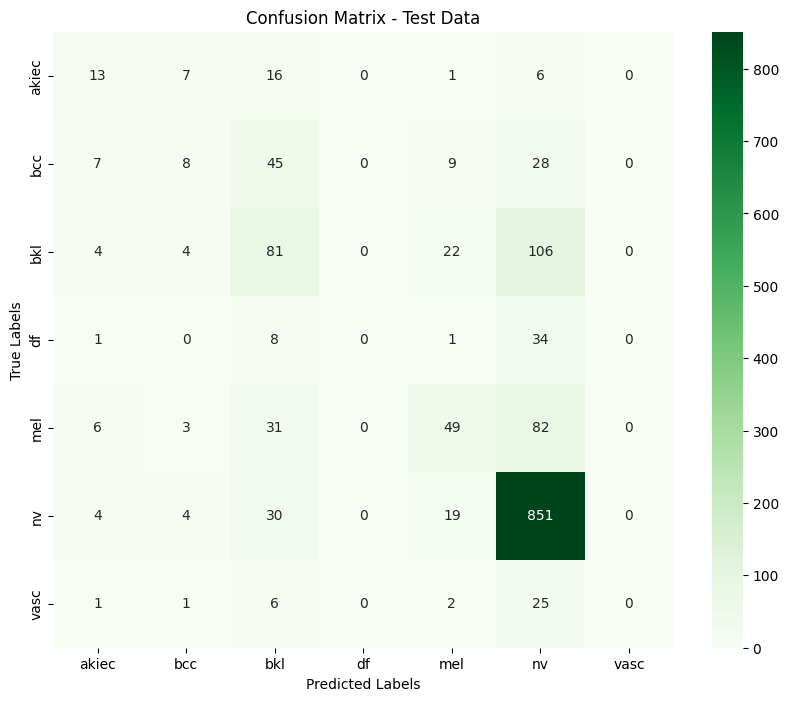

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.36      0.30      0.33        43
         bcc       0.30      0.08      0.13        97
         bkl       0.37      0.37      0.37       217
          df       0.00      0.00      0.00        44
         mel       0.48      0.29      0.36       171
          nv       0.75      0.94      0.83       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.66      1515
   macro avg       0.32      0.28      0.29      1515
weighted avg       0.59      0.66      0.61      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model2\original model\InceptionResnetV2\test resample\without resample\VGG16\withoutresample and regulazation5.h5")

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)


from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 650, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 650, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 650, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 325, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 325, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 325, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 162, 112, 128)     0     

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 33s 261ms/step
Val accuracy: 0.68428927680798
Val Precision: 0.6341700121571163
Val Recall: 0.68428927680798
Val F1 Score: 0.6467886476307698


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 25s 261ms/step
Test Accuracy: 0.6415841584158416
Test Precision: 0.597413652532937
Test Recall: 0.6415841584158416
Test F1 Score: 0.5918254340130237


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 224s 445ms/step


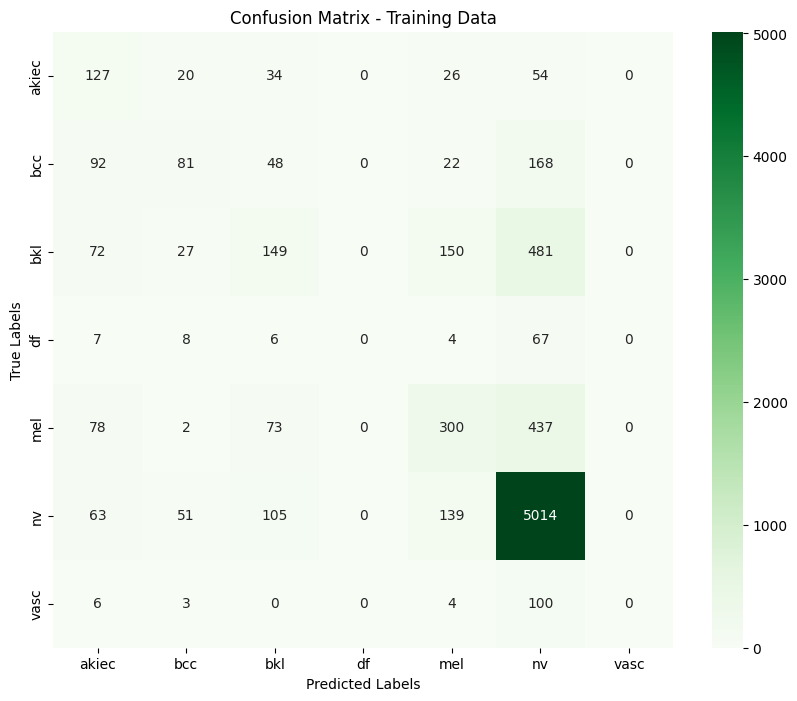

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.29      0.49      0.36       261
         bcc       0.42      0.20      0.27       411
         bkl       0.36      0.17      0.23       879
          df       0.00      0.00      0.00        92
         mel       0.47      0.34      0.39       890
          nv       0.79      0.93      0.86      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.71      8018
   macro avg       0.33      0.30      0.30      8018
weighted avg       0.65      0.71      0.67      8018

126/126 [==============================] - 33s 261ms/step


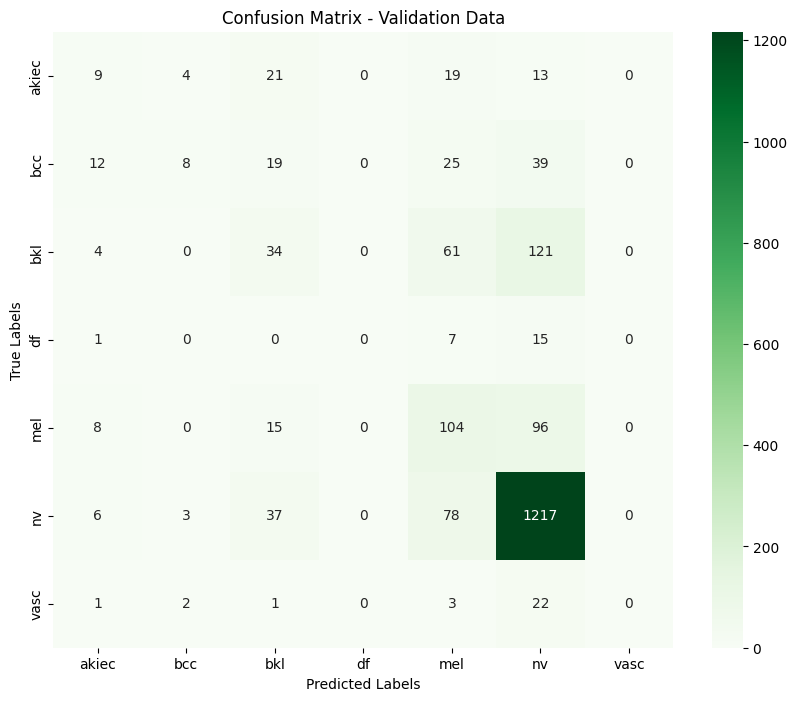

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.22      0.14      0.17        66
         bcc       0.47      0.08      0.13       103
         bkl       0.27      0.15      0.20       220
          df       0.00      0.00      0.00        23
         mel       0.35      0.47      0.40       223
          nv       0.80      0.91      0.85      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.68      2005
   macro avg       0.30      0.25      0.25      2005
weighted avg       0.63      0.68      0.65      2005

95/95 [==============================] - 25s 261ms/step


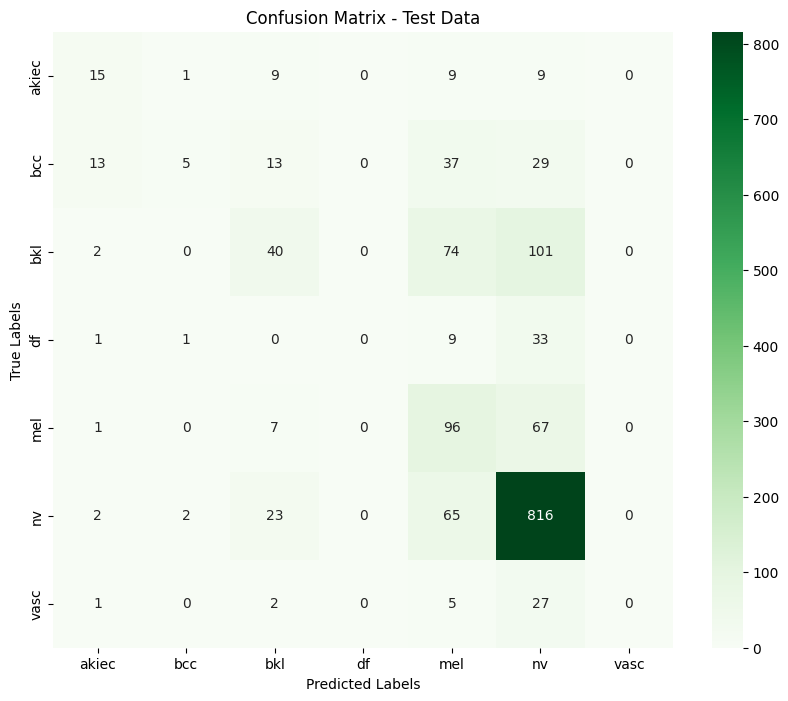

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.43      0.35      0.38        43
         bcc       0.56      0.05      0.09        97
         bkl       0.43      0.18      0.26       217
          df       0.00      0.00      0.00        44
         mel       0.33      0.56      0.41       171
          nv       0.75      0.90      0.82       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.64      1515
   macro avg       0.36      0.29      0.28      1515
weighted avg       0.60      0.64      0.59      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model2\original model\InceptionResnetV2\test resample\without resample\VGG19\withoutresample and regulazation4.h5")

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)


from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 650, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 324, 224, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 324, 224, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

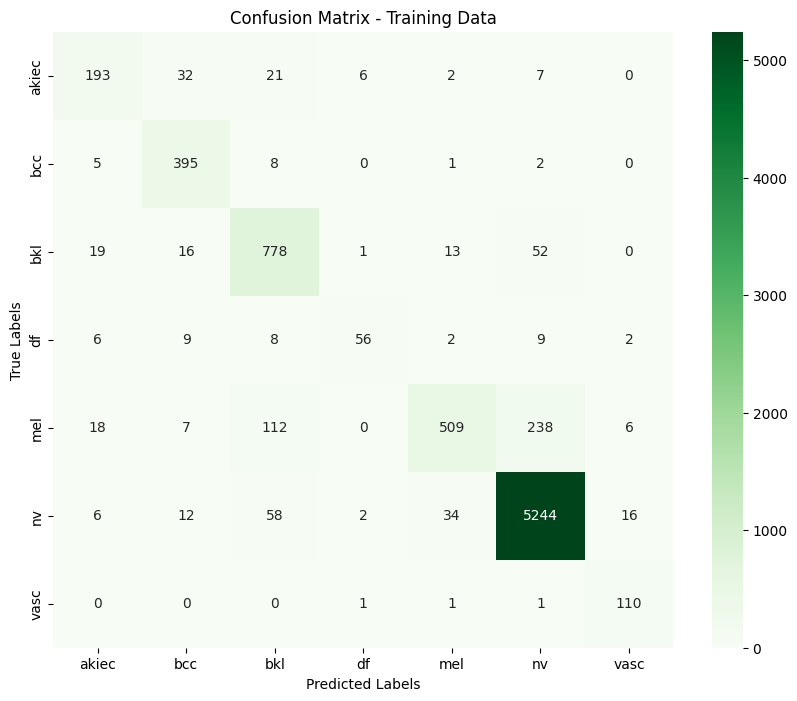

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.78      0.74      0.76       261
         bcc       0.84      0.96      0.90       411
         bkl       0.79      0.89      0.83       879
          df       0.85      0.61      0.71        92
         mel       0.91      0.57      0.70       890
          nv       0.94      0.98      0.96      5372
        vasc       0.82      0.97      0.89       113

    accuracy                           0.91      8018
   macro avg       0.85      0.82      0.82      8018
weighted avg       0.91      0.91      0.90      8018

126/126 [==============================] - 19s 152ms/step


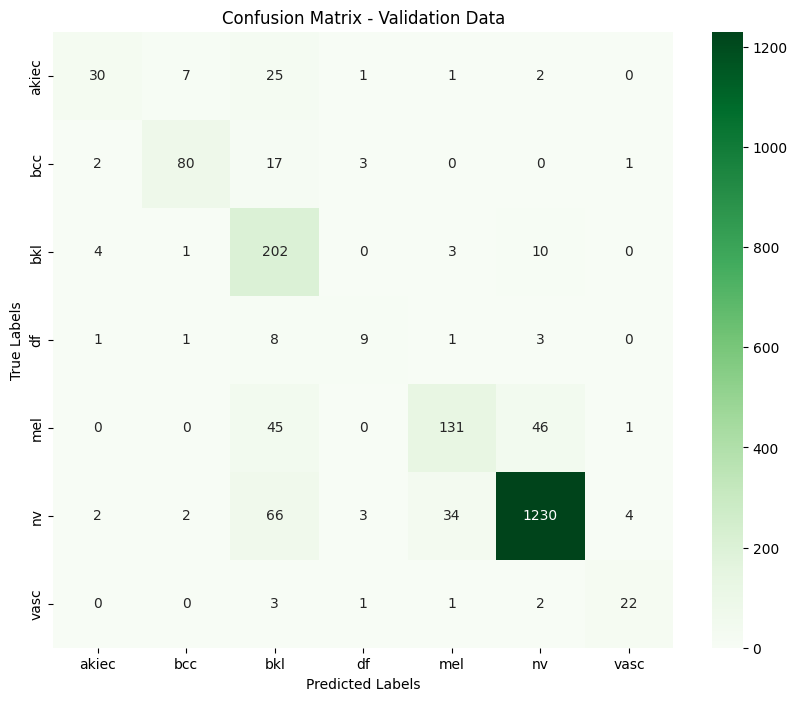

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.77      0.45      0.57        66
         bcc       0.88      0.78      0.82       103
         bkl       0.55      0.92      0.69       220
          df       0.53      0.39      0.45        23
         mel       0.77      0.59      0.66       223
          nv       0.95      0.92      0.93      1341
        vasc       0.79      0.76      0.77        29

    accuracy                           0.85      2005
   macro avg       0.75      0.69      0.70      2005
weighted avg       0.87      0.85      0.85      2005

95/95 [==============================] - 14s 152ms/step


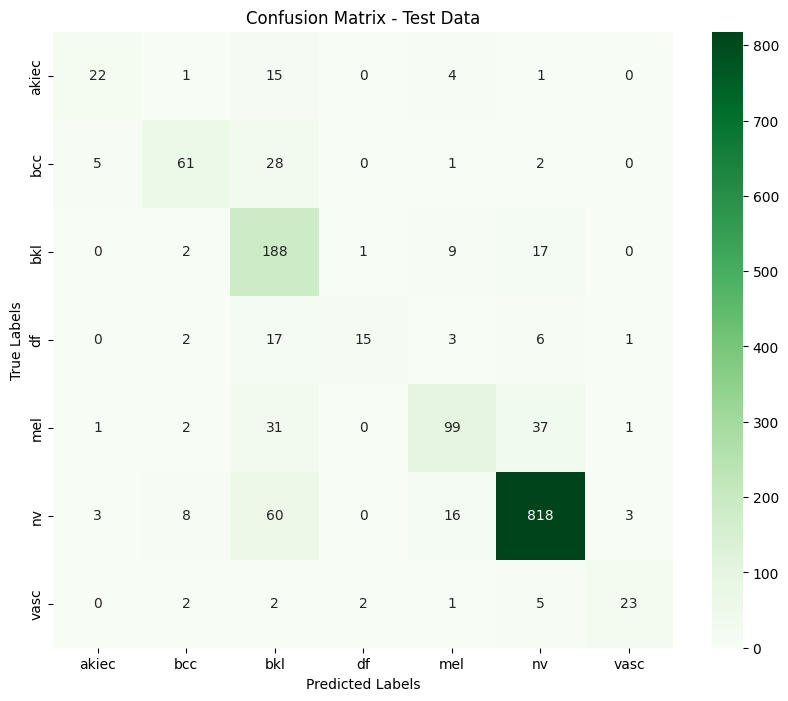

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.71      0.51      0.59        43
         bcc       0.78      0.63      0.70        97
         bkl       0.55      0.87      0.67       217
          df       0.83      0.34      0.48        44
         mel       0.74      0.58      0.65       171
          nv       0.92      0.90      0.91       908
        vasc       0.82      0.66      0.73        35

    accuracy                           0.81      1515
   macro avg       0.77      0.64      0.68      1515
weighted avg       0.83      0.81      0.81      1515



In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model2\original model\InceptionResnetV2\test resample\without resample\Xception\withoutresample and regulazation3.h5")

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)


from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

VGG16

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldVGG16.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 23s 227ms/step
Epoch 1 - Validation Loss: 1.1351, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.13507, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 1.2901 - acc: 0.6631 - val_loss: 1.1351 - val_acc: 0.6696 - lr: 1.0000e-04 - 224s/epoch - 560ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 2 - Validation Loss: 1.1114, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.13507 to 1.11140, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 1.1663 - acc: 0.6703 - val_loss: 1.1114 - val_acc: 0.6696 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 3 - Validation Loss: 1.1071, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.11140 to 1.10708, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.1318 - acc: 0.6701 - val_loss: 1.1071 - val_acc: 0.6696 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 4 - Validation Loss: 1.0507, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.10708 to 1.05071, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 1.0975 - acc: 0.6701 - val_loss: 1.0507 - val_acc: 0.6696 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 5 - Validation Loss: 1.0263, Validation Accuracy: 0.6690, Validation Precision: 0.4488

Epoch 5: val_loss improved from 1.05071 to 1.02632, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0701 - acc: 0.6703 - val_loss: 1.0263 - val_acc: 0.6690 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 6 - Validation Loss: 1.0062, Validation Accuracy: 0.6721, Validation Precision: 0.4914

Epoch 6: val_loss improved from 1.02632 to 1.00619, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 1.0473 - acc: 0.6695 - val_loss: 1.0062 - val_acc: 0.6721 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 7 - Validation Loss: 1.0006, Validation Accuracy: 0.6764, Validation Precision: 0.5060

Epoch 7: val_loss improved from 1.00619 to 1.00058, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0332 - acc: 0.6706 - val_loss: 1.0006 - val_acc: 0.6764 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 8 - Validation Loss: 0.9845, Validation Accuracy: 0.6827, Validation Precision: 0.5171

Epoch 8: val_loss improved from 1.00058 to 0.98451, saving model to 5foldVGG16.h5
401/401 - 228s - loss: 1.0225 - acc: 0.6720 - val_loss: 0.9845 - val_acc: 0.6827 - lr: 1.0000e-04 - 228s/epoch - 568ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 9 - Validation Loss: 0.9910, Validation Accuracy: 0.6752, Validation Precision: 0.5264

Epoch 9: val_loss did not improve from 0.98451
401/401 - 226s - loss: 1.0151 - acc: 0.6720 - val_loss: 0.9910 - val_acc: 0.6752 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 10 - Validation Loss: 0.9709, Validation Accuracy: 0.6708, Validation Precision: 0.5316

Epoch 10: val_loss improved from 0.98451 to 0.97091, saving model to 5foldVGG16.h5
401/401 - 229s - loss: 1.0031 - acc: 0.6707 - val_loss: 0.9709 - val_acc: 0.6708 - lr: 1.0000e-04 - 229s/epoch - 571ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 11 - Validation Loss: 0.9718, Validation Accuracy: 0.6708, Validation Precision: 0.5323

Epoch 11: val_loss did not improve from 0.97091
401/401 - 229s - loss: 1.0043 - acc: 0.6731 - val_loss: 0.9718 - val_acc: 0.6708 - lr: 1.0000e-04 - 229s/epoch - 570ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 12 - Validation Loss: 0.9669, Validation Accuracy: 0.6702, Validation Precision: 0.5339

Epoch 12: val_loss improved from 0.97091 to 0.96692, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9947 - acc: 0.6712 - val_loss: 0.9669 - val_acc: 0.6702 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 13 - Validation Loss: 0.9582, Validation Accuracy: 0.6714, Validation Precision: 0.5411

Epoch 13: val_loss improved from 0.96692 to 0.95815, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9935 - acc: 0.6718 - val_loss: 0.9582 - val_acc: 0.6714 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 14 - Validation Loss: 0.9507, Validation Accuracy: 0.6764, Validation Precision: 0.5334

Epoch 14: val_loss improved from 0.95815 to 0.95069, saving model to 5foldVGG16.h5
401/401 - 228s - loss: 0.9931 - acc: 0.6717 - val_loss: 0.9507 - val_acc: 0.6764 - lr: 1.0000e-04 - 228s/epoch - 567ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 15 - Validation Loss: 0.9431, Validation Accuracy: 0.6733, Validation Precision: 0.5409

Epoch 15: val_loss improved from 0.95069 to 0.94305, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9780 - acc: 0.6745 - val_loss: 0.9431 - val_acc: 0.6733 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 16 - Validation Loss: 0.9486, Validation Accuracy: 0.6708, Validation Precision: 0.5500

Epoch 16: val_loss did not improve from 0.94305
401/401 - 227s - loss: 0.9788 - acc: 0.6712 - val_loss: 0.9486 - val_acc: 0.6708 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 17 - Validation Loss: 0.9382, Validation Accuracy: 0.6758, Validation Precision: 0.5401

Epoch 17: val_loss improved from 0.94305 to 0.93816, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9761 - acc: 0.6742 - val_loss: 0.9382 - val_acc: 0.6758 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 18 - Validation Loss: 0.9305, Validation Accuracy: 0.6827, Validation Precision: 0.5206

Epoch 18: val_loss improved from 0.93816 to 0.93054, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9752 - acc: 0.6738 - val_loss: 0.9305 - val_acc: 0.6827 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 19 - Validation Loss: 0.9292, Validation Accuracy: 0.6739, Validation Precision: 0.5330

Epoch 19: val_loss improved from 0.93054 to 0.92919, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9689 - acc: 0.6759 - val_loss: 0.9292 - val_acc: 0.6739 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 20 - Validation Loss: 0.9363, Validation Accuracy: 0.6721, Validation Precision: 0.5506

Epoch 20: val_loss did not improve from 0.92919
401/401 - 224s - loss: 0.9682 - acc: 0.6765 - val_loss: 0.9363 - val_acc: 0.6721 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 21 - Validation Loss: 0.9346, Validation Accuracy: 0.6814, Validation Precision: 0.6322

Epoch 21: val_loss did not improve from 0.92919
401/401 - 225s - loss: 0.9657 - acc: 0.6723 - val_loss: 0.9346 - val_acc: 0.6814 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 22 - Validation Loss: 0.9210, Validation Accuracy: 0.6789, Validation Precision: 0.5380

Epoch 22: val_loss improved from 0.92919 to 0.92101, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9601 - acc: 0.6745 - val_loss: 0.9210 - val_acc: 0.6789 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 23 - Validation Loss: 0.9198, Validation Accuracy: 0.6764, Validation Precision: 0.5415

Epoch 23: val_loss improved from 0.92101 to 0.91978, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9566 - acc: 0.6732 - val_loss: 0.9198 - val_acc: 0.6764 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 24 - Validation Loss: 0.9190, Validation Accuracy: 0.6796, Validation Precision: 0.6077

Epoch 24: val_loss improved from 0.91978 to 0.91900, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9545 - acc: 0.6773 - val_loss: 0.9190 - val_acc: 0.6796 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 25 - Validation Loss: 0.9171, Validation Accuracy: 0.6752, Validation Precision: 0.5432

Epoch 25: val_loss improved from 0.91900 to 0.91712, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9563 - acc: 0.6762 - val_loss: 0.9171 - val_acc: 0.6752 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 26 - Validation Loss: 0.9116, Validation Accuracy: 0.6752, Validation Precision: 0.5321

Epoch 26: val_loss improved from 0.91712 to 0.91162, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9537 - acc: 0.6734 - val_loss: 0.9116 - val_acc: 0.6752 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 27 - Validation Loss: 0.9089, Validation Accuracy: 0.6827, Validation Precision: 0.5250

Epoch 27: val_loss improved from 0.91162 to 0.90893, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9481 - acc: 0.6777 - val_loss: 0.9089 - val_acc: 0.6827 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 28 - Validation Loss: 0.9124, Validation Accuracy: 0.6758, Validation Precision: 0.5420

Epoch 28: val_loss did not improve from 0.90893
401/401 - 226s - loss: 0.9511 - acc: 0.6777 - val_loss: 0.9124 - val_acc: 0.6758 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 29 - Validation Loss: 0.9066, Validation Accuracy: 0.6783, Validation Precision: 0.6037

Epoch 29: val_loss improved from 0.90893 to 0.90656, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9454 - acc: 0.6788 - val_loss: 0.9066 - val_acc: 0.6783 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 30 - Validation Loss: 0.9050, Validation Accuracy: 0.6845, Validation Precision: 0.5209

Epoch 30: val_loss improved from 0.90656 to 0.90501, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9425 - acc: 0.6791 - val_loss: 0.9050 - val_acc: 0.6845 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 31 - Validation Loss: 0.9007, Validation Accuracy: 0.6845, Validation Precision: 0.5800

Epoch 31: val_loss improved from 0.90501 to 0.90068, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9382 - acc: 0.6784 - val_loss: 0.9007 - val_acc: 0.6845 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 32 - Validation Loss: 0.9059, Validation Accuracy: 0.6808, Validation Precision: 0.5821

Epoch 32: val_loss did not improve from 0.90068
401/401 - 226s - loss: 0.9357 - acc: 0.6813 - val_loss: 0.9059 - val_acc: 0.6808 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 33 - Validation Loss: 0.9026, Validation Accuracy: 0.6783, Validation Precision: 0.5905

Epoch 33: val_loss did not improve from 0.90068
401/401 - 224s - loss: 0.9381 - acc: 0.6801 - val_loss: 0.9026 - val_acc: 0.6783 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 34 - Validation Loss: 0.8974, Validation Accuracy: 0.6802, Validation Precision: 0.5717

Epoch 34: val_loss improved from 0.90068 to 0.89745, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9356 - acc: 0.6791 - val_loss: 0.8974 - val_acc: 0.6802 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 35 - Validation Loss: 0.8922, Validation Accuracy: 0.6889, Validation Precision: 0.5731

Epoch 35: val_loss improved from 0.89745 to 0.89217, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9333 - acc: 0.6812 - val_loss: 0.8922 - val_acc: 0.6889 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 36 - Validation Loss: 0.8878, Validation Accuracy: 0.6845, Validation Precision: 0.5743

Epoch 36: val_loss improved from 0.89217 to 0.88780, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9280 - acc: 0.6796 - val_loss: 0.8878 - val_acc: 0.6845 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 37 - Validation Loss: 0.8855, Validation Accuracy: 0.6889, Validation Precision: 0.5830

Epoch 37: val_loss improved from 0.88780 to 0.88548, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9243 - acc: 0.6833 - val_loss: 0.8855 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 38 - Validation Loss: 0.8827, Validation Accuracy: 0.6839, Validation Precision: 0.5760

Epoch 38: val_loss improved from 0.88548 to 0.88270, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9262 - acc: 0.6812 - val_loss: 0.8827 - val_acc: 0.6839 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 39 - Validation Loss: 0.8830, Validation Accuracy: 0.6845, Validation Precision: 0.5797

Epoch 39: val_loss did not improve from 0.88270
401/401 - 225s - loss: 0.9245 - acc: 0.6826 - val_loss: 0.8830 - val_acc: 0.6845 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 40 - Validation Loss: 0.8867, Validation Accuracy: 0.6870, Validation Precision: 0.5696

Epoch 40: val_loss did not improve from 0.88270
401/401 - 224s - loss: 0.9252 - acc: 0.6821 - val_loss: 0.8867 - val_acc: 0.6870 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 41 - Validation Loss: 0.8797, Validation Accuracy: 0.6889, Validation Precision: 0.5750

Epoch 41: val_loss improved from 0.88270 to 0.87972, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9187 - acc: 0.6838 - val_loss: 0.8797 - val_acc: 0.6889 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 42 - Validation Loss: 0.8742, Validation Accuracy: 0.6895, Validation Precision: 0.5848

Epoch 42: val_loss improved from 0.87972 to 0.87421, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9148 - acc: 0.6872 - val_loss: 0.8742 - val_acc: 0.6895 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 43 - Validation Loss: 0.8774, Validation Accuracy: 0.6852, Validation Precision: 0.5685

Epoch 43: val_loss did not improve from 0.87421
401/401 - 226s - loss: 0.9188 - acc: 0.6813 - val_loss: 0.8774 - val_acc: 0.6852 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 44 - Validation Loss: 0.8772, Validation Accuracy: 0.6858, Validation Precision: 0.5759

Epoch 44: val_loss did not improve from 0.87421
401/401 - 224s - loss: 0.9164 - acc: 0.6830 - val_loss: 0.8772 - val_acc: 0.6858 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 45 - Validation Loss: 0.8723, Validation Accuracy: 0.6889, Validation Precision: 0.5810

Epoch 45: val_loss improved from 0.87421 to 0.87234, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9029 - acc: 0.6868 - val_loss: 0.8723 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 46 - Validation Loss: 0.8646, Validation Accuracy: 0.6908, Validation Precision: 0.5837

Epoch 46: val_loss improved from 0.87234 to 0.86465, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9067 - acc: 0.6837 - val_loss: 0.8646 - val_acc: 0.6908 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 47 - Validation Loss: 0.8708, Validation Accuracy: 0.6914, Validation Precision: 0.6038

Epoch 47: val_loss did not improve from 0.86465
401/401 - 225s - loss: 0.9067 - acc: 0.6827 - val_loss: 0.8708 - val_acc: 0.6914 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 48 - Validation Loss: 0.8622, Validation Accuracy: 0.6889, Validation Precision: 0.5841

Epoch 48: val_loss improved from 0.86465 to 0.86220, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9058 - acc: 0.6893 - val_loss: 0.8622 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 49 - Validation Loss: 0.8624, Validation Accuracy: 0.6858, Validation Precision: 0.5807

Epoch 49: val_loss did not improve from 0.86220
401/401 - 224s - loss: 0.9010 - acc: 0.6843 - val_loss: 0.8624 - val_acc: 0.6858 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 50 - Validation Loss: 0.8619, Validation Accuracy: 0.6895, Validation Precision: 0.5892

Epoch 50: val_loss improved from 0.86220 to 0.86187, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9001 - acc: 0.6848 - val_loss: 0.8619 - val_acc: 0.6895 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 51 - Validation Loss: 0.8752, Validation Accuracy: 0.6883, Validation Precision: 0.6119

Epoch 51: val_loss did not improve from 0.86187
401/401 - 223s - loss: 0.8999 - acc: 0.6866 - val_loss: 0.8752 - val_acc: 0.6883 - lr: 1.0000e-04 - 223s/epoch - 557ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 52 - Validation Loss: 0.8546, Validation Accuracy: 0.6895, Validation Precision: 0.5813

Epoch 52: val_loss improved from 0.86187 to 0.85464, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.8964 - acc: 0.6894 - val_loss: 0.8546 - val_acc: 0.6895 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 53 - Validation Loss: 0.8614, Validation Accuracy: 0.6870, Validation Precision: 0.5883

Epoch 53: val_loss did not improve from 0.85464
401/401 - 226s - loss: 0.8959 - acc: 0.6866 - val_loss: 0.8614 - val_acc: 0.6870 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 54 - Validation Loss: 0.8497, Validation Accuracy: 0.6908, Validation Precision: 0.5831

Epoch 54: val_loss improved from 0.85464 to 0.84969, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8914 - acc: 0.6932 - val_loss: 0.8497 - val_acc: 0.6908 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 55 - Validation Loss: 0.8501, Validation Accuracy: 0.6914, Validation Precision: 0.5905

Epoch 55: val_loss did not improve from 0.84969
401/401 - 225s - loss: 0.8928 - acc: 0.6896 - val_loss: 0.8501 - val_acc: 0.6914 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 56 - Validation Loss: 0.8502, Validation Accuracy: 0.6877, Validation Precision: 0.5795

Epoch 56: val_loss did not improve from 0.84969
401/401 - 226s - loss: 0.8857 - acc: 0.6862 - val_loss: 0.8502 - val_acc: 0.6877 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 57 - Validation Loss: 0.8439, Validation Accuracy: 0.6883, Validation Precision: 0.5793

Epoch 57: val_loss improved from 0.84969 to 0.84395, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8917 - acc: 0.6841 - val_loss: 0.8439 - val_acc: 0.6883 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 58 - Validation Loss: 0.8463, Validation Accuracy: 0.6908, Validation Precision: 0.5946

Epoch 58: val_loss did not improve from 0.84395
401/401 - 226s - loss: 0.8869 - acc: 0.6911 - val_loss: 0.8463 - val_acc: 0.6908 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 59 - Validation Loss: 0.8402, Validation Accuracy: 0.6908, Validation Precision: 0.5919

Epoch 59: val_loss improved from 0.84395 to 0.84024, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8827 - acc: 0.6857 - val_loss: 0.8402 - val_acc: 0.6908 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 60 - Validation Loss: 0.8408, Validation Accuracy: 0.6914, Validation Precision: 0.5847

Epoch 60: val_loss did not improve from 0.84024
401/401 - 226s - loss: 0.8876 - acc: 0.6863 - val_loss: 0.8408 - val_acc: 0.6914 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 61 - Validation Loss: 0.8430, Validation Accuracy: 0.6889, Validation Precision: 0.5879

Epoch 61: val_loss did not improve from 0.84024
401/401 - 226s - loss: 0.8834 - acc: 0.6849 - val_loss: 0.8430 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 62 - Validation Loss: 0.8453, Validation Accuracy: 0.6895, Validation Precision: 0.5836

Epoch 62: val_loss did not improve from 0.84024
401/401 - 226s - loss: 0.8911 - acc: 0.6872 - val_loss: 0.8453 - val_acc: 0.6895 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 63 - Validation Loss: 0.8432, Validation Accuracy: 0.6864, Validation Precision: 0.5852

Epoch 63: val_loss did not improve from 0.84024
401/401 - 225s - loss: 0.8822 - acc: 0.6854 - val_loss: 0.8432 - val_acc: 0.6864 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 64 - Validation Loss: 0.8397, Validation Accuracy: 0.6889, Validation Precision: 0.5861

Epoch 64: val_loss improved from 0.84024 to 0.83969, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8812 - acc: 0.6849 - val_loss: 0.8397 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 562ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 65 - Validation Loss: 0.8372, Validation Accuracy: 0.6883, Validation Precision: 0.5968

Epoch 65: val_loss improved from 0.83969 to 0.83718, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8741 - acc: 0.6843 - val_loss: 0.8372 - val_acc: 0.6883 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 66 - Validation Loss: 0.8373, Validation Accuracy: 0.6920, Validation Precision: 0.6073

Epoch 66: val_loss did not improve from 0.83718
401/401 - 224s - loss: 0.8729 - acc: 0.6925 - val_loss: 0.8373 - val_acc: 0.6920 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 67 - Validation Loss: 0.8364, Validation Accuracy: 0.6926, Validation Precision: 0.6082

Epoch 67: val_loss improved from 0.83718 to 0.83638, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8764 - acc: 0.6904 - val_loss: 0.8364 - val_acc: 0.6926 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 68 - Validation Loss: 0.8356, Validation Accuracy: 0.6889, Validation Precision: 0.5949

Epoch 68: val_loss improved from 0.83638 to 0.83556, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8666 - acc: 0.6929 - val_loss: 0.8356 - val_acc: 0.6889 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 69 - Validation Loss: 0.8346, Validation Accuracy: 0.6889, Validation Precision: 0.5918

Epoch 69: val_loss improved from 0.83556 to 0.83464, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8624 - acc: 0.6915 - val_loss: 0.8346 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 70 - Validation Loss: 0.8366, Validation Accuracy: 0.6889, Validation Precision: 0.6037

Epoch 70: val_loss did not improve from 0.83464
401/401 - 226s - loss: 0.8662 - acc: 0.6905 - val_loss: 0.8366 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 71 - Validation Loss: 0.8268, Validation Accuracy: 0.6901, Validation Precision: 0.5978

Epoch 71: val_loss improved from 0.83464 to 0.82682, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8692 - acc: 0.6927 - val_loss: 0.8268 - val_acc: 0.6901 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 72 - Validation Loss: 0.8369, Validation Accuracy: 0.6958, Validation Precision: 0.6159

Epoch 72: val_loss did not improve from 0.82682
401/401 - 225s - loss: 0.8614 - acc: 0.6911 - val_loss: 0.8369 - val_acc: 0.6958 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 73 - Validation Loss: 0.8331, Validation Accuracy: 0.6939, Validation Precision: 0.6201

Epoch 73: val_loss did not improve from 0.82682
401/401 - 224s - loss: 0.8722 - acc: 0.6910 - val_loss: 0.8331 - val_acc: 0.6939 - lr: 1.0000e-04 - 224s/epoch - 560ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 74 - Validation Loss: 0.8305, Validation Accuracy: 0.6914, Validation Precision: 0.6290

Epoch 74: val_loss did not improve from 0.82682
401/401 - 226s - loss: 0.8700 - acc: 0.6880 - val_loss: 0.8305 - val_acc: 0.6914 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 75 - Validation Loss: 0.8286, Validation Accuracy: 0.6926, Validation Precision: 0.6250

Epoch 75: val_loss did not improve from 0.82682
401/401 - 226s - loss: 0.8654 - acc: 0.6896 - val_loss: 0.8286 - val_acc: 0.6926 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 76 - Validation Loss: 0.8225, Validation Accuracy: 0.6926, Validation Precision: 0.6153

Epoch 76: val_loss improved from 0.82682 to 0.82251, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.8632 - acc: 0.6871 - val_loss: 0.8225 - val_acc: 0.6926 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 77 - Validation Loss: 0.8215, Validation Accuracy: 0.6945, Validation Precision: 0.6187

Epoch 77: val_loss improved from 0.82251 to 0.82155, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8631 - acc: 0.6921 - val_loss: 0.8215 - val_acc: 0.6945 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 78 - Validation Loss: 0.8254, Validation Accuracy: 0.6939, Validation Precision: 0.6082

Epoch 78: val_loss did not improve from 0.82155
401/401 - 225s - loss: 0.8619 - acc: 0.6930 - val_loss: 0.8254 - val_acc: 0.6939 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 79 - Validation Loss: 0.8236, Validation Accuracy: 0.6933, Validation Precision: 0.6025

Epoch 79: val_loss did not improve from 0.82155
401/401 - 226s - loss: 0.8605 - acc: 0.6901 - val_loss: 0.8236 - val_acc: 0.6933 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 80 - Validation Loss: 0.8210, Validation Accuracy: 0.6939, Validation Precision: 0.6134

Epoch 80: val_loss improved from 0.82155 to 0.82097, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8574 - acc: 0.6835 - val_loss: 0.8210 - val_acc: 0.6939 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 81 - Validation Loss: 0.8208, Validation Accuracy: 0.6933, Validation Precision: 0.6183

Epoch 81: val_loss improved from 0.82097 to 0.82079, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.8652 - acc: 0.6888 - val_loss: 0.8208 - val_acc: 0.6933 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 82 - Validation Loss: 0.8239, Validation Accuracy: 0.6933, Validation Precision: 0.6137

Epoch 82: val_loss did not improve from 0.82079
401/401 - 225s - loss: 0.8632 - acc: 0.6897 - val_loss: 0.8239 - val_acc: 0.6933 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 83 - Validation Loss: 0.8203, Validation Accuracy: 0.6933, Validation Precision: 0.6185

Epoch 83: val_loss improved from 0.82079 to 0.82028, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.8573 - acc: 0.6916 - val_loss: 0.8203 - val_acc: 0.6933 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 84 - Validation Loss: 0.8213, Validation Accuracy: 0.6964, Validation Precision: 0.6194

Epoch 84: val_loss did not improve from 0.82028
401/401 - 227s - loss: 0.8529 - acc: 0.6954 - val_loss: 0.8213 - val_acc: 0.6964 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 85 - Validation Loss: 0.8251, Validation Accuracy: 0.6964, Validation Precision: 0.6150

Epoch 85: val_loss did not improve from 0.82028
401/401 - 226s - loss: 0.8574 - acc: 0.6958 - val_loss: 0.8251 - val_acc: 0.6964 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 86/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 86 - Validation Loss: 0.8266, Validation Accuracy: 0.6951, Validation Precision: 0.6410

Epoch 86: val_loss did not improve from 0.82028
401/401 - 226s - loss: 0.8480 - acc: 0.6974 - val_loss: 0.8266 - val_acc: 0.6951 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 87 - Validation Loss: 0.8148, Validation Accuracy: 0.6914, Validation Precision: 0.6174

Epoch 87: val_loss improved from 0.82028 to 0.81480, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.8570 - acc: 0.6932 - val_loss: 0.8148 - val_acc: 0.6914 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 88/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 88 - Validation Loss: 0.8152, Validation Accuracy: 0.6964, Validation Precision: 0.6399

Epoch 88: val_loss did not improve from 0.81480
401/401 - 226s - loss: 0.8530 - acc: 0.6930 - val_loss: 0.8152 - val_acc: 0.6964 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 89 - Validation Loss: 0.8244, Validation Accuracy: 0.6939, Validation Precision: 0.6176

Epoch 89: val_loss did not improve from 0.81480
401/401 - 227s - loss: 0.8519 - acc: 0.6925 - val_loss: 0.8244 - val_acc: 0.6939 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 90/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 90 - Validation Loss: 0.8141, Validation Accuracy: 0.6945, Validation Precision: 0.6300

Epoch 90: val_loss improved from 0.81480 to 0.81405, saving model to 5foldVGG16.h5
401/401 - 229s - loss: 0.8536 - acc: 0.6935 - val_loss: 0.8141 - val_acc: 0.6945 - lr: 1.0000e-04 - 229s/epoch - 571ms/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 91 - Validation Loss: 0.8422, Validation Accuracy: 0.6901, Validation Precision: 0.6314

Epoch 91: val_loss did not improve from 0.81405
401/401 - 226s - loss: 0.8489 - acc: 0.6911 - val_loss: 0.8422 - val_acc: 0.6901 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 92 - Validation Loss: 0.8138, Validation Accuracy: 0.6945, Validation Precision: 0.6300

Epoch 92: val_loss improved from 0.81405 to 0.81376, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.8503 - acc: 0.6943 - val_loss: 0.8138 - val_acc: 0.6945 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 93 - Validation Loss: 0.8099, Validation Accuracy: 0.6945, Validation Precision: 0.6267

Epoch 93: val_loss improved from 0.81376 to 0.80993, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.8509 - acc: 0.6941 - val_loss: 0.8099 - val_acc: 0.6945 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 94 - Validation Loss: 0.8102, Validation Accuracy: 0.6933, Validation Precision: 0.6185

Epoch 94: val_loss did not improve from 0.80993
401/401 - 226s - loss: 0.8406 - acc: 0.6950 - val_loss: 0.8102 - val_acc: 0.6933 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 95/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 95 - Validation Loss: 0.8108, Validation Accuracy: 0.6933, Validation Precision: 0.6312

Epoch 95: val_loss did not improve from 0.80993
401/401 - 225s - loss: 0.8388 - acc: 0.6964 - val_loss: 0.8108 - val_acc: 0.6933 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 96 - Validation Loss: 0.8187, Validation Accuracy: 0.6951, Validation Precision: 0.6187

Epoch 96: val_loss did not improve from 0.80993
401/401 - 226s - loss: 0.8548 - acc: 0.6929 - val_loss: 0.8187 - val_acc: 0.6951 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 97 - Validation Loss: 0.8181, Validation Accuracy: 0.6945, Validation Precision: 0.6216

Epoch 97: val_loss did not improve from 0.80993
401/401 - 226s - loss: 0.8472 - acc: 0.6941 - val_loss: 0.8181 - val_acc: 0.6945 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 98/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 98 - Validation Loss: 0.8123, Validation Accuracy: 0.6933, Validation Precision: 0.6267

Epoch 98: val_loss did not improve from 0.80993
401/401 - 227s - loss: 0.8411 - acc: 0.6960 - val_loss: 0.8123 - val_acc: 0.6933 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 23s 227ms/step
Epoch 1 - Validation Loss: 1.1252, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.12516, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 1.3989 - acc: 0.5876 - val_loss: 1.1252 - val_acc: 0.6696 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 2 - Validation Loss: 1.1033, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.12516 to 1.10332, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 1.1670 - acc: 0.6698 - val_loss: 1.1033 - val_acc: 0.6696 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 3 - Validation Loss: 1.0814, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.10332 to 1.08141, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 1.1407 - acc: 0.6701 - val_loss: 1.0814 - val_acc: 0.6696 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 4 - Validation Loss: 1.0595, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.08141 to 1.05947, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.1146 - acc: 0.6701 - val_loss: 1.0595 - val_acc: 0.6696 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 5 - Validation Loss: 1.0353, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.05947 to 1.03531, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 1.0946 - acc: 0.6703 - val_loss: 1.0353 - val_acc: 0.6696 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 6 - Validation Loss: 1.0087, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 1.03531 to 1.00865, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0620 - acc: 0.6704 - val_loss: 1.0087 - val_acc: 0.6696 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 7 - Validation Loss: 0.9906, Validation Accuracy: 0.6714, Validation Precision: 0.4922

Epoch 7: val_loss improved from 1.00865 to 0.99063, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0425 - acc: 0.6703 - val_loss: 0.9906 - val_acc: 0.6714 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 8 - Validation Loss: 0.9782, Validation Accuracy: 0.6696, Validation Precision: 0.4486

Epoch 8: val_loss improved from 0.99063 to 0.97821, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 1.0312 - acc: 0.6715 - val_loss: 0.9782 - val_acc: 0.6696 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 9 - Validation Loss: 0.9773, Validation Accuracy: 0.6796, Validation Precision: 0.5090

Epoch 9: val_loss improved from 0.97821 to 0.97732, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0128 - acc: 0.6709 - val_loss: 0.9773 - val_acc: 0.6796 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 10 - Validation Loss: 0.9633, Validation Accuracy: 0.6739, Validation Precision: 0.5110

Epoch 10: val_loss improved from 0.97732 to 0.96334, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.0130 - acc: 0.6712 - val_loss: 0.9633 - val_acc: 0.6739 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 11 - Validation Loss: 0.9582, Validation Accuracy: 0.6820, Validation Precision: 0.5134

Epoch 11: val_loss improved from 0.96334 to 0.95815, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 1.0008 - acc: 0.6704 - val_loss: 0.9582 - val_acc: 0.6820 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 12 - Validation Loss: 0.9591, Validation Accuracy: 0.6796, Validation Precision: 0.5129

Epoch 12: val_loss did not improve from 0.95815
401/401 - 226s - loss: 0.9997 - acc: 0.6704 - val_loss: 0.9591 - val_acc: 0.6796 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 13 - Validation Loss: 0.9484, Validation Accuracy: 0.6845, Validation Precision: 0.5136

Epoch 13: val_loss improved from 0.95815 to 0.94835, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9893 - acc: 0.6710 - val_loss: 0.9484 - val_acc: 0.6845 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 14 - Validation Loss: 0.9456, Validation Accuracy: 0.6808, Validation Precision: 0.5220

Epoch 14: val_loss improved from 0.94835 to 0.94564, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9890 - acc: 0.6712 - val_loss: 0.9456 - val_acc: 0.6808 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 15 - Validation Loss: 0.9374, Validation Accuracy: 0.6833, Validation Precision: 0.5234

Epoch 15: val_loss improved from 0.94564 to 0.93745, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9823 - acc: 0.6746 - val_loss: 0.9374 - val_acc: 0.6833 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 16 - Validation Loss: 0.9350, Validation Accuracy: 0.6802, Validation Precision: 0.5269

Epoch 16: val_loss improved from 0.93745 to 0.93498, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9811 - acc: 0.6734 - val_loss: 0.9350 - val_acc: 0.6802 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 17 - Validation Loss: 0.9294, Validation Accuracy: 0.6858, Validation Precision: 0.5176

Epoch 17: val_loss improved from 0.93498 to 0.92942, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9754 - acc: 0.6713 - val_loss: 0.9294 - val_acc: 0.6858 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 18 - Validation Loss: 0.9273, Validation Accuracy: 0.6820, Validation Precision: 0.5187

Epoch 18: val_loss improved from 0.92942 to 0.92729, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9760 - acc: 0.6712 - val_loss: 0.9273 - val_acc: 0.6820 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 19 - Validation Loss: 0.9253, Validation Accuracy: 0.6864, Validation Precision: 0.5189

Epoch 19: val_loss improved from 0.92729 to 0.92528, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9707 - acc: 0.6699 - val_loss: 0.9253 - val_acc: 0.6864 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 20 - Validation Loss: 0.9210, Validation Accuracy: 0.6789, Validation Precision: 0.5168

Epoch 20: val_loss improved from 0.92528 to 0.92097, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9664 - acc: 0.6740 - val_loss: 0.9210 - val_acc: 0.6789 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 21 - Validation Loss: 0.9226, Validation Accuracy: 0.6796, Validation Precision: 0.5297

Epoch 21: val_loss did not improve from 0.92097
401/401 - 227s - loss: 0.9618 - acc: 0.6734 - val_loss: 0.9226 - val_acc: 0.6796 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 22 - Validation Loss: 0.9192, Validation Accuracy: 0.6833, Validation Precision: 0.5239

Epoch 22: val_loss improved from 0.92097 to 0.91919, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9662 - acc: 0.6745 - val_loss: 0.9192 - val_acc: 0.6833 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 23 - Validation Loss: 0.9129, Validation Accuracy: 0.6808, Validation Precision: 0.5255

Epoch 23: val_loss improved from 0.91919 to 0.91293, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9539 - acc: 0.6734 - val_loss: 0.9129 - val_acc: 0.6808 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 24 - Validation Loss: 0.9203, Validation Accuracy: 0.6789, Validation Precision: 0.5334

Epoch 24: val_loss did not improve from 0.91293
401/401 - 226s - loss: 0.9580 - acc: 0.6765 - val_loss: 0.9203 - val_acc: 0.6789 - lr: 1.0000e-04 - 226s/epoch - 565ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 25 - Validation Loss: 0.9076, Validation Accuracy: 0.6814, Validation Precision: 0.5266

Epoch 25: val_loss improved from 0.91293 to 0.90763, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9480 - acc: 0.6768 - val_loss: 0.9076 - val_acc: 0.6814 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 26 - Validation Loss: 0.9060, Validation Accuracy: 0.6808, Validation Precision: 0.5222

Epoch 26: val_loss improved from 0.90763 to 0.90597, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9520 - acc: 0.6766 - val_loss: 0.9060 - val_acc: 0.6808 - lr: 1.0000e-04 - 225s/epoch - 560ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 27 - Validation Loss: 0.9027, Validation Accuracy: 0.6808, Validation Precision: 0.5279

Epoch 27: val_loss improved from 0.90597 to 0.90270, saving model to 5foldVGG16.h5
401/401 - 224s - loss: 0.9452 - acc: 0.6751 - val_loss: 0.9027 - val_acc: 0.6808 - lr: 1.0000e-04 - 224s/epoch - 559ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 28 - Validation Loss: 0.9093, Validation Accuracy: 0.6864, Validation Precision: 0.5526

Epoch 28: val_loss did not improve from 0.90270
401/401 - 224s - loss: 0.9379 - acc: 0.6791 - val_loss: 0.9093 - val_acc: 0.6864 - lr: 1.0000e-04 - 224s/epoch - 558ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 29 - Validation Loss: 0.9000, Validation Accuracy: 0.6814, Validation Precision: 0.5262

Epoch 29: val_loss improved from 0.90270 to 0.90004, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9454 - acc: 0.6737 - val_loss: 0.9000 - val_acc: 0.6814 - lr: 1.0000e-04 - 227s/epoch - 565ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 30 - Validation Loss: 0.8984, Validation Accuracy: 0.6820, Validation Precision: 0.5250

Epoch 30: val_loss improved from 0.90004 to 0.89840, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9356 - acc: 0.6746 - val_loss: 0.8984 - val_acc: 0.6820 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 31 - Validation Loss: 0.8961, Validation Accuracy: 0.6827, Validation Precision: 0.5258

Epoch 31: val_loss improved from 0.89840 to 0.89609, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9404 - acc: 0.6773 - val_loss: 0.8961 - val_acc: 0.6827 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 32 - Validation Loss: 0.8954, Validation Accuracy: 0.6820, Validation Precision: 0.5219

Epoch 32: val_loss improved from 0.89609 to 0.89542, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9314 - acc: 0.6788 - val_loss: 0.8954 - val_acc: 0.6820 - lr: 1.0000e-04 - 225s/epoch - 561ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 33 - Validation Loss: 0.8894, Validation Accuracy: 0.6827, Validation Precision: 0.5843

Epoch 33: val_loss improved from 0.89542 to 0.88940, saving model to 5foldVGG16.h5
401/401 - 225s - loss: 0.9235 - acc: 0.6793 - val_loss: 0.8894 - val_acc: 0.6827 - lr: 1.0000e-04 - 225s/epoch - 562ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 34 - Validation Loss: 0.8886, Validation Accuracy: 0.6858, Validation Precision: 0.5889

Epoch 34: val_loss improved from 0.88940 to 0.88856, saving model to 5foldVGG16.h5
401/401 - 227s - loss: 0.9274 - acc: 0.6804 - val_loss: 0.8886 - val_acc: 0.6858 - lr: 1.0000e-04 - 227s/epoch - 566ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 35 - Validation Loss: 0.8870, Validation Accuracy: 0.6845, Validation Precision: 0.5819

Epoch 35: val_loss improved from 0.88856 to 0.88697, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9325 - acc: 0.6766 - val_loss: 0.8870 - val_acc: 0.6845 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 36 - Validation Loss: 0.8836, Validation Accuracy: 0.6889, Validation Precision: 0.5709

Epoch 36: val_loss improved from 0.88697 to 0.88355, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 0.9273 - acc: 0.6787 - val_loss: 0.8836 - val_acc: 0.6889 - lr: 1.0000e-04 - 226s/epoch - 564ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 24s 241ms/step
Epoch 37 - Validation Loss: 0.8816, Validation Accuracy: 0.6845, Validation Precision: 0.5767

Epoch 37: val_loss improved from 0.88355 to 0.88156, saving model to 5foldVGG16.h5
401/401 - 228s - loss: 0.9236 - acc: 0.6843 - val_loss: 0.8816 - val_acc: 0.6845 - lr: 1.0000e-04 - 228s/epoch - 568ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 229ms/step
Epoch 38 - Validation Loss: 0.8938, Validation Accuracy: 0.6895, Validation Precision: 0.5928

Epoch 38: val_loss did not improve from 0.88156
401/401 - 299s - loss: 0.9165 - acc: 0.6818 - val_loss: 0.8938 - val_acc: 0.6895 - lr: 1.0000e-04 - 299s/epoch - 745ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 229ms/step
Epoch 39 - Validation Loss: 0.8757, Validation Accuracy: 0.6883, Validation Precision: 0.5816

Epoch 39: val_loss improved from 0.88156 to 0.87569, saving model to 5foldVGG16.h5
401/401 - 312s - loss: 0.9190 - acc: 0.6795 - val_loss: 0.8757 - val_acc: 0.6883 - lr: 1.0000e-04 - 312s/epoch - 778ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 40 - Validation Loss: 0.8913, Validation Accuracy: 0.6958, Validation Precision: 0.5940

Epoch 40: val_loss did not improve from 0.87569
401/401 - 278s - loss: 0.9182 - acc: 0.6841 - val_loss: 0.8913 - val_acc: 0.6958 - lr: 1.0000e-04 - 278s/epoch - 694ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 41 - Validation Loss: 0.8770, Validation Accuracy: 0.6951, Validation Precision: 0.5801

Epoch 41: val_loss did not improve from 0.87569
401/401 - 215s - loss: 0.9143 - acc: 0.6821 - val_loss: 0.8770 - val_acc: 0.6951 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 42 - Validation Loss: 0.8714, Validation Accuracy: 0.6951, Validation Precision: 0.5891

Epoch 42: val_loss improved from 0.87569 to 0.87143, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.9075 - acc: 0.6813 - val_loss: 0.8714 - val_acc: 0.6951 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 43 - Validation Loss: 0.8686, Validation Accuracy: 0.6920, Validation Precision: 0.5749

Epoch 43: val_loss improved from 0.87143 to 0.86864, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9073 - acc: 0.6810 - val_loss: 0.8686 - val_acc: 0.6920 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 44 - Validation Loss: 0.8751, Validation Accuracy: 0.6901, Validation Precision: 0.5762

Epoch 44: val_loss did not improve from 0.86864
401/401 - 215s - loss: 0.9011 - acc: 0.6860 - val_loss: 0.8751 - val_acc: 0.6901 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 45 - Validation Loss: 0.8649, Validation Accuracy: 0.6939, Validation Precision: 0.5880

Epoch 45: val_loss improved from 0.86864 to 0.86486, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.9062 - acc: 0.6815 - val_loss: 0.8649 - val_acc: 0.6939 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 46 - Validation Loss: 0.8644, Validation Accuracy: 0.6970, Validation Precision: 0.5851

Epoch 46: val_loss improved from 0.86486 to 0.86437, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.9015 - acc: 0.6796 - val_loss: 0.8644 - val_acc: 0.6970 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 47 - Validation Loss: 0.8622, Validation Accuracy: 0.6951, Validation Precision: 0.5851

Epoch 47: val_loss improved from 0.86437 to 0.86215, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.9009 - acc: 0.6805 - val_loss: 0.8622 - val_acc: 0.6951 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 48 - Validation Loss: 0.8609, Validation Accuracy: 0.6945, Validation Precision: 0.5889

Epoch 48: val_loss improved from 0.86215 to 0.86092, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8990 - acc: 0.6818 - val_loss: 0.8609 - val_acc: 0.6945 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 49 - Validation Loss: 0.8580, Validation Accuracy: 0.6970, Validation Precision: 0.5875

Epoch 49: val_loss improved from 0.86092 to 0.85805, saving model to 5foldVGG16.h5
401/401 - 228s - loss: 0.8952 - acc: 0.6857 - val_loss: 0.8580 - val_acc: 0.6970 - lr: 1.0000e-04 - 228s/epoch - 568ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 50 - Validation Loss: 0.8676, Validation Accuracy: 0.6939, Validation Precision: 0.6048

Epoch 50: val_loss did not improve from 0.85805
401/401 - 249s - loss: 0.8881 - acc: 0.6843 - val_loss: 0.8676 - val_acc: 0.6939 - lr: 1.0000e-04 - 249s/epoch - 621ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 51 - Validation Loss: 0.8563, Validation Accuracy: 0.7020, Validation Precision: 0.5946

Epoch 51: val_loss improved from 0.85805 to 0.85625, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8986 - acc: 0.6833 - val_loss: 0.8563 - val_acc: 0.7020 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 52 - Validation Loss: 0.8538, Validation Accuracy: 0.6939, Validation Precision: 0.5911

Epoch 52: val_loss improved from 0.85625 to 0.85378, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8923 - acc: 0.6819 - val_loss: 0.8538 - val_acc: 0.6939 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 53 - Validation Loss: 0.8535, Validation Accuracy: 0.7020, Validation Precision: 0.5992

Epoch 53: val_loss improved from 0.85378 to 0.85347, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8880 - acc: 0.6838 - val_loss: 0.8535 - val_acc: 0.7020 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 54 - Validation Loss: 0.8521, Validation Accuracy: 0.6989, Validation Precision: 0.6018

Epoch 54: val_loss improved from 0.85347 to 0.85210, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8793 - acc: 0.6890 - val_loss: 0.8521 - val_acc: 0.6989 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 55 - Validation Loss: 0.8534, Validation Accuracy: 0.6995, Validation Precision: 0.5916

Epoch 55: val_loss did not improve from 0.85210
401/401 - 216s - loss: 0.8852 - acc: 0.6844 - val_loss: 0.8534 - val_acc: 0.6995 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 56 - Validation Loss: 0.8540, Validation Accuracy: 0.7020, Validation Precision: 0.6078

Epoch 56: val_loss did not improve from 0.85210
401/401 - 216s - loss: 0.8821 - acc: 0.6855 - val_loss: 0.8540 - val_acc: 0.7020 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 57 - Validation Loss: 0.8479, Validation Accuracy: 0.7001, Validation Precision: 0.6010

Epoch 57: val_loss improved from 0.85210 to 0.84793, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8820 - acc: 0.6863 - val_loss: 0.8479 - val_acc: 0.7001 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 58 - Validation Loss: 0.8498, Validation Accuracy: 0.7020, Validation Precision: 0.6026

Epoch 58: val_loss did not improve from 0.84793
401/401 - 216s - loss: 0.8803 - acc: 0.6835 - val_loss: 0.8498 - val_acc: 0.7020 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 59 - Validation Loss: 0.8483, Validation Accuracy: 0.7026, Validation Precision: 0.6634

Epoch 59: val_loss did not improve from 0.84793
401/401 - 216s - loss: 0.8845 - acc: 0.6897 - val_loss: 0.8483 - val_acc: 0.7026 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 60 - Validation Loss: 0.8532, Validation Accuracy: 0.6995, Validation Precision: 0.5982

Epoch 60: val_loss did not improve from 0.84793
401/401 - 215s - loss: 0.8802 - acc: 0.6858 - val_loss: 0.8532 - val_acc: 0.6995 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 61 - Validation Loss: 0.8420, Validation Accuracy: 0.7007, Validation Precision: 0.6723

Epoch 61: val_loss improved from 0.84793 to 0.84200, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8811 - acc: 0.6844 - val_loss: 0.8420 - val_acc: 0.7007 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 62 - Validation Loss: 0.8379, Validation Accuracy: 0.6989, Validation Precision: 0.6152

Epoch 62: val_loss improved from 0.84200 to 0.83786, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8760 - acc: 0.6908 - val_loss: 0.8379 - val_acc: 0.6989 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 63 - Validation Loss: 0.8432, Validation Accuracy: 0.7051, Validation Precision: 0.6721

Epoch 63: val_loss did not improve from 0.83786
401/401 - 214s - loss: 0.8730 - acc: 0.6843 - val_loss: 0.8432 - val_acc: 0.7051 - lr: 1.0000e-04 - 214s/epoch - 535ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 64 - Validation Loss: 0.8391, Validation Accuracy: 0.7020, Validation Precision: 0.6345

Epoch 64: val_loss did not improve from 0.83786
401/401 - 216s - loss: 0.8719 - acc: 0.6871 - val_loss: 0.8391 - val_acc: 0.7020 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 65 - Validation Loss: 0.8348, Validation Accuracy: 0.7045, Validation Precision: 0.6653

Epoch 65: val_loss improved from 0.83786 to 0.83479, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.8683 - acc: 0.6880 - val_loss: 0.8348 - val_acc: 0.7045 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 66 - Validation Loss: 0.8364, Validation Accuracy: 0.7064, Validation Precision: 0.6204

Epoch 66: val_loss did not improve from 0.83479
401/401 - 216s - loss: 0.8670 - acc: 0.6899 - val_loss: 0.8364 - val_acc: 0.7064 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 67 - Validation Loss: 0.8420, Validation Accuracy: 0.7089, Validation Precision: 0.6277

Epoch 67: val_loss did not improve from 0.83479
401/401 - 217s - loss: 0.8666 - acc: 0.6882 - val_loss: 0.8420 - val_acc: 0.7089 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 68 - Validation Loss: 0.8370, Validation Accuracy: 0.7070, Validation Precision: 0.6684

Epoch 68: val_loss did not improve from 0.83479
401/401 - 215s - loss: 0.8691 - acc: 0.6868 - val_loss: 0.8370 - val_acc: 0.7070 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 69 - Validation Loss: 0.8305, Validation Accuracy: 0.7032, Validation Precision: 0.6692

Epoch 69: val_loss improved from 0.83479 to 0.83049, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8618 - acc: 0.6919 - val_loss: 0.8305 - val_acc: 0.7032 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 70 - Validation Loss: 0.8365, Validation Accuracy: 0.7064, Validation Precision: 0.6432

Epoch 70: val_loss did not improve from 0.83049
401/401 - 216s - loss: 0.8714 - acc: 0.6886 - val_loss: 0.8365 - val_acc: 0.7064 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 71 - Validation Loss: 0.8308, Validation Accuracy: 0.7026, Validation Precision: 0.6461

Epoch 71: val_loss did not improve from 0.83049
401/401 - 216s - loss: 0.8663 - acc: 0.6938 - val_loss: 0.8308 - val_acc: 0.7026 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 72 - Validation Loss: 0.8297, Validation Accuracy: 0.7082, Validation Precision: 0.6849

Epoch 72: val_loss improved from 0.83049 to 0.82971, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.8606 - acc: 0.6886 - val_loss: 0.8297 - val_acc: 0.7082 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 73 - Validation Loss: 0.8342, Validation Accuracy: 0.7057, Validation Precision: 0.6677

Epoch 73: val_loss did not improve from 0.82971
401/401 - 216s - loss: 0.8521 - acc: 0.6919 - val_loss: 0.8342 - val_acc: 0.7057 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 74 - Validation Loss: 0.8348, Validation Accuracy: 0.7057, Validation Precision: 0.6513

Epoch 74: val_loss did not improve from 0.82971
401/401 - 217s - loss: 0.8533 - acc: 0.6897 - val_loss: 0.8348 - val_acc: 0.7057 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 75 - Validation Loss: 0.8298, Validation Accuracy: 0.7101, Validation Precision: 0.6443

Epoch 75: val_loss did not improve from 0.82971
401/401 - 215s - loss: 0.8585 - acc: 0.6899 - val_loss: 0.8298 - val_acc: 0.7101 - lr: 1.0000e-04 - 215s/epoch - 537ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 76 - Validation Loss: 0.8258, Validation Accuracy: 0.7132, Validation Precision: 0.6542

Epoch 76: val_loss improved from 0.82971 to 0.82575, saving model to 5foldVGG16.h5
401/401 - 215s - loss: 0.8545 - acc: 0.6882 - val_loss: 0.8258 - val_acc: 0.7132 - lr: 1.0000e-04 - 215s/epoch - 536ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 77 - Validation Loss: 0.8232, Validation Accuracy: 0.7163, Validation Precision: 0.6584

Epoch 77: val_loss improved from 0.82575 to 0.82324, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.8603 - acc: 0.6908 - val_loss: 0.8232 - val_acc: 0.7163 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 78 - Validation Loss: 0.8199, Validation Accuracy: 0.7126, Validation Precision: 0.6516

Epoch 78: val_loss improved from 0.82324 to 0.81987, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8489 - acc: 0.6925 - val_loss: 0.8199 - val_acc: 0.7126 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 79 - Validation Loss: 0.8244, Validation Accuracy: 0.7101, Validation Precision: 0.6507

Epoch 79: val_loss did not improve from 0.81987
401/401 - 218s - loss: 0.8514 - acc: 0.6874 - val_loss: 0.8244 - val_acc: 0.7101 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 80 - Validation Loss: 0.8219, Validation Accuracy: 0.7057, Validation Precision: 0.6361

Epoch 80: val_loss did not improve from 0.81987
401/401 - 219s - loss: 0.8502 - acc: 0.6919 - val_loss: 0.8219 - val_acc: 0.7057 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 81 - Validation Loss: 0.8206, Validation Accuracy: 0.7151, Validation Precision: 0.6523

Epoch 81: val_loss did not improve from 0.81987
401/401 - 217s - loss: 0.8504 - acc: 0.6919 - val_loss: 0.8206 - val_acc: 0.7151 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 82 - Validation Loss: 0.8172, Validation Accuracy: 0.7107, Validation Precision: 0.6481

Epoch 82: val_loss improved from 0.81987 to 0.81721, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8503 - acc: 0.6911 - val_loss: 0.8172 - val_acc: 0.7107 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 83 - Validation Loss: 0.8252, Validation Accuracy: 0.7089, Validation Precision: 0.6393

Epoch 83: val_loss did not improve from 0.81721
401/401 - 217s - loss: 0.8545 - acc: 0.6925 - val_loss: 0.8252 - val_acc: 0.7089 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 84 - Validation Loss: 0.8215, Validation Accuracy: 0.7188, Validation Precision: 0.6861

Epoch 84: val_loss did not improve from 0.81721
401/401 - 217s - loss: 0.8523 - acc: 0.6922 - val_loss: 0.8215 - val_acc: 0.7188 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 85 - Validation Loss: 0.8164, Validation Accuracy: 0.7145, Validation Precision: 0.6486

Epoch 85: val_loss improved from 0.81721 to 0.81638, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8470 - acc: 0.6972 - val_loss: 0.8164 - val_acc: 0.7145 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 86/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 86 - Validation Loss: 0.8167, Validation Accuracy: 0.7107, Validation Precision: 0.6490

Epoch 86: val_loss did not improve from 0.81638
401/401 - 223s - loss: 0.8463 - acc: 0.6947 - val_loss: 0.8167 - val_acc: 0.7107 - lr: 1.0000e-04 - 223s/epoch - 556ms/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 87 - Validation Loss: 0.8227, Validation Accuracy: 0.7107, Validation Precision: 0.6606

Epoch 87: val_loss did not improve from 0.81638
401/401 - 220s - loss: 0.8408 - acc: 0.6943 - val_loss: 0.8227 - val_acc: 0.7107 - lr: 1.0000e-04 - 220s/epoch - 548ms/step
Epoch 88/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 88 - Validation Loss: 0.8168, Validation Accuracy: 0.7151, Validation Precision: 0.6520

Epoch 88: val_loss did not improve from 0.81638
401/401 - 217s - loss: 0.8465 - acc: 0.6949 - val_loss: 0.8168 - val_acc: 0.7151 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 89 - Validation Loss: 0.8207, Validation Accuracy: 0.7151, Validation Precision: 0.6642

Epoch 89: val_loss did not improve from 0.81638
401/401 - 217s - loss: 0.8431 - acc: 0.6897 - val_loss: 0.8207 - val_acc: 0.7151 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 90/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 90 - Validation Loss: 0.8159, Validation Accuracy: 0.7095, Validation Precision: 0.6373

Epoch 90: val_loss improved from 0.81638 to 0.81585, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8438 - acc: 0.6964 - val_loss: 0.8159 - val_acc: 0.7095 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 91 - Validation Loss: 0.8256, Validation Accuracy: 0.7176, Validation Precision: 0.6666

Epoch 91: val_loss did not improve from 0.81585
401/401 - 217s - loss: 0.8443 - acc: 0.6954 - val_loss: 0.8256 - val_acc: 0.7176 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 92 - Validation Loss: 0.8194, Validation Accuracy: 0.7120, Validation Precision: 0.6587

Epoch 92: val_loss did not improve from 0.81585
401/401 - 217s - loss: 0.8407 - acc: 0.6924 - val_loss: 0.8194 - val_acc: 0.7120 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 93 - Validation Loss: 0.8136, Validation Accuracy: 0.7132, Validation Precision: 0.6612

Epoch 93: val_loss improved from 0.81585 to 0.81364, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.8401 - acc: 0.6947 - val_loss: 0.8136 - val_acc: 0.7132 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 94/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 94 - Validation Loss: 0.8109, Validation Accuracy: 0.7145, Validation Precision: 0.6576

Epoch 94: val_loss improved from 0.81364 to 0.81085, saving model to 5foldVGG16.h5
401/401 - 220s - loss: 0.8361 - acc: 0.6936 - val_loss: 0.8109 - val_acc: 0.7145 - lr: 1.0000e-04 - 220s/epoch - 548ms/step
Epoch 95/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 95 - Validation Loss: 0.8152, Validation Accuracy: 0.7126, Validation Precision: 0.6517

Epoch 95: val_loss did not improve from 0.81085
401/401 - 217s - loss: 0.8444 - acc: 0.6905 - val_loss: 0.8152 - val_acc: 0.7126 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 96/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 96 - Validation Loss: 0.8128, Validation Accuracy: 0.7157, Validation Precision: 0.6532

Epoch 96: val_loss did not improve from 0.81085
401/401 - 217s - loss: 0.8325 - acc: 0.6957 - val_loss: 0.8128 - val_acc: 0.7157 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 97/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 97 - Validation Loss: 0.8155, Validation Accuracy: 0.7151, Validation Precision: 0.6671

Epoch 97: val_loss did not improve from 0.81085
401/401 - 217s - loss: 0.8358 - acc: 0.6938 - val_loss: 0.8155 - val_acc: 0.7151 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 98/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 98 - Validation Loss: 0.8161, Validation Accuracy: 0.7113, Validation Precision: 0.6519

Epoch 98: val_loss did not improve from 0.81085
401/401 - 216s - loss: 0.8391 - acc: 0.6978 - val_loss: 0.8161 - val_acc: 0.7113 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 99/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 99 - Validation Loss: 0.8063, Validation Accuracy: 0.7107, Validation Precision: 0.6461

Epoch 99: val_loss improved from 0.81085 to 0.80630, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.8377 - acc: 0.6966 - val_loss: 0.8063 - val_acc: 0.7107 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 100/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 100 - Validation Loss: 0.8104, Validation Accuracy: 0.7176, Validation Precision: 0.6685

Epoch 100: val_loss did not improve from 0.80630
401/401 - 217s - loss: 0.8320 - acc: 0.6966 - val_loss: 0.8104 - val_acc: 0.7176 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 101/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 101 - Validation Loss: 0.8096, Validation Accuracy: 0.7176, Validation Precision: 0.6658

Epoch 101: val_loss did not improve from 0.80630
401/401 - 217s - loss: 0.8289 - acc: 0.6950 - val_loss: 0.8096 - val_acc: 0.7176 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 102/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 102 - Validation Loss: 0.8123, Validation Accuracy: 0.7163, Validation Precision: 0.6683

Epoch 102: val_loss did not improve from 0.80630
401/401 - 217s - loss: 0.8310 - acc: 0.6974 - val_loss: 0.8123 - val_acc: 0.7163 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 103/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 103 - Validation Loss: 0.8194, Validation Accuracy: 0.7126, Validation Precision: 0.6497

Epoch 103: val_loss did not improve from 0.80630
401/401 - 217s - loss: 0.8361 - acc: 0.6902 - val_loss: 0.8194 - val_acc: 0.7126 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 104/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 104 - Validation Loss: 0.8179, Validation Accuracy: 0.7163, Validation Precision: 0.6461

Epoch 104: val_loss did not improve from 0.80630
401/401 - 219s - loss: 0.8283 - acc: 0.6969 - val_loss: 0.8179 - val_acc: 0.7163 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 23s 227ms/step
Epoch 1 - Validation Loss: 1.1338, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.13383, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.4432 - acc: 0.5566 - val_loss: 1.1338 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 2 - Validation Loss: 1.1062, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.13383 to 1.10625, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.1803 - acc: 0.6696 - val_loss: 1.1062 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 3 - Validation Loss: 1.0818, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.10625 to 1.08175, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.1486 - acc: 0.6701 - val_loss: 1.0818 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 4 - Validation Loss: 1.0607, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.08175 to 1.06073, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.1231 - acc: 0.6699 - val_loss: 1.0607 - val_acc: 0.6696 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 5 - Validation Loss: 1.0410, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.06073 to 1.04102, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.0919 - acc: 0.6699 - val_loss: 1.0410 - val_acc: 0.6696 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 6 - Validation Loss: 1.0207, Validation Accuracy: 0.6733, Validation Precision: 0.5266

Epoch 6: val_loss improved from 1.04102 to 1.02066, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 1.0716 - acc: 0.6696 - val_loss: 1.0207 - val_acc: 0.6733 - lr: 1.0000e-04 - 219s/epoch - 547ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 7 - Validation Loss: 1.0095, Validation Accuracy: 0.6696, Validation Precision: 0.5373

Epoch 7: val_loss improved from 1.02066 to 1.00950, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 1.0497 - acc: 0.6710 - val_loss: 1.0095 - val_acc: 0.6696 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 8 - Validation Loss: 0.9988, Validation Accuracy: 0.6721, Validation Precision: 0.5497

Epoch 8: val_loss improved from 1.00950 to 0.99877, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.0272 - acc: 0.6723 - val_loss: 0.9988 - val_acc: 0.6721 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 9 - Validation Loss: 0.9927, Validation Accuracy: 0.6796, Validation Precision: 0.5587

Epoch 9: val_loss improved from 0.99877 to 0.99270, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 1.0280 - acc: 0.6695 - val_loss: 0.9927 - val_acc: 0.6796 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 10 - Validation Loss: 0.9820, Validation Accuracy: 0.6777, Validation Precision: 0.5597

Epoch 10: val_loss improved from 0.99270 to 0.98199, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.0141 - acc: 0.6698 - val_loss: 0.9820 - val_acc: 0.6777 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 11 - Validation Loss: 0.9733, Validation Accuracy: 0.6752, Validation Precision: 0.6321

Epoch 11: val_loss improved from 0.98199 to 0.97328, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.0110 - acc: 0.6701 - val_loss: 0.9733 - val_acc: 0.6752 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 12 - Validation Loss: 0.9757, Validation Accuracy: 0.6714, Validation Precision: 0.5320

Epoch 12: val_loss did not improve from 0.97328
401/401 - 217s - loss: 1.0057 - acc: 0.6695 - val_loss: 0.9757 - val_acc: 0.6714 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 13 - Validation Loss: 0.9719, Validation Accuracy: 0.6727, Validation Precision: 0.5353

Epoch 13: val_loss improved from 0.97328 to 0.97186, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9996 - acc: 0.6717 - val_loss: 0.9719 - val_acc: 0.6727 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 14 - Validation Loss: 0.9816, Validation Accuracy: 0.6621, Validation Precision: 0.5398

Epoch 14: val_loss did not improve from 0.97186
401/401 - 216s - loss: 0.9928 - acc: 0.6743 - val_loss: 0.9816 - val_acc: 0.6621 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 15 - Validation Loss: 0.9516, Validation Accuracy: 0.6758, Validation Precision: 0.5305

Epoch 15: val_loss improved from 0.97186 to 0.95161, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9889 - acc: 0.6710 - val_loss: 0.9516 - val_acc: 0.6758 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 16 - Validation Loss: 0.9478, Validation Accuracy: 0.6802, Validation Precision: 0.5817

Epoch 16: val_loss improved from 0.95161 to 0.94776, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.9866 - acc: 0.6732 - val_loss: 0.9478 - val_acc: 0.6802 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 17 - Validation Loss: 0.9606, Validation Accuracy: 0.6777, Validation Precision: 0.5359

Epoch 17: val_loss did not improve from 0.94776
401/401 - 234s - loss: 0.9861 - acc: 0.6723 - val_loss: 0.9606 - val_acc: 0.6777 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 18 - Validation Loss: 0.9488, Validation Accuracy: 0.6783, Validation Precision: 0.5304

Epoch 18: val_loss did not improve from 0.94776
401/401 - 245s - loss: 0.9824 - acc: 0.6762 - val_loss: 0.9488 - val_acc: 0.6783 - lr: 1.0000e-04 - 245s/epoch - 610ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 19 - Validation Loss: 0.9373, Validation Accuracy: 0.6783, Validation Precision: 0.5238

Epoch 19: val_loss improved from 0.94776 to 0.93732, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9720 - acc: 0.6754 - val_loss: 0.9373 - val_acc: 0.6783 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 20 - Validation Loss: 0.9429, Validation Accuracy: 0.6733, Validation Precision: 0.5435

Epoch 20: val_loss did not improve from 0.93732
401/401 - 217s - loss: 0.9687 - acc: 0.6757 - val_loss: 0.9429 - val_acc: 0.6733 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 21 - Validation Loss: 0.9334, Validation Accuracy: 0.6814, Validation Precision: 0.5296

Epoch 21: val_loss improved from 0.93732 to 0.93339, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9743 - acc: 0.6754 - val_loss: 0.9334 - val_acc: 0.6814 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 22 - Validation Loss: 0.9414, Validation Accuracy: 0.6771, Validation Precision: 0.5491

Epoch 22: val_loss did not improve from 0.93339
401/401 - 217s - loss: 0.9672 - acc: 0.6759 - val_loss: 0.9414 - val_acc: 0.6771 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 23 - Validation Loss: 0.9288, Validation Accuracy: 0.6789, Validation Precision: 0.5344

Epoch 23: val_loss improved from 0.93339 to 0.92884, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9623 - acc: 0.6762 - val_loss: 0.9288 - val_acc: 0.6789 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 24 - Validation Loss: 0.9371, Validation Accuracy: 0.6783, Validation Precision: 0.5546

Epoch 24: val_loss did not improve from 0.92884
401/401 - 216s - loss: 0.9673 - acc: 0.6737 - val_loss: 0.9371 - val_acc: 0.6783 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 25 - Validation Loss: 0.9319, Validation Accuracy: 0.6783, Validation Precision: 0.5339

Epoch 25: val_loss did not improve from 0.92884
401/401 - 217s - loss: 0.9661 - acc: 0.6710 - val_loss: 0.9319 - val_acc: 0.6783 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 26 - Validation Loss: 0.9280, Validation Accuracy: 0.6783, Validation Precision: 0.5634

Epoch 26: val_loss improved from 0.92884 to 0.92800, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9590 - acc: 0.6773 - val_loss: 0.9280 - val_acc: 0.6783 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 27 - Validation Loss: 0.9197, Validation Accuracy: 0.6802, Validation Precision: 0.5231

Epoch 27: val_loss improved from 0.92800 to 0.91972, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9565 - acc: 0.6774 - val_loss: 0.9197 - val_acc: 0.6802 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 28 - Validation Loss: 0.9190, Validation Accuracy: 0.6802, Validation Precision: 0.5322

Epoch 28: val_loss improved from 0.91972 to 0.91901, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9541 - acc: 0.6749 - val_loss: 0.9190 - val_acc: 0.6802 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 29 - Validation Loss: 0.9154, Validation Accuracy: 0.6783, Validation Precision: 0.5436

Epoch 29: val_loss improved from 0.91901 to 0.91540, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9566 - acc: 0.6732 - val_loss: 0.9154 - val_acc: 0.6783 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 30 - Validation Loss: 0.9158, Validation Accuracy: 0.6808, Validation Precision: 0.5799

Epoch 30: val_loss did not improve from 0.91540
401/401 - 216s - loss: 0.9487 - acc: 0.6760 - val_loss: 0.9158 - val_acc: 0.6808 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 31 - Validation Loss: 0.9103, Validation Accuracy: 0.6808, Validation Precision: 0.5287

Epoch 31: val_loss improved from 0.91540 to 0.91030, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9439 - acc: 0.6756 - val_loss: 0.9103 - val_acc: 0.6808 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 32 - Validation Loss: 0.9176, Validation Accuracy: 0.6789, Validation Precision: 0.5882

Epoch 32: val_loss did not improve from 0.91030
401/401 - 218s - loss: 0.9458 - acc: 0.6766 - val_loss: 0.9176 - val_acc: 0.6789 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 33 - Validation Loss: 0.9128, Validation Accuracy: 0.6814, Validation Precision: 0.5749

Epoch 33: val_loss did not improve from 0.91030
401/401 - 218s - loss: 0.9424 - acc: 0.6788 - val_loss: 0.9128 - val_acc: 0.6814 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 34 - Validation Loss: 0.9061, Validation Accuracy: 0.6820, Validation Precision: 0.6018

Epoch 34: val_loss improved from 0.91030 to 0.90610, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.9395 - acc: 0.6782 - val_loss: 0.9061 - val_acc: 0.6820 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 35 - Validation Loss: 0.9037, Validation Accuracy: 0.6808, Validation Precision: 0.5556

Epoch 35: val_loss improved from 0.90610 to 0.90373, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9434 - acc: 0.6770 - val_loss: 0.9037 - val_acc: 0.6808 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 36 - Validation Loss: 0.9027, Validation Accuracy: 0.6827, Validation Precision: 0.5482

Epoch 36: val_loss improved from 0.90373 to 0.90271, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.9415 - acc: 0.6768 - val_loss: 0.9027 - val_acc: 0.6827 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 37 - Validation Loss: 0.9161, Validation Accuracy: 0.6845, Validation Precision: 0.5886

Epoch 37: val_loss did not improve from 0.90271
401/401 - 217s - loss: 0.9344 - acc: 0.6773 - val_loss: 0.9161 - val_acc: 0.6845 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 38 - Validation Loss: 0.9033, Validation Accuracy: 0.6877, Validation Precision: 0.5751

Epoch 38: val_loss did not improve from 0.90271
401/401 - 217s - loss: 0.9330 - acc: 0.6801 - val_loss: 0.9033 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 39 - Validation Loss: 0.8942, Validation Accuracy: 0.6908, Validation Precision: 0.5847

Epoch 39: val_loss improved from 0.90271 to 0.89424, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9252 - acc: 0.6815 - val_loss: 0.8942 - val_acc: 0.6908 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 40 - Validation Loss: 0.8929, Validation Accuracy: 0.6877, Validation Precision: 0.5839

Epoch 40: val_loss improved from 0.89424 to 0.89291, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9264 - acc: 0.6810 - val_loss: 0.8929 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 41 - Validation Loss: 0.8926, Validation Accuracy: 0.6908, Validation Precision: 0.5805

Epoch 41: val_loss improved from 0.89291 to 0.89258, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9341 - acc: 0.6796 - val_loss: 0.8926 - val_acc: 0.6908 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 42 - Validation Loss: 0.8875, Validation Accuracy: 0.6889, Validation Precision: 0.5865

Epoch 42: val_loss improved from 0.89258 to 0.88752, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9224 - acc: 0.6812 - val_loss: 0.8875 - val_acc: 0.6889 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 43 - Validation Loss: 0.8842, Validation Accuracy: 0.6883, Validation Precision: 0.5773

Epoch 43: val_loss improved from 0.88752 to 0.88415, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.9251 - acc: 0.6833 - val_loss: 0.8842 - val_acc: 0.6883 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 44 - Validation Loss: 0.8870, Validation Accuracy: 0.6877, Validation Precision: 0.5935

Epoch 44: val_loss did not improve from 0.88415
401/401 - 217s - loss: 0.9293 - acc: 0.6805 - val_loss: 0.8870 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 45 - Validation Loss: 0.8783, Validation Accuracy: 0.6883, Validation Precision: 0.5813

Epoch 45: val_loss improved from 0.88415 to 0.87831, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9195 - acc: 0.6815 - val_loss: 0.8783 - val_acc: 0.6883 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 46 - Validation Loss: 0.8763, Validation Accuracy: 0.6877, Validation Precision: 0.5830

Epoch 46: val_loss improved from 0.87831 to 0.87633, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9175 - acc: 0.6829 - val_loss: 0.8763 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 47 - Validation Loss: 0.8900, Validation Accuracy: 0.6877, Validation Precision: 0.6017

Epoch 47: val_loss did not improve from 0.87633
401/401 - 217s - loss: 0.9138 - acc: 0.6795 - val_loss: 0.8900 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 48 - Validation Loss: 0.8773, Validation Accuracy: 0.6864, Validation Precision: 0.6001

Epoch 48: val_loss did not improve from 0.87633
401/401 - 216s - loss: 0.9068 - acc: 0.6865 - val_loss: 0.8773 - val_acc: 0.6864 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 49 - Validation Loss: 0.8748, Validation Accuracy: 0.6895, Validation Precision: 0.5940

Epoch 49: val_loss improved from 0.87633 to 0.87482, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.9111 - acc: 0.6879 - val_loss: 0.8748 - val_acc: 0.6895 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 50 - Validation Loss: 0.8893, Validation Accuracy: 0.6833, Validation Precision: 0.6106

Epoch 50: val_loss did not improve from 0.87482
401/401 - 217s - loss: 0.9067 - acc: 0.6827 - val_loss: 0.8893 - val_acc: 0.6833 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 51 - Validation Loss: 0.8690, Validation Accuracy: 0.6858, Validation Precision: 0.5752

Epoch 51: val_loss improved from 0.87482 to 0.86897, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9085 - acc: 0.6832 - val_loss: 0.8690 - val_acc: 0.6858 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 52 - Validation Loss: 0.8726, Validation Accuracy: 0.6852, Validation Precision: 0.6010

Epoch 52: val_loss did not improve from 0.86897
401/401 - 217s - loss: 0.9030 - acc: 0.6843 - val_loss: 0.8726 - val_acc: 0.6852 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 53 - Validation Loss: 0.8693, Validation Accuracy: 0.6914, Validation Precision: 0.5945

Epoch 53: val_loss did not improve from 0.86897
401/401 - 217s - loss: 0.9015 - acc: 0.6841 - val_loss: 0.8693 - val_acc: 0.6914 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 54 - Validation Loss: 0.8623, Validation Accuracy: 0.6914, Validation Precision: 0.5936

Epoch 54: val_loss improved from 0.86897 to 0.86229, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9032 - acc: 0.6841 - val_loss: 0.8623 - val_acc: 0.6914 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 55 - Validation Loss: 0.8757, Validation Accuracy: 0.6895, Validation Precision: 0.6005

Epoch 55: val_loss did not improve from 0.86229
401/401 - 216s - loss: 0.8991 - acc: 0.6852 - val_loss: 0.8757 - val_acc: 0.6895 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 56 - Validation Loss: 0.8690, Validation Accuracy: 0.6877, Validation Precision: 0.5967

Epoch 56: val_loss did not improve from 0.86229
401/401 - 216s - loss: 0.8984 - acc: 0.6852 - val_loss: 0.8690 - val_acc: 0.6877 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 57 - Validation Loss: 0.8599, Validation Accuracy: 0.6889, Validation Precision: 0.5813

Epoch 57: val_loss improved from 0.86229 to 0.85992, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9007 - acc: 0.6851 - val_loss: 0.8599 - val_acc: 0.6889 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 58 - Validation Loss: 0.8574, Validation Accuracy: 0.6908, Validation Precision: 0.5941

Epoch 58: val_loss improved from 0.85992 to 0.85735, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8941 - acc: 0.6807 - val_loss: 0.8574 - val_acc: 0.6908 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 59 - Validation Loss: 0.8550, Validation Accuracy: 0.6901, Validation Precision: 0.5839

Epoch 59: val_loss improved from 0.85735 to 0.85502, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8962 - acc: 0.6866 - val_loss: 0.8550 - val_acc: 0.6901 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 60 - Validation Loss: 0.8534, Validation Accuracy: 0.6933, Validation Precision: 0.6005

Epoch 60: val_loss improved from 0.85502 to 0.85337, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.8958 - acc: 0.6837 - val_loss: 0.8534 - val_acc: 0.6933 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 61 - Validation Loss: 0.8519, Validation Accuracy: 0.6908, Validation Precision: 0.5946

Epoch 61: val_loss improved from 0.85337 to 0.85187, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8932 - acc: 0.6854 - val_loss: 0.8519 - val_acc: 0.6908 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 62 - Validation Loss: 0.8574, Validation Accuracy: 0.6883, Validation Precision: 0.6051

Epoch 62: val_loss did not improve from 0.85187
401/401 - 217s - loss: 0.8859 - acc: 0.6876 - val_loss: 0.8574 - val_acc: 0.6883 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 63 - Validation Loss: 0.8567, Validation Accuracy: 0.6877, Validation Precision: 0.6151

Epoch 63: val_loss did not improve from 0.85187
401/401 - 216s - loss: 0.8870 - acc: 0.6885 - val_loss: 0.8567 - val_acc: 0.6877 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 64 - Validation Loss: 0.8509, Validation Accuracy: 0.6914, Validation Precision: 0.6020

Epoch 64: val_loss improved from 0.85187 to 0.85093, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8934 - acc: 0.6872 - val_loss: 0.8509 - val_acc: 0.6914 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 65 - Validation Loss: 0.8495, Validation Accuracy: 0.6877, Validation Precision: 0.6021

Epoch 65: val_loss improved from 0.85093 to 0.84948, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8801 - acc: 0.6901 - val_loss: 0.8495 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 66 - Validation Loss: 0.8469, Validation Accuracy: 0.6914, Validation Precision: 0.5947

Epoch 66: val_loss improved from 0.84948 to 0.84691, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.8830 - acc: 0.6872 - val_loss: 0.8469 - val_acc: 0.6914 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 67 - Validation Loss: 0.8620, Validation Accuracy: 0.6877, Validation Precision: 0.6129

Epoch 67: val_loss did not improve from 0.84691
401/401 - 219s - loss: 0.8777 - acc: 0.6871 - val_loss: 0.8620 - val_acc: 0.6877 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 68 - Validation Loss: 0.8537, Validation Accuracy: 0.6864, Validation Precision: 0.6025

Epoch 68: val_loss did not improve from 0.84691
401/401 - 216s - loss: 0.8849 - acc: 0.6872 - val_loss: 0.8537 - val_acc: 0.6864 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 69 - Validation Loss: 0.8682, Validation Accuracy: 0.6827, Validation Precision: 0.6211

Epoch 69: val_loss did not improve from 0.84691
401/401 - 217s - loss: 0.8800 - acc: 0.6876 - val_loss: 0.8682 - val_acc: 0.6827 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 70 - Validation Loss: 0.8426, Validation Accuracy: 0.6908, Validation Precision: 0.6046

Epoch 70: val_loss improved from 0.84691 to 0.84257, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8713 - acc: 0.6972 - val_loss: 0.8426 - val_acc: 0.6908 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 71 - Validation Loss: 0.8414, Validation Accuracy: 0.6920, Validation Precision: 0.6075

Epoch 71: val_loss improved from 0.84257 to 0.84141, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8750 - acc: 0.6894 - val_loss: 0.8414 - val_acc: 0.6920 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 72 - Validation Loss: 0.8417, Validation Accuracy: 0.6908, Validation Precision: 0.5975

Epoch 72: val_loss did not improve from 0.84141
401/401 - 217s - loss: 0.8726 - acc: 0.6883 - val_loss: 0.8417 - val_acc: 0.6908 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 73 - Validation Loss: 0.8395, Validation Accuracy: 0.6933, Validation Precision: 0.6096

Epoch 73: val_loss improved from 0.84141 to 0.83948, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8743 - acc: 0.6901 - val_loss: 0.8395 - val_acc: 0.6933 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 74 - Validation Loss: 0.8418, Validation Accuracy: 0.6901, Validation Precision: 0.6027

Epoch 74: val_loss did not improve from 0.83948
401/401 - 218s - loss: 0.8713 - acc: 0.6874 - val_loss: 0.8418 - val_acc: 0.6901 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 75 - Validation Loss: 0.8361, Validation Accuracy: 0.6920, Validation Precision: 0.6004

Epoch 75: val_loss improved from 0.83948 to 0.83610, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 0.8706 - acc: 0.6902 - val_loss: 0.8361 - val_acc: 0.6920 - lr: 1.0000e-04 - 216s/epoch - 538ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 76 - Validation Loss: 0.8479, Validation Accuracy: 0.6858, Validation Precision: 0.6061

Epoch 76: val_loss did not improve from 0.83610
401/401 - 216s - loss: 0.8679 - acc: 0.6950 - val_loss: 0.8479 - val_acc: 0.6858 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 77 - Validation Loss: 0.8462, Validation Accuracy: 0.6877, Validation Precision: 0.6400

Epoch 77: val_loss did not improve from 0.83610
401/401 - 217s - loss: 0.8650 - acc: 0.6955 - val_loss: 0.8462 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 78 - Validation Loss: 0.8397, Validation Accuracy: 0.6901, Validation Precision: 0.6287

Epoch 78: val_loss did not improve from 0.83610
401/401 - 216s - loss: 0.8706 - acc: 0.6927 - val_loss: 0.8397 - val_acc: 0.6901 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 79 - Validation Loss: 0.8344, Validation Accuracy: 0.6920, Validation Precision: 0.6257

Epoch 79: val_loss improved from 0.83610 to 0.83444, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.8661 - acc: 0.6907 - val_loss: 0.8344 - val_acc: 0.6920 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 80 - Validation Loss: 0.8333, Validation Accuracy: 0.6939, Validation Precision: 0.6317

Epoch 80: val_loss improved from 0.83444 to 0.83326, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.8601 - acc: 0.6901 - val_loss: 0.8333 - val_acc: 0.6939 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 81 - Validation Loss: 0.8345, Validation Accuracy: 0.6951, Validation Precision: 0.6212

Epoch 81: val_loss did not improve from 0.83326
401/401 - 218s - loss: 0.8648 - acc: 0.6932 - val_loss: 0.8345 - val_acc: 0.6951 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 82 - Validation Loss: 0.8388, Validation Accuracy: 0.6926, Validation Precision: 0.6277

Epoch 82: val_loss did not improve from 0.83326
401/401 - 217s - loss: 0.8638 - acc: 0.6904 - val_loss: 0.8388 - val_acc: 0.6926 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 83 - Validation Loss: 0.8306, Validation Accuracy: 0.6933, Validation Precision: 0.6248

Epoch 83: val_loss improved from 0.83326 to 0.83062, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.8638 - acc: 0.6896 - val_loss: 0.8306 - val_acc: 0.6933 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 84 - Validation Loss: 0.8352, Validation Accuracy: 0.6901, Validation Precision: 0.6303

Epoch 84: val_loss did not improve from 0.83062
401/401 - 218s - loss: 0.8590 - acc: 0.6908 - val_loss: 0.8352 - val_acc: 0.6901 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 85 - Validation Loss: 0.8385, Validation Accuracy: 0.6877, Validation Precision: 0.6402

Epoch 85: val_loss did not improve from 0.83062
401/401 - 217s - loss: 0.8572 - acc: 0.6972 - val_loss: 0.8385 - val_acc: 0.6877 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 86/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 86 - Validation Loss: 0.8392, Validation Accuracy: 0.6945, Validation Precision: 0.6383

Epoch 86: val_loss did not improve from 0.83062
401/401 - 217s - loss: 0.8652 - acc: 0.6891 - val_loss: 0.8392 - val_acc: 0.6945 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 87/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 87 - Validation Loss: 0.8300, Validation Accuracy: 0.6926, Validation Precision: 0.6168

Epoch 87: val_loss improved from 0.83062 to 0.82996, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.8613 - acc: 0.6879 - val_loss: 0.8300 - val_acc: 0.6926 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 88/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 88 - Validation Loss: 0.8239, Validation Accuracy: 0.6958, Validation Precision: 0.6379

Epoch 88: val_loss improved from 0.82996 to 0.82388, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 0.8610 - acc: 0.6921 - val_loss: 0.8239 - val_acc: 0.6958 - lr: 1.0000e-04 - 219s/epoch - 547ms/step
Epoch 89/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 89 - Validation Loss: 0.8397, Validation Accuracy: 0.6933, Validation Precision: 0.6567

Epoch 89: val_loss did not improve from 0.82388
401/401 - 217s - loss: 0.8532 - acc: 0.6925 - val_loss: 0.8397 - val_acc: 0.6933 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 90/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 90 - Validation Loss: 0.8310, Validation Accuracy: 0.6933, Validation Precision: 0.6164

Epoch 90: val_loss did not improve from 0.82388
401/401 - 216s - loss: 0.8504 - acc: 0.6986 - val_loss: 0.8310 - val_acc: 0.6933 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 91/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 91 - Validation Loss: 0.8308, Validation Accuracy: 0.6939, Validation Precision: 0.6403

Epoch 91: val_loss did not improve from 0.82388
401/401 - 217s - loss: 0.8596 - acc: 0.6929 - val_loss: 0.8308 - val_acc: 0.6939 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 92/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 92 - Validation Loss: 0.8346, Validation Accuracy: 0.6883, Validation Precision: 0.6340

Epoch 92: val_loss did not improve from 0.82388
401/401 - 217s - loss: 0.8535 - acc: 0.6954 - val_loss: 0.8346 - val_acc: 0.6883 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 93/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 93 - Validation Loss: 0.8274, Validation Accuracy: 0.6951, Validation Precision: 0.6379

Epoch 93: val_loss did not improve from 0.82388
401/401 - 217s - loss: 0.8535 - acc: 0.6932 - val_loss: 0.8274 - val_acc: 0.6951 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 23s 227ms/step
Epoch 1 - Validation Loss: 1.1136, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.11361, saving model to 5foldVGG16.h5
401/401 - 226s - loss: 1.3348 - acc: 0.6094 - val_loss: 1.1136 - val_acc: 0.6706 - lr: 1.0000e-04 - 226s/epoch - 563ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 2 - Validation Loss: 1.0797, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.11361 to 1.07966, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.1697 - acc: 0.6694 - val_loss: 1.0797 - val_acc: 0.6706 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 3 - Validation Loss: 1.0473, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.07966 to 1.04731, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.1272 - acc: 0.6697 - val_loss: 1.0473 - val_acc: 0.6706 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 4 - Validation Loss: 1.0190, Validation Accuracy: 0.6725, Validation Precision: 0.4957

Epoch 4: val_loss improved from 1.04731 to 1.01898, saving model to 5foldVGG16.h5
401/401 - 219s - loss: 1.0947 - acc: 0.6703 - val_loss: 1.0190 - val_acc: 0.6725 - lr: 1.0000e-04 - 219s/epoch - 546ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 5 - Validation Loss: 1.0068, Validation Accuracy: 0.6731, Validation Precision: 0.5045

Epoch 5: val_loss improved from 1.01898 to 1.00675, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 1.0651 - acc: 0.6716 - val_loss: 1.0068 - val_acc: 0.6731 - lr: 1.0000e-04 - 216s/epoch - 540ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 6 - Validation Loss: 0.9875, Validation Accuracy: 0.6725, Validation Precision: 0.5126

Epoch 6: val_loss improved from 1.00675 to 0.98749, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.0453 - acc: 0.6736 - val_loss: 0.9875 - val_acc: 0.6725 - lr: 1.0000e-04 - 218s/epoch - 545ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 7 - Validation Loss: 0.9747, Validation Accuracy: 0.6744, Validation Precision: 0.5134

Epoch 7: val_loss improved from 0.98749 to 0.97471, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.0358 - acc: 0.6734 - val_loss: 0.9747 - val_acc: 0.6744 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 8 - Validation Loss: 0.9654, Validation Accuracy: 0.6675, Validation Precision: 0.5182

Epoch 8: val_loss improved from 0.97471 to 0.96538, saving model to 5foldVGG16.h5
401/401 - 216s - loss: 1.0255 - acc: 0.6726 - val_loss: 0.9654 - val_acc: 0.6675 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 9 - Validation Loss: 0.9878, Validation Accuracy: 0.6663, Validation Precision: 0.5391

Epoch 9: val_loss did not improve from 0.96538
401/401 - 217s - loss: 1.0167 - acc: 0.6739 - val_loss: 0.9878 - val_acc: 0.6663 - lr: 1.0000e-04 - 217s/epoch - 540ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 10 - Validation Loss: 0.9620, Validation Accuracy: 0.6694, Validation Precision: 0.5222

Epoch 10: val_loss improved from 0.96538 to 0.96203, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 1.0144 - acc: 0.6740 - val_loss: 0.9620 - val_acc: 0.6694 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 11 - Validation Loss: 0.9474, Validation Accuracy: 0.6712, Validation Precision: 0.5277

Epoch 11: val_loss improved from 0.96203 to 0.94735, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 1.0014 - acc: 0.6754 - val_loss: 0.9474 - val_acc: 0.6712 - lr: 1.0000e-04 - 218s/epoch - 544ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 12 - Validation Loss: 0.9437, Validation Accuracy: 0.6719, Validation Precision: 0.5234

Epoch 12: val_loss improved from 0.94735 to 0.94372, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9985 - acc: 0.6695 - val_loss: 0.9437 - val_acc: 0.6719 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 13 - Validation Loss: 0.9399, Validation Accuracy: 0.6700, Validation Precision: 0.5368

Epoch 13: val_loss improved from 0.94372 to 0.93991, saving model to 5foldVGG16.h5
401/401 - 218s - loss: 0.9938 - acc: 0.6706 - val_loss: 0.9399 - val_acc: 0.6700 - lr: 1.0000e-04 - 218s/epoch - 545ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 14 - Validation Loss: 0.9354, Validation Accuracy: 0.6731, Validation Precision: 0.5298

Epoch 14: val_loss improved from 0.93991 to 0.93541, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9869 - acc: 0.6781 - val_loss: 0.9354 - val_acc: 0.6731 - lr: 1.0000e-04 - 217s/epoch - 542ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 15 - Validation Loss: 0.9406, Validation Accuracy: 0.6694, Validation Precision: 0.5425

Epoch 15: val_loss did not improve from 0.93541
401/401 - 216s - loss: 0.9828 - acc: 0.6758 - val_loss: 0.9406 - val_acc: 0.6694 - lr: 1.0000e-04 - 216s/epoch - 539ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 228ms/step
Epoch 16 - Validation Loss: 0.9371, Validation Accuracy: 0.6762, Validation Precision: 0.5267

Epoch 16: val_loss did not improve from 0.93541
401/401 - 218s - loss: 0.9783 - acc: 0.6742 - val_loss: 0.9371 - val_acc: 0.6762 - lr: 1.0000e-04 - 218s/epoch - 543ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 227ms/step
Epoch 17 - Validation Loss: 0.9265, Validation Accuracy: 0.6744, Validation Precision: 0.5306

Epoch 17: val_loss improved from 0.93541 to 0.92648, saving model to 5foldVGG16.h5
401/401 - 217s - loss: 0.9792 - acc: 0.6773 - val_loss: 0.9265 - val_acc: 0.6744 - lr: 1.0000e-04 - 217s/epoch - 541ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 18 - Validation Loss: 0.9250, Validation Accuracy: 0.6744, Validation Precision: 0.5288

Epoch 18: val_loss improved from 0.92648 to 0.92503, saving model to 5foldVGG16.h5
401/401 - 231s - loss: 0.9729 - acc: 0.6745 - val_loss: 0.9250 - val_acc: 0.6744 - lr: 1.0000e-04 - 231s/epoch - 576ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 19 - Validation Loss: 0.9446, Validation Accuracy: 0.6700, Validation Precision: 0.5458

Epoch 19: val_loss did not improve from 0.92503
401/401 - 233s - loss: 0.9700 - acc: 0.6726 - val_loss: 0.9446 - val_acc: 0.6700 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 230ms/step
Epoch 20 - Validation Loss: 0.9308, Validation Accuracy: 0.6675, Validation Precision: 0.5487

Epoch 20: val_loss did not improve from 0.92503
401/401 - 233s - loss: 0.9660 - acc: 0.6754 - val_loss: 0.9308 - val_acc: 0.6675 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 21 - Validation Loss: 0.9299, Validation Accuracy: 0.6706, Validation Precision: 0.5422

Epoch 21: val_loss did not improve from 0.92503
401/401 - 233s - loss: 0.9633 - acc: 0.6758 - val_loss: 0.9299 - val_acc: 0.6706 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 22 - Validation Loss: 0.9173, Validation Accuracy: 0.6781, Validation Precision: 0.6486

Epoch 22: val_loss improved from 0.92503 to 0.91730, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.9578 - acc: 0.6744 - val_loss: 0.9173 - val_acc: 0.6781 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 23 - Validation Loss: 0.9093, Validation Accuracy: 0.6806, Validation Precision: 0.6121

Epoch 23: val_loss improved from 0.91730 to 0.90934, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9551 - acc: 0.6787 - val_loss: 0.9093 - val_acc: 0.6806 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 24 - Validation Loss: 0.9199, Validation Accuracy: 0.6812, Validation Precision: 0.5659

Epoch 24: val_loss did not improve from 0.90934
401/401 - 235s - loss: 0.9551 - acc: 0.6764 - val_loss: 0.9199 - val_acc: 0.6812 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 25 - Validation Loss: 0.9196, Validation Accuracy: 0.6800, Validation Precision: 0.5786

Epoch 25: val_loss did not improve from 0.90934
401/401 - 234s - loss: 0.9522 - acc: 0.6786 - val_loss: 0.9196 - val_acc: 0.6800 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 26 - Validation Loss: 0.9012, Validation Accuracy: 0.6837, Validation Precision: 0.5681

Epoch 26: val_loss improved from 0.90934 to 0.90115, saving model to 5foldVGG16.h5
401/401 - 268s - loss: 0.9467 - acc: 0.6807 - val_loss: 0.9012 - val_acc: 0.6837 - lr: 1.0000e-04 - 268s/epoch - 669ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 27 - Validation Loss: 0.9013, Validation Accuracy: 0.6806, Validation Precision: 0.6018

Epoch 27: val_loss did not improve from 0.90115
401/401 - 234s - loss: 0.9511 - acc: 0.6795 - val_loss: 0.9013 - val_acc: 0.6806 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 28 - Validation Loss: 0.9079, Validation Accuracy: 0.6812, Validation Precision: 0.5726

Epoch 28: val_loss did not improve from 0.90115
401/401 - 232s - loss: 0.9412 - acc: 0.6784 - val_loss: 0.9079 - val_acc: 0.6812 - lr: 1.0000e-04 - 232s/epoch - 578ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 29 - Validation Loss: 0.9118, Validation Accuracy: 0.6806, Validation Precision: 0.5725

Epoch 29: val_loss did not improve from 0.90115
401/401 - 232s - loss: 0.9375 - acc: 0.6834 - val_loss: 0.9118 - val_acc: 0.6806 - lr: 1.0000e-04 - 232s/epoch - 579ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 30 - Validation Loss: 0.8945, Validation Accuracy: 0.6850, Validation Precision: 0.5713

Epoch 30: val_loss improved from 0.90115 to 0.89446, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.9351 - acc: 0.6822 - val_loss: 0.8945 - val_acc: 0.6850 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 31 - Validation Loss: 0.8941, Validation Accuracy: 0.6868, Validation Precision: 0.5740

Epoch 31: val_loss improved from 0.89446 to 0.89410, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9368 - acc: 0.6811 - val_loss: 0.8941 - val_acc: 0.6868 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 32 - Validation Loss: 0.9059, Validation Accuracy: 0.6868, Validation Precision: 0.5748

Epoch 32: val_loss did not improve from 0.89410
401/401 - 232s - loss: 0.9370 - acc: 0.6807 - val_loss: 0.9059 - val_acc: 0.6868 - lr: 1.0000e-04 - 232s/epoch - 578ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 33 - Validation Loss: 0.8904, Validation Accuracy: 0.6862, Validation Precision: 0.5759

Epoch 33: val_loss improved from 0.89410 to 0.89038, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9356 - acc: 0.6797 - val_loss: 0.8904 - val_acc: 0.6862 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 34 - Validation Loss: 0.8854, Validation Accuracy: 0.6825, Validation Precision: 0.5759

Epoch 34: val_loss improved from 0.89038 to 0.88539, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9279 - acc: 0.6831 - val_loss: 0.8854 - val_acc: 0.6825 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 35 - Validation Loss: 0.8819, Validation Accuracy: 0.6850, Validation Precision: 0.5717

Epoch 35: val_loss improved from 0.88539 to 0.88194, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9305 - acc: 0.6793 - val_loss: 0.8819 - val_acc: 0.6850 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 36 - Validation Loss: 0.8801, Validation Accuracy: 0.6856, Validation Precision: 0.5713

Epoch 36: val_loss improved from 0.88194 to 0.88013, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.9236 - acc: 0.6809 - val_loss: 0.8801 - val_acc: 0.6856 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 37 - Validation Loss: 0.8797, Validation Accuracy: 0.6881, Validation Precision: 0.5812

Epoch 37: val_loss improved from 0.88013 to 0.87968, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9218 - acc: 0.6837 - val_loss: 0.8797 - val_acc: 0.6881 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 38 - Validation Loss: 0.8751, Validation Accuracy: 0.6856, Validation Precision: 0.5731

Epoch 38: val_loss improved from 0.87968 to 0.87515, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.9230 - acc: 0.6756 - val_loss: 0.8751 - val_acc: 0.6856 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 39 - Validation Loss: 0.8712, Validation Accuracy: 0.6875, Validation Precision: 0.5692

Epoch 39: val_loss improved from 0.87515 to 0.87125, saving model to 5foldVGG16.h5
401/401 - 235s - loss: 0.9194 - acc: 0.6818 - val_loss: 0.8712 - val_acc: 0.6875 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 40 - Validation Loss: 0.8735, Validation Accuracy: 0.6843, Validation Precision: 0.5794

Epoch 40: val_loss did not improve from 0.87125
401/401 - 234s - loss: 0.9140 - acc: 0.6853 - val_loss: 0.8735 - val_acc: 0.6843 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 41 - Validation Loss: 0.8705, Validation Accuracy: 0.6881, Validation Precision: 0.5830

Epoch 41: val_loss improved from 0.87125 to 0.87048, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9181 - acc: 0.6815 - val_loss: 0.8705 - val_acc: 0.6881 - lr: 1.0000e-04 - 234s/epoch - 582ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 42 - Validation Loss: 0.8690, Validation Accuracy: 0.6818, Validation Precision: 0.5743

Epoch 42: val_loss improved from 0.87048 to 0.86901, saving model to 5foldVGG16.h5
401/401 - 235s - loss: 0.9108 - acc: 0.6822 - val_loss: 0.8690 - val_acc: 0.6818 - lr: 1.0000e-04 - 235s/epoch - 587ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 43 - Validation Loss: 0.8642, Validation Accuracy: 0.6893, Validation Precision: 0.5798

Epoch 43: val_loss improved from 0.86901 to 0.86419, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9113 - acc: 0.6834 - val_loss: 0.8642 - val_acc: 0.6893 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 44 - Validation Loss: 0.8723, Validation Accuracy: 0.6812, Validation Precision: 0.5887

Epoch 44: val_loss did not improve from 0.86419
401/401 - 234s - loss: 0.9091 - acc: 0.6818 - val_loss: 0.8723 - val_acc: 0.6812 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 45 - Validation Loss: 0.8611, Validation Accuracy: 0.6875, Validation Precision: 0.5745

Epoch 45: val_loss improved from 0.86419 to 0.86109, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9076 - acc: 0.6837 - val_loss: 0.8611 - val_acc: 0.6875 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 46 - Validation Loss: 0.8629, Validation Accuracy: 0.6843, Validation Precision: 0.5839

Epoch 46: val_loss did not improve from 0.86109
401/401 - 233s - loss: 0.9071 - acc: 0.6823 - val_loss: 0.8629 - val_acc: 0.6843 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 47 - Validation Loss: 0.8544, Validation Accuracy: 0.6887, Validation Precision: 0.5711

Epoch 47: val_loss improved from 0.86109 to 0.85444, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.9067 - acc: 0.6836 - val_loss: 0.8544 - val_acc: 0.6887 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 48 - Validation Loss: 0.8546, Validation Accuracy: 0.6856, Validation Precision: 0.6026

Epoch 48: val_loss did not improve from 0.85444
401/401 - 232s - loss: 0.9037 - acc: 0.6828 - val_loss: 0.8546 - val_acc: 0.6856 - lr: 1.0000e-04 - 232s/epoch - 579ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 49 - Validation Loss: 0.8491, Validation Accuracy: 0.6856, Validation Precision: 0.5753

Epoch 49: val_loss improved from 0.85444 to 0.84908, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8999 - acc: 0.6850 - val_loss: 0.8491 - val_acc: 0.6856 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 50 - Validation Loss: 0.8493, Validation Accuracy: 0.6893, Validation Precision: 0.5790

Epoch 50: val_loss did not improve from 0.84908
401/401 - 235s - loss: 0.9008 - acc: 0.6811 - val_loss: 0.8493 - val_acc: 0.6893 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 51 - Validation Loss: 0.8486, Validation Accuracy: 0.6862, Validation Precision: 0.5796

Epoch 51: val_loss improved from 0.84908 to 0.84856, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8953 - acc: 0.6823 - val_loss: 0.8486 - val_acc: 0.6862 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 52 - Validation Loss: 0.8432, Validation Accuracy: 0.6881, Validation Precision: 0.5840

Epoch 52: val_loss improved from 0.84856 to 0.84324, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8971 - acc: 0.6843 - val_loss: 0.8432 - val_acc: 0.6881 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 53 - Validation Loss: 0.8435, Validation Accuracy: 0.6843, Validation Precision: 0.5997

Epoch 53: val_loss did not improve from 0.84324
401/401 - 234s - loss: 0.8949 - acc: 0.6859 - val_loss: 0.8435 - val_acc: 0.6843 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 54 - Validation Loss: 0.8428, Validation Accuracy: 0.6900, Validation Precision: 0.5970

Epoch 54: val_loss improved from 0.84324 to 0.84276, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8927 - acc: 0.6834 - val_loss: 0.8428 - val_acc: 0.6900 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 55 - Validation Loss: 0.8400, Validation Accuracy: 0.6918, Validation Precision: 0.6018

Epoch 55: val_loss improved from 0.84276 to 0.83998, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.8944 - acc: 0.6857 - val_loss: 0.8400 - val_acc: 0.6918 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 56 - Validation Loss: 0.8542, Validation Accuracy: 0.6937, Validation Precision: 0.6170

Epoch 56: val_loss did not improve from 0.83998
401/401 - 232s - loss: 0.8872 - acc: 0.6868 - val_loss: 0.8542 - val_acc: 0.6937 - lr: 1.0000e-04 - 232s/epoch - 579ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 57 - Validation Loss: 0.8475, Validation Accuracy: 0.6862, Validation Precision: 0.6029

Epoch 57: val_loss did not improve from 0.83998
401/401 - 234s - loss: 0.8874 - acc: 0.6873 - val_loss: 0.8475 - val_acc: 0.6862 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 58 - Validation Loss: 0.8342, Validation Accuracy: 0.6900, Validation Precision: 0.5983

Epoch 58: val_loss improved from 0.83998 to 0.83418, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8888 - acc: 0.6879 - val_loss: 0.8342 - val_acc: 0.6900 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 59 - Validation Loss: 0.8335, Validation Accuracy: 0.6918, Validation Precision: 0.5967

Epoch 59: val_loss improved from 0.83418 to 0.83350, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8846 - acc: 0.6881 - val_loss: 0.8335 - val_acc: 0.6918 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 60 - Validation Loss: 0.8339, Validation Accuracy: 0.6906, Validation Precision: 0.6141

Epoch 60: val_loss did not improve from 0.83350
401/401 - 234s - loss: 0.8877 - acc: 0.6870 - val_loss: 0.8339 - val_acc: 0.6906 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 61 - Validation Loss: 0.8387, Validation Accuracy: 0.6875, Validation Precision: 0.6200

Epoch 61: val_loss did not improve from 0.83350
401/401 - 234s - loss: 0.8762 - acc: 0.6945 - val_loss: 0.8387 - val_acc: 0.6875 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 62 - Validation Loss: 0.8288, Validation Accuracy: 0.6912, Validation Precision: 0.6021

Epoch 62: val_loss improved from 0.83350 to 0.82881, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.8841 - acc: 0.6845 - val_loss: 0.8288 - val_acc: 0.6912 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 63 - Validation Loss: 0.8262, Validation Accuracy: 0.6887, Validation Precision: 0.6095

Epoch 63: val_loss improved from 0.82881 to 0.82621, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8787 - acc: 0.6889 - val_loss: 0.8262 - val_acc: 0.6887 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 64 - Validation Loss: 0.8240, Validation Accuracy: 0.6887, Validation Precision: 0.6139

Epoch 64: val_loss improved from 0.82621 to 0.82401, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8740 - acc: 0.6865 - val_loss: 0.8240 - val_acc: 0.6887 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 65 - Validation Loss: 0.8283, Validation Accuracy: 0.6925, Validation Precision: 0.6038

Epoch 65: val_loss did not improve from 0.82401
401/401 - 232s - loss: 0.8744 - acc: 0.6906 - val_loss: 0.8283 - val_acc: 0.6925 - lr: 1.0000e-04 - 232s/epoch - 578ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 66 - Validation Loss: 0.8313, Validation Accuracy: 0.6868, Validation Precision: 0.6241

Epoch 66: val_loss did not improve from 0.82401
401/401 - 233s - loss: 0.8754 - acc: 0.6876 - val_loss: 0.8313 - val_acc: 0.6868 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 67 - Validation Loss: 0.8260, Validation Accuracy: 0.6937, Validation Precision: 0.5973

Epoch 67: val_loss did not improve from 0.82401
401/401 - 233s - loss: 0.8720 - acc: 0.6876 - val_loss: 0.8260 - val_acc: 0.6937 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 68 - Validation Loss: 0.8269, Validation Accuracy: 0.6925, Validation Precision: 0.6225

Epoch 68: val_loss did not improve from 0.82401
401/401 - 233s - loss: 0.8704 - acc: 0.6920 - val_loss: 0.8269 - val_acc: 0.6925 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 69 - Validation Loss: 0.8172, Validation Accuracy: 0.6912, Validation Precision: 0.6105

Epoch 69: val_loss improved from 0.82401 to 0.81722, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.8774 - acc: 0.6875 - val_loss: 0.8172 - val_acc: 0.6912 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 70 - Validation Loss: 0.8197, Validation Accuracy: 0.6956, Validation Precision: 0.5978

Epoch 70: val_loss did not improve from 0.81722
401/401 - 235s - loss: 0.8764 - acc: 0.6945 - val_loss: 0.8197 - val_acc: 0.6956 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 71 - Validation Loss: 0.8192, Validation Accuracy: 0.6912, Validation Precision: 0.6004

Epoch 71: val_loss did not improve from 0.81722
401/401 - 234s - loss: 0.8683 - acc: 0.6910 - val_loss: 0.8192 - val_acc: 0.6912 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 72 - Validation Loss: 0.8152, Validation Accuracy: 0.6943, Validation Precision: 0.6127

Epoch 72: val_loss improved from 0.81722 to 0.81520, saving model to 5foldVGG16.h5
401/401 - 231s - loss: 0.8656 - acc: 0.6929 - val_loss: 0.8152 - val_acc: 0.6943 - lr: 1.0000e-04 - 231s/epoch - 577ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 73 - Validation Loss: 0.8151, Validation Accuracy: 0.6912, Validation Precision: 0.6217

Epoch 73: val_loss improved from 0.81520 to 0.81507, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8723 - acc: 0.6892 - val_loss: 0.8151 - val_acc: 0.6912 - lr: 1.0000e-04 - 234s/epoch - 582ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 74 - Validation Loss: 0.8151, Validation Accuracy: 0.6925, Validation Precision: 0.6020

Epoch 74: val_loss did not improve from 0.81507
401/401 - 233s - loss: 0.8699 - acc: 0.6871 - val_loss: 0.8151 - val_acc: 0.6925 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 75 - Validation Loss: 0.8125, Validation Accuracy: 0.6881, Validation Precision: 0.6111

Epoch 75: val_loss improved from 0.81507 to 0.81247, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8617 - acc: 0.6934 - val_loss: 0.8125 - val_acc: 0.6881 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 76 - Validation Loss: 0.8143, Validation Accuracy: 0.6912, Validation Precision: 0.5992

Epoch 76: val_loss did not improve from 0.81247
401/401 - 234s - loss: 0.8601 - acc: 0.6943 - val_loss: 0.8143 - val_acc: 0.6912 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 77 - Validation Loss: 0.8111, Validation Accuracy: 0.6918, Validation Precision: 0.6084

Epoch 77: val_loss improved from 0.81247 to 0.81111, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.8638 - acc: 0.6910 - val_loss: 0.8111 - val_acc: 0.6918 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 78 - Validation Loss: 0.8108, Validation Accuracy: 0.6937, Validation Precision: 0.6018

Epoch 78: val_loss improved from 0.81111 to 0.81084, saving model to 5foldVGG16.h5
401/401 - 234s - loss: 0.8661 - acc: 0.6890 - val_loss: 0.8108 - val_acc: 0.6937 - lr: 1.0000e-04 - 234s/epoch - 582ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 79 - Validation Loss: 0.8078, Validation Accuracy: 0.6943, Validation Precision: 0.6100

Epoch 79: val_loss improved from 0.81084 to 0.80776, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 0.8692 - acc: 0.6940 - val_loss: 0.8078 - val_acc: 0.6943 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 232ms/step
Epoch 80 - Validation Loss: 0.8178, Validation Accuracy: 0.6925, Validation Precision: 0.6253

Epoch 80: val_loss did not improve from 0.80776
401/401 - 233s - loss: 0.8614 - acc: 0.6899 - val_loss: 0.8178 - val_acc: 0.6925 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 81 - Validation Loss: 0.8082, Validation Accuracy: 0.6912, Validation Precision: 0.6108

Epoch 81: val_loss did not improve from 0.80776
401/401 - 235s - loss: 0.8637 - acc: 0.6917 - val_loss: 0.8082 - val_acc: 0.6912 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 82 - Validation Loss: 0.8095, Validation Accuracy: 0.6962, Validation Precision: 0.6208

Epoch 82: val_loss did not improve from 0.80776
401/401 - 233s - loss: 0.8550 - acc: 0.6878 - val_loss: 0.8095 - val_acc: 0.6962 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 83 - Validation Loss: 0.8124, Validation Accuracy: 0.6962, Validation Precision: 0.6334

Epoch 83: val_loss did not improve from 0.80776
401/401 - 233s - loss: 0.8536 - acc: 0.6928 - val_loss: 0.8124 - val_acc: 0.6962 - lr: 1.0000e-04 - 233s/epoch - 580ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 84 - Validation Loss: 0.8090, Validation Accuracy: 0.6943, Validation Precision: 0.6100

Epoch 84: val_loss did not improve from 0.80776
401/401 - 233s - loss: 0.8523 - acc: 0.6960 - val_loss: 0.8090 - val_acc: 0.6943 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 23s 231ms/step
Epoch 1 - Validation Loss: 1.1225, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.12252, saving model to 5foldVGG16.h5
401/401 - 232s - loss: 1.3319 - acc: 0.6009 - val_loss: 1.1225 - val_acc: 0.6706 - lr: 1.0000e-04 - 232s/epoch - 579ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 2 - Validation Loss: 1.0971, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.12252 to 1.09711, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 1.1595 - acc: 0.6694 - val_loss: 1.0971 - val_acc: 0.6706 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 3 - Validation Loss: 1.0676, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.09711 to 1.06756, saving model to 5foldVGG16.h5
401/401 - 233s - loss: 1.1235 - acc: 0.6695 - val_loss: 1.0676 - val_acc: 0.6706 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 4 - Validation Loss: 1.0709, Validation Accuracy: 0.6706, Validation Precision: 0.4797

Epoch 4: val_loss did not improve from 1.06756
401/401 - 233s - loss: 1.0828 - acc: 0.6703 - val_loss: 1.0709 - val_acc: 0.6706 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 5 - Validation Loss: 1.0365, Validation Accuracy: 0.6719, Validation Precision: 0.4876

Epoch 5: val_loss improved from 1.06756 to 1.03649, saving model to 5foldVGG16.h5
401/401 - 231s - loss: 1.0538 - acc: 0.6703 - val_loss: 1.0365 - val_acc: 0.6719 - lr: 1.0000e-04 - 231s/epoch - 576ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 6 - Validation Loss: 1.0421, Validation Accuracy: 0.6725, Validation Precision: 0.5119

Epoch 6: val_loss did not improve from 1.03649
401/401 - 233s - loss: 1.0230 - acc: 0.6689 - val_loss: 1.0421 - val_acc: 0.6725 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 7 - Validation Loss: 1.0599, Validation Accuracy: 0.6644, Validation Precision: 0.5318

Epoch 7: val_loss did not improve from 1.03649
401/401 - 231s - loss: 1.0136 - acc: 0.6773 - val_loss: 1.0599 - val_acc: 0.6644 - lr: 1.0000e-04 - 231s/epoch - 576ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 8 - Validation Loss: 1.0869, Validation Accuracy: 0.6538, Validation Precision: 0.5366

Epoch 8: val_loss did not improve from 1.03649
401/401 - 233s - loss: 1.0096 - acc: 0.6714 - val_loss: 1.0869 - val_acc: 0.6538 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 9 - Validation Loss: 1.0664, Validation Accuracy: 0.6538, Validation Precision: 0.5393

Epoch 9: val_loss did not improve from 1.03649
401/401 - 233s - loss: 0.9907 - acc: 0.6734 - val_loss: 1.0664 - val_acc: 0.6538 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 23s 231ms/step
Epoch 10 - Validation Loss: 1.0819, Validation Accuracy: 0.6450, Validation Precision: 0.4876

Epoch 10: val_loss did not improve from 1.03649
401/401 - 233s - loss: 0.9820 - acc: 0.6733 - val_loss: 1.0819 - val_acc: 0.6450 - lr: 1.0000e-04 - 233s/epoch - 582ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 600, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 600, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 600, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 300, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 300, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 300, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 150, 112, 128)     0  

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 30s 234ms/step - loss: 1.0043 - acc: 0.6783
Validation accuracy: 0.6783042550086975
126/126 [==============================] - 29s 231ms/step
Validation Precision: 0.5030
Validation Recall: 0.6783
Validation F1-Score: 0.5711



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 23s 236ms/step - loss: 1.1490 - acc: 0.6066
Test accuracy: 0.6066006422042847
95/95 [==============================] - 22s 231ms/step
Test Precision: 0.4151
Test Recall: 0.6066
Test F1-Score: 0.4906



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 230s 459ms/step


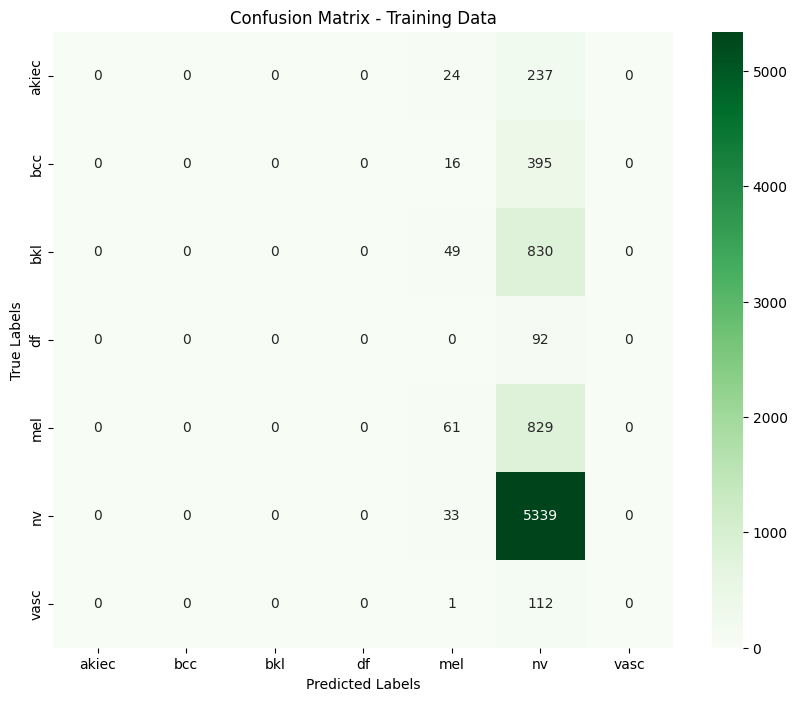

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.33      0.07      0.11       890
          nv       0.68      0.99      0.81      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.14      0.15      0.13      8018
weighted avg       0.49      0.67      0.55      8018

126/126 [==============================] - 29s 233ms/step


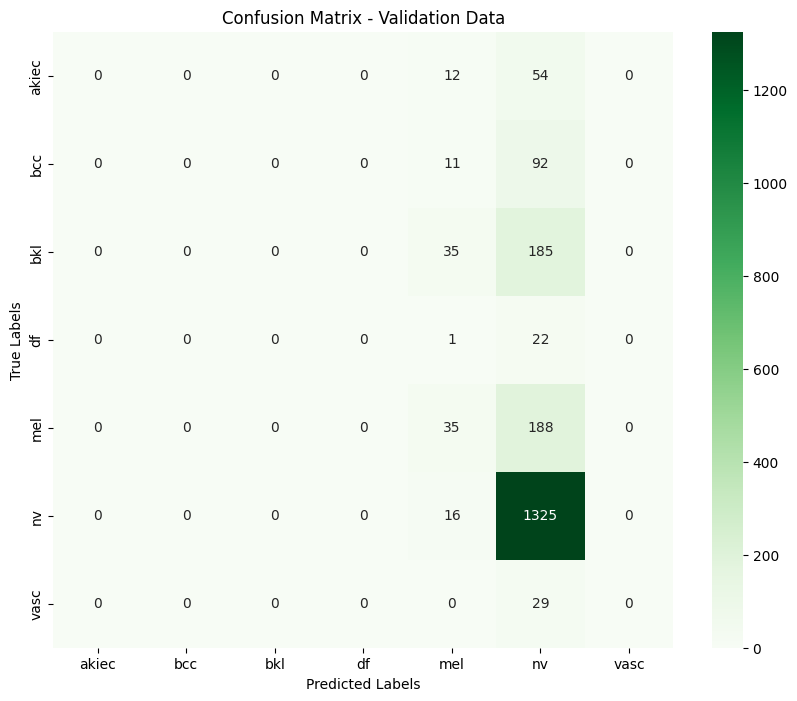

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.32      0.16      0.21       223
          nv       0.70      0.99      0.82      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.68      2005
   macro avg       0.15      0.16      0.15      2005
weighted avg       0.50      0.68      0.57      2005

95/95 [==============================] - 22s 233ms/step


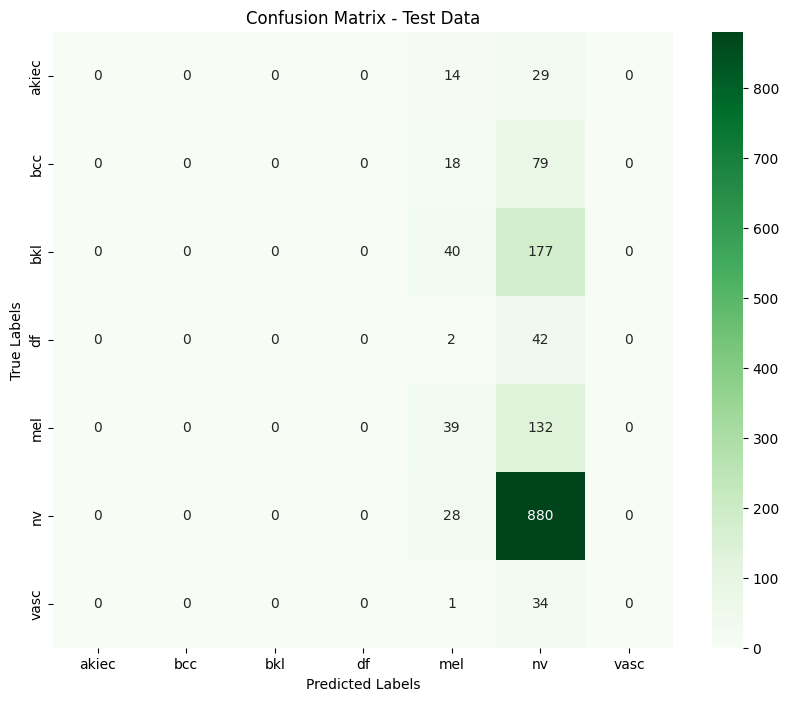

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.27      0.23      0.25       171
          nv       0.64      0.97      0.77       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.61      1515
   macro avg       0.13      0.17      0.15      1515
weighted avg       0.42      0.61      0.49      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldVGG16.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

VGG19

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldVGG19.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 27s 265ms/step
Epoch 1 - Validation Loss: 1.1664, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.16644, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 1.3500 - acc: 0.6110 - val_loss: 1.1664 - val_acc: 0.6696 - lr: 1.0000e-04 - 241s/epoch - 602ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 2 - Validation Loss: 1.1219, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.16644 to 1.12191, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.1852 - acc: 0.6698 - val_loss: 1.1219 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 3 - Validation Loss: 1.0885, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.12191 to 1.08853, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.1394 - acc: 0.6701 - val_loss: 1.0885 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 4 - Validation Loss: 1.0624, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 4: val_loss improved from 1.08853 to 1.06244, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.1081 - acc: 0.6699 - val_loss: 1.0624 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 5 - Validation Loss: 1.0390, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 5: val_loss improved from 1.06244 to 1.03900, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 1.0884 - acc: 0.6699 - val_loss: 1.0390 - val_acc: 0.6696 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 6 - Validation Loss: 1.0306, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 6: val_loss improved from 1.03900 to 1.03058, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0743 - acc: 0.6695 - val_loss: 1.0306 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 7 - Validation Loss: 1.0114, Validation Accuracy: 0.6690, Validation Precision: 0.4488

Epoch 7: val_loss improved from 1.03058 to 1.01143, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0634 - acc: 0.6701 - val_loss: 1.0114 - val_acc: 0.6690 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 8 - Validation Loss: 1.0087, Validation Accuracy: 0.6733, Validation Precision: 0.4991

Epoch 8: val_loss improved from 1.01143 to 1.00873, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0602 - acc: 0.6703 - val_loss: 1.0087 - val_acc: 0.6733 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 9 - Validation Loss: 1.0030, Validation Accuracy: 0.6758, Validation Precision: 0.5016

Epoch 9: val_loss improved from 1.00873 to 1.00296, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0458 - acc: 0.6703 - val_loss: 1.0030 - val_acc: 0.6758 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 10 - Validation Loss: 0.9900, Validation Accuracy: 0.6758, Validation Precision: 0.5015

Epoch 10: val_loss improved from 1.00296 to 0.99001, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0412 - acc: 0.6704 - val_loss: 0.9900 - val_acc: 0.6758 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 11 - Validation Loss: 0.9814, Validation Accuracy: 0.6764, Validation Precision: 0.5137

Epoch 11: val_loss improved from 0.99001 to 0.98139, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0384 - acc: 0.6717 - val_loss: 0.9814 - val_acc: 0.6764 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 12 - Validation Loss: 1.0005, Validation Accuracy: 0.6771, Validation Precision: 0.5153

Epoch 12: val_loss did not improve from 0.98139
401/401 - 238s - loss: 1.0343 - acc: 0.6713 - val_loss: 1.0005 - val_acc: 0.6771 - lr: 1.0000e-04 - 238s/epoch - 595ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 13 - Validation Loss: 0.9729, Validation Accuracy: 0.6764, Validation Precision: 0.5099

Epoch 13: val_loss improved from 0.98139 to 0.97293, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 1.0211 - acc: 0.6723 - val_loss: 0.9729 - val_acc: 0.6764 - lr: 1.0000e-04 - 238s/epoch - 593ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 14 - Validation Loss: 0.9720, Validation Accuracy: 0.6721, Validation Precision: 0.5198

Epoch 14: val_loss improved from 0.97293 to 0.97203, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0191 - acc: 0.6734 - val_loss: 0.9720 - val_acc: 0.6721 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 15 - Validation Loss: 0.9662, Validation Accuracy: 0.6771, Validation Precision: 0.5007

Epoch 15: val_loss improved from 0.97203 to 0.96616, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0136 - acc: 0.6729 - val_loss: 0.9662 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 16 - Validation Loss: 0.9604, Validation Accuracy: 0.6783, Validation Precision: 0.5113

Epoch 16: val_loss improved from 0.96616 to 0.96043, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0087 - acc: 0.6718 - val_loss: 0.9604 - val_acc: 0.6783 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 17 - Validation Loss: 0.9582, Validation Accuracy: 0.6714, Validation Precision: 0.5214

Epoch 17: val_loss improved from 0.96043 to 0.95822, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0087 - acc: 0.6715 - val_loss: 0.9582 - val_acc: 0.6714 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 18 - Validation Loss: 0.9518, Validation Accuracy: 0.6727, Validation Precision: 0.5190

Epoch 18: val_loss improved from 0.95822 to 0.95175, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 1.0019 - acc: 0.6742 - val_loss: 0.9518 - val_acc: 0.6727 - lr: 1.0000e-04 - 238s/epoch - 593ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 19 - Validation Loss: 0.9511, Validation Accuracy: 0.6777, Validation Precision: 0.5061

Epoch 19: val_loss improved from 0.95175 to 0.95111, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0016 - acc: 0.6704 - val_loss: 0.9511 - val_acc: 0.6777 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 20 - Validation Loss: 0.9440, Validation Accuracy: 0.6814, Validation Precision: 0.5214

Epoch 20: val_loss improved from 0.95111 to 0.94401, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9949 - acc: 0.6757 - val_loss: 0.9440 - val_acc: 0.6814 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 21 - Validation Loss: 0.9417, Validation Accuracy: 0.6789, Validation Precision: 0.5131

Epoch 21: val_loss improved from 0.94401 to 0.94173, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9973 - acc: 0.6734 - val_loss: 0.9417 - val_acc: 0.6789 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 22 - Validation Loss: 0.9466, Validation Accuracy: 0.6771, Validation Precision: 0.5213

Epoch 22: val_loss did not improve from 0.94173
401/401 - 239s - loss: 0.9848 - acc: 0.6762 - val_loss: 0.9466 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 23 - Validation Loss: 0.9446, Validation Accuracy: 0.6802, Validation Precision: 0.6251

Epoch 23: val_loss did not improve from 0.94173
401/401 - 239s - loss: 0.9856 - acc: 0.6757 - val_loss: 0.9446 - val_acc: 0.6802 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 24 - Validation Loss: 0.9343, Validation Accuracy: 0.6789, Validation Precision: 0.5036

Epoch 24: val_loss improved from 0.94173 to 0.93429, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9862 - acc: 0.6738 - val_loss: 0.9343 - val_acc: 0.6789 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 25 - Validation Loss: 0.9331, Validation Accuracy: 0.6808, Validation Precision: 0.6217

Epoch 25: val_loss improved from 0.93429 to 0.93308, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9780 - acc: 0.6752 - val_loss: 0.9331 - val_acc: 0.6808 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 26 - Validation Loss: 0.9293, Validation Accuracy: 0.6733, Validation Precision: 0.5343

Epoch 26: val_loss improved from 0.93308 to 0.92930, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9735 - acc: 0.6773 - val_loss: 0.9293 - val_acc: 0.6733 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 27 - Validation Loss: 0.9241, Validation Accuracy: 0.6796, Validation Precision: 0.5580

Epoch 27: val_loss improved from 0.92930 to 0.92411, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 0.9727 - acc: 0.6774 - val_loss: 0.9241 - val_acc: 0.6796 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 28 - Validation Loss: 0.9199, Validation Accuracy: 0.6802, Validation Precision: 0.6258

Epoch 28: val_loss improved from 0.92411 to 0.91991, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9708 - acc: 0.6752 - val_loss: 0.9199 - val_acc: 0.6802 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 29 - Validation Loss: 0.9156, Validation Accuracy: 0.6802, Validation Precision: 0.6314

Epoch 29: val_loss improved from 0.91991 to 0.91563, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9656 - acc: 0.6780 - val_loss: 0.9156 - val_acc: 0.6802 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 30 - Validation Loss: 0.9257, Validation Accuracy: 0.6771, Validation Precision: 0.6301

Epoch 30: val_loss did not improve from 0.91563
401/401 - 239s - loss: 0.9595 - acc: 0.6763 - val_loss: 0.9257 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 31 - Validation Loss: 0.9251, Validation Accuracy: 0.6739, Validation Precision: 0.5701

Epoch 31: val_loss did not improve from 0.91563
401/401 - 239s - loss: 0.9649 - acc: 0.6746 - val_loss: 0.9251 - val_acc: 0.6739 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 32 - Validation Loss: 0.9115, Validation Accuracy: 0.6752, Validation Precision: 0.6285

Epoch 32: val_loss improved from 0.91563 to 0.91154, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9544 - acc: 0.6774 - val_loss: 0.9115 - val_acc: 0.6752 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 33 - Validation Loss: 0.9144, Validation Accuracy: 0.6796, Validation Precision: 0.6240

Epoch 33: val_loss did not improve from 0.91154
401/401 - 238s - loss: 0.9555 - acc: 0.6774 - val_loss: 0.9144 - val_acc: 0.6796 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 34 - Validation Loss: 0.9057, Validation Accuracy: 0.6771, Validation Precision: 0.5787

Epoch 34: val_loss improved from 0.91154 to 0.90570, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9501 - acc: 0.6779 - val_loss: 0.9057 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 35 - Validation Loss: 0.9139, Validation Accuracy: 0.6758, Validation Precision: 0.5718

Epoch 35: val_loss did not improve from 0.90570
401/401 - 239s - loss: 0.9472 - acc: 0.6819 - val_loss: 0.9139 - val_acc: 0.6758 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 36 - Validation Loss: 0.9004, Validation Accuracy: 0.6789, Validation Precision: 0.5652

Epoch 36: val_loss improved from 0.90570 to 0.90039, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9524 - acc: 0.6771 - val_loss: 0.9004 - val_acc: 0.6789 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 37 - Validation Loss: 0.9091, Validation Accuracy: 0.6758, Validation Precision: 0.5485

Epoch 37: val_loss did not improve from 0.90039
401/401 - 239s - loss: 0.9413 - acc: 0.6816 - val_loss: 0.9091 - val_acc: 0.6758 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 38 - Validation Loss: 0.8958, Validation Accuracy: 0.6789, Validation Precision: 0.5659

Epoch 38: val_loss improved from 0.90039 to 0.89575, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9407 - acc: 0.6795 - val_loss: 0.8958 - val_acc: 0.6789 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 39 - Validation Loss: 0.8995, Validation Accuracy: 0.6771, Validation Precision: 0.5599

Epoch 39: val_loss did not improve from 0.89575
401/401 - 239s - loss: 0.9431 - acc: 0.6787 - val_loss: 0.8995 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 40 - Validation Loss: 0.8967, Validation Accuracy: 0.6802, Validation Precision: 0.5663

Epoch 40: val_loss did not improve from 0.89575
401/401 - 239s - loss: 0.9370 - acc: 0.6762 - val_loss: 0.8967 - val_acc: 0.6802 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 41 - Validation Loss: 0.9007, Validation Accuracy: 0.6771, Validation Precision: 0.5609

Epoch 41: val_loss did not improve from 0.89575
401/401 - 239s - loss: 0.9351 - acc: 0.6818 - val_loss: 0.9007 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 42 - Validation Loss: 0.8878, Validation Accuracy: 0.6796, Validation Precision: 0.5835

Epoch 42: val_loss improved from 0.89575 to 0.88778, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9361 - acc: 0.6784 - val_loss: 0.8878 - val_acc: 0.6796 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 43 - Validation Loss: 0.8966, Validation Accuracy: 0.6783, Validation Precision: 0.5787

Epoch 43: val_loss did not improve from 0.88778
401/401 - 238s - loss: 0.9272 - acc: 0.6779 - val_loss: 0.8966 - val_acc: 0.6783 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 44 - Validation Loss: 0.8865, Validation Accuracy: 0.6808, Validation Precision: 0.5702

Epoch 44: val_loss improved from 0.88778 to 0.88651, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9227 - acc: 0.6815 - val_loss: 0.8865 - val_acc: 0.6808 - lr: 1.0000e-04 - 240s/epoch - 600ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 45 - Validation Loss: 0.8854, Validation Accuracy: 0.6789, Validation Precision: 0.5691

Epoch 45: val_loss improved from 0.88651 to 0.88544, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9311 - acc: 0.6843 - val_loss: 0.8854 - val_acc: 0.6789 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 46 - Validation Loss: 0.8921, Validation Accuracy: 0.6789, Validation Precision: 0.5803

Epoch 46: val_loss did not improve from 0.88544
401/401 - 238s - loss: 0.9275 - acc: 0.6795 - val_loss: 0.8921 - val_acc: 0.6789 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 47 - Validation Loss: 0.8893, Validation Accuracy: 0.6808, Validation Precision: 0.5697

Epoch 47: val_loss did not improve from 0.88544
401/401 - 240s - loss: 0.9260 - acc: 0.6810 - val_loss: 0.8893 - val_acc: 0.6808 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 48 - Validation Loss: 0.8833, Validation Accuracy: 0.6820, Validation Precision: 0.5858

Epoch 48: val_loss improved from 0.88544 to 0.88326, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9252 - acc: 0.6784 - val_loss: 0.8833 - val_acc: 0.6820 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 49 - Validation Loss: 0.8969, Validation Accuracy: 0.6733, Validation Precision: 0.5808

Epoch 49: val_loss did not improve from 0.88326
401/401 - 238s - loss: 0.9157 - acc: 0.6851 - val_loss: 0.8969 - val_acc: 0.6733 - lr: 1.0000e-04 - 238s/epoch - 595ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 50 - Validation Loss: 0.8760, Validation Accuracy: 0.6814, Validation Precision: 0.5654

Epoch 50: val_loss improved from 0.88326 to 0.87604, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 0.9156 - acc: 0.6838 - val_loss: 0.8760 - val_acc: 0.6814 - lr: 1.0000e-04 - 237s/epoch - 591ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 51 - Validation Loss: 0.8751, Validation Accuracy: 0.6858, Validation Precision: 0.5766

Epoch 51: val_loss improved from 0.87604 to 0.87512, saving model to 5foldVGG19.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 239s - loss: 0.9237 - acc: 0.6837 - val_loss: 0.8751 - val_acc: 0.6858 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 52/1000
101/101 [==============================] - 27s 264ms/step
Epoch 52 - Validation Loss: 0.8726, Validation Accuracy: 0.6870, Validation Precision: 0.5892

Epoch 52: val_loss improved from 0.87512 to 0.87265, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9182 - acc: 0.6819 - val_loss: 0.8726 - val_acc: 0.6870 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 53 - Validation Loss: 0.8874, Validation Accuracy: 0.6852, Validation Precision: 0.5573

Epoch 53: val_loss did not improve from 0.87265
401/401 - 239s - loss: 0.9132 - acc: 0.6837 - val_loss: 0.8874 - val_acc: 0.6852 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 54 - Validation Loss: 0.8723, Validation Accuracy: 0.6820, Validation Precision: 0.5647

Epoch 54: val_loss improved from 0.87265 to 0.87230, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9180 - acc: 0.6843 - val_loss: 0.8723 - val_acc: 0.6820 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 55 - Validation Loss: 0.8781, Validation Accuracy: 0.6764, Validation Precision: 0.5890

Epoch 55: val_loss did not improve from 0.87230
401/401 - 239s - loss: 0.9147 - acc: 0.6830 - val_loss: 0.8781 - val_acc: 0.6764 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 56 - Validation Loss: 0.9017, Validation Accuracy: 0.6721, Validation Precision: 0.5916

Epoch 56: val_loss did not improve from 0.87230
401/401 - 240s - loss: 0.9150 - acc: 0.6860 - val_loss: 0.9017 - val_acc: 0.6721 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 57 - Validation Loss: 0.8682, Validation Accuracy: 0.6845, Validation Precision: 0.5844

Epoch 57: val_loss improved from 0.87230 to 0.86819, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9097 - acc: 0.6826 - val_loss: 0.8682 - val_acc: 0.6845 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 58 - Validation Loss: 0.8771, Validation Accuracy: 0.6827, Validation Precision: 0.5628

Epoch 58: val_loss did not improve from 0.86819
401/401 - 240s - loss: 0.9090 - acc: 0.6833 - val_loss: 0.8771 - val_acc: 0.6827 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 59 - Validation Loss: 0.8789, Validation Accuracy: 0.6808, Validation Precision: 0.5899

Epoch 59: val_loss did not improve from 0.86819
401/401 - 240s - loss: 0.9121 - acc: 0.6866 - val_loss: 0.8789 - val_acc: 0.6808 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 60 - Validation Loss: 0.8692, Validation Accuracy: 0.6845, Validation Precision: 0.5777

Epoch 60: val_loss did not improve from 0.86819
401/401 - 238s - loss: 0.9102 - acc: 0.6815 - val_loss: 0.8692 - val_acc: 0.6845 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 61 - Validation Loss: 0.8640, Validation Accuracy: 0.6839, Validation Precision: 0.5670

Epoch 61: val_loss improved from 0.86819 to 0.86400, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9031 - acc: 0.6841 - val_loss: 0.8640 - val_acc: 0.6839 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 62 - Validation Loss: 0.8684, Validation Accuracy: 0.6777, Validation Precision: 0.5954

Epoch 62: val_loss did not improve from 0.86400
401/401 - 241s - loss: 0.9106 - acc: 0.6851 - val_loss: 0.8684 - val_acc: 0.6777 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 63 - Validation Loss: 0.8546, Validation Accuracy: 0.6883, Validation Precision: 0.5835

Epoch 63: val_loss improved from 0.86400 to 0.85462, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.8992 - acc: 0.6835 - val_loss: 0.8546 - val_acc: 0.6883 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 64 - Validation Loss: 0.8579, Validation Accuracy: 0.6883, Validation Precision: 0.5944

Epoch 64: val_loss did not improve from 0.85462
401/401 - 240s - loss: 0.9039 - acc: 0.6838 - val_loss: 0.8579 - val_acc: 0.6883 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 65 - Validation Loss: 0.8727, Validation Accuracy: 0.6827, Validation Precision: 0.5856

Epoch 65: val_loss did not improve from 0.85462
401/401 - 240s - loss: 0.9007 - acc: 0.6852 - val_loss: 0.8727 - val_acc: 0.6827 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 66 - Validation Loss: 0.8629, Validation Accuracy: 0.6845, Validation Precision: 0.5779

Epoch 66: val_loss did not improve from 0.85462
401/401 - 240s - loss: 0.9055 - acc: 0.6854 - val_loss: 0.8629 - val_acc: 0.6845 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 67 - Validation Loss: 0.8663, Validation Accuracy: 0.6864, Validation Precision: 0.5677

Epoch 67: val_loss did not improve from 0.85462
401/401 - 239s - loss: 0.8948 - acc: 0.6879 - val_loss: 0.8663 - val_acc: 0.6864 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 68 - Validation Loss: 0.8491, Validation Accuracy: 0.6926, Validation Precision: 0.5991

Epoch 68: val_loss improved from 0.85462 to 0.84909, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.8953 - acc: 0.6879 - val_loss: 0.8491 - val_acc: 0.6926 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 69 - Validation Loss: 0.8722, Validation Accuracy: 0.6845, Validation Precision: 0.5893

Epoch 69: val_loss did not improve from 0.84909
401/401 - 240s - loss: 0.8937 - acc: 0.6882 - val_loss: 0.8722 - val_acc: 0.6845 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 70 - Validation Loss: 0.8492, Validation Accuracy: 0.6895, Validation Precision: 0.6518

Epoch 70: val_loss did not improve from 0.84909
401/401 - 239s - loss: 0.8925 - acc: 0.6888 - val_loss: 0.8492 - val_acc: 0.6895 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 71 - Validation Loss: 0.8769, Validation Accuracy: 0.6864, Validation Precision: 0.5825

Epoch 71: val_loss did not improve from 0.84909
401/401 - 240s - loss: 0.8948 - acc: 0.6888 - val_loss: 0.8769 - val_acc: 0.6864 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 72 - Validation Loss: 0.8543, Validation Accuracy: 0.6833, Validation Precision: 0.6463

Epoch 72: val_loss did not improve from 0.84909
401/401 - 240s - loss: 0.8926 - acc: 0.6897 - val_loss: 0.8543 - val_acc: 0.6833 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 73 - Validation Loss: 0.8506, Validation Accuracy: 0.6845, Validation Precision: 0.5991

Epoch 73: val_loss did not improve from 0.84909
401/401 - 239s - loss: 0.9007 - acc: 0.6837 - val_loss: 0.8506 - val_acc: 0.6845 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Fold 2
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 27s 264ms/step
Epoch 1 - Validation Loss: 1.1394, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.13938, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.3920 - acc: 0.5819 - val_loss: 1.1394 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 2 - Validation Loss: 1.1170, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.13938 to 1.11699, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 1.1786 - acc: 0.6692 - val_loss: 1.1170 - val_acc: 0.6696 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 3 - Validation Loss: 1.0857, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.11699 to 1.08569, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.1421 - acc: 0.6698 - val_loss: 1.0857 - val_acc: 0.6696 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 4 - Validation Loss: 1.0557, Validation Accuracy: 0.6696, Validation Precision: 0.4857

Epoch 4: val_loss improved from 1.08569 to 1.05571, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 1.1234 - acc: 0.6699 - val_loss: 1.0557 - val_acc: 0.6696 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 5 - Validation Loss: 1.0338, Validation Accuracy: 0.6696, Validation Precision: 0.4806

Epoch 5: val_loss improved from 1.05571 to 1.03380, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0947 - acc: 0.6712 - val_loss: 1.0338 - val_acc: 0.6696 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 6 - Validation Loss: 1.0356, Validation Accuracy: 0.6777, Validation Precision: 0.5077

Epoch 6: val_loss did not improve from 1.03380
401/401 - 239s - loss: 1.0772 - acc: 0.6710 - val_loss: 1.0356 - val_acc: 0.6777 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 7 - Validation Loss: 1.0195, Validation Accuracy: 0.6777, Validation Precision: 0.5128

Epoch 7: val_loss improved from 1.03380 to 1.01948, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0657 - acc: 0.6688 - val_loss: 1.0195 - val_acc: 0.6777 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 8 - Validation Loss: 1.0172, Validation Accuracy: 0.6746, Validation Precision: 0.5130

Epoch 8: val_loss improved from 1.01948 to 1.01717, saving model to 5foldVGG19.h5
401/401 - 242s - loss: 1.0578 - acc: 0.6717 - val_loss: 1.0172 - val_acc: 0.6746 - lr: 1.0000e-04 - 242s/epoch - 603ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 9 - Validation Loss: 1.0170, Validation Accuracy: 0.6621, Validation Precision: 0.5200

Epoch 9: val_loss improved from 1.01717 to 1.01700, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0489 - acc: 0.6685 - val_loss: 1.0170 - val_acc: 0.6621 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 10 - Validation Loss: 1.0035, Validation Accuracy: 0.6677, Validation Precision: 0.5186

Epoch 10: val_loss improved from 1.01700 to 1.00351, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0499 - acc: 0.6695 - val_loss: 1.0035 - val_acc: 0.6677 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 11 - Validation Loss: 1.0024, Validation Accuracy: 0.6721, Validation Precision: 0.5154

Epoch 11: val_loss improved from 1.00351 to 1.00240, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0429 - acc: 0.6706 - val_loss: 1.0024 - val_acc: 0.6721 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 12 - Validation Loss: 0.9990, Validation Accuracy: 0.6646, Validation Precision: 0.5237

Epoch 12: val_loss improved from 1.00240 to 0.99897, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0373 - acc: 0.6696 - val_loss: 0.9990 - val_acc: 0.6646 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 13 - Validation Loss: 0.9873, Validation Accuracy: 0.6702, Validation Precision: 0.5161

Epoch 13: val_loss improved from 0.99897 to 0.98730, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0334 - acc: 0.6717 - val_loss: 0.9873 - val_acc: 0.6702 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 14 - Validation Loss: 0.9799, Validation Accuracy: 0.6796, Validation Precision: 0.5141

Epoch 14: val_loss improved from 0.98730 to 0.97989, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0264 - acc: 0.6729 - val_loss: 0.9799 - val_acc: 0.6796 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 15 - Validation Loss: 0.9829, Validation Accuracy: 0.6683, Validation Precision: 0.5188

Epoch 15: val_loss did not improve from 0.97989
401/401 - 237s - loss: 1.0275 - acc: 0.6726 - val_loss: 0.9829 - val_acc: 0.6683 - lr: 1.0000e-04 - 237s/epoch - 592ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 16 - Validation Loss: 0.9767, Validation Accuracy: 0.6739, Validation Precision: 0.5165

Epoch 16: val_loss improved from 0.97989 to 0.97674, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0242 - acc: 0.6682 - val_loss: 0.9767 - val_acc: 0.6739 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 17 - Validation Loss: 0.9724, Validation Accuracy: 0.6714, Validation Precision: 0.5193

Epoch 17: val_loss improved from 0.97674 to 0.97240, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0184 - acc: 0.6737 - val_loss: 0.9724 - val_acc: 0.6714 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 18 - Validation Loss: 0.9678, Validation Accuracy: 0.6733, Validation Precision: 0.5209

Epoch 18: val_loss improved from 0.97240 to 0.96782, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0156 - acc: 0.6720 - val_loss: 0.9678 - val_acc: 0.6733 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 19 - Validation Loss: 0.9624, Validation Accuracy: 0.6764, Validation Precision: 0.5194

Epoch 19: val_loss improved from 0.96782 to 0.96240, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.0166 - acc: 0.6734 - val_loss: 0.9624 - val_acc: 0.6764 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 20 - Validation Loss: 0.9634, Validation Accuracy: 0.6752, Validation Precision: 0.5575

Epoch 20: val_loss did not improve from 0.96240
401/401 - 239s - loss: 1.0065 - acc: 0.6735 - val_loss: 0.9634 - val_acc: 0.6752 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 21 - Validation Loss: 0.9547, Validation Accuracy: 0.6833, Validation Precision: 0.5135

Epoch 21: val_loss improved from 0.96240 to 0.95470, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.0044 - acc: 0.6749 - val_loss: 0.9547 - val_acc: 0.6833 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 22 - Validation Loss: 0.9517, Validation Accuracy: 0.6796, Validation Precision: 0.5160

Epoch 22: val_loss improved from 0.95470 to 0.95172, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 1.0028 - acc: 0.6707 - val_loss: 0.9517 - val_acc: 0.6796 - lr: 1.0000e-04 - 241s/epoch - 602ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 23 - Validation Loss: 0.9501, Validation Accuracy: 0.6739, Validation Precision: 0.5240

Epoch 23: val_loss improved from 0.95172 to 0.95011, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 0.9951 - acc: 0.6742 - val_loss: 0.9501 - val_acc: 0.6739 - lr: 1.0000e-04 - 238s/epoch - 593ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 24 - Validation Loss: 0.9501, Validation Accuracy: 0.6783, Validation Precision: 0.5202

Epoch 24: val_loss did not improve from 0.95011
401/401 - 239s - loss: 0.9957 - acc: 0.6734 - val_loss: 0.9501 - val_acc: 0.6783 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 25 - Validation Loss: 0.9411, Validation Accuracy: 0.6771, Validation Precision: 0.5261

Epoch 25: val_loss improved from 0.95011 to 0.94112, saving model to 5foldVGG19.h5
401/401 - 242s - loss: 0.9956 - acc: 0.6715 - val_loss: 0.9411 - val_acc: 0.6771 - lr: 1.0000e-04 - 242s/epoch - 603ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 26 - Validation Loss: 0.9374, Validation Accuracy: 0.6808, Validation Precision: 0.5223

Epoch 26: val_loss improved from 0.94112 to 0.93744, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9856 - acc: 0.6762 - val_loss: 0.9374 - val_acc: 0.6808 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 27 - Validation Loss: 0.9335, Validation Accuracy: 0.6852, Validation Precision: 0.5465

Epoch 27: val_loss improved from 0.93744 to 0.93354, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9838 - acc: 0.6710 - val_loss: 0.9335 - val_acc: 0.6852 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 28 - Validation Loss: 0.9340, Validation Accuracy: 0.6852, Validation Precision: 0.5583

Epoch 28: val_loss did not improve from 0.93354
401/401 - 241s - loss: 0.9809 - acc: 0.6737 - val_loss: 0.9340 - val_acc: 0.6852 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 29 - Validation Loss: 0.9280, Validation Accuracy: 0.6858, Validation Precision: 0.5558

Epoch 29: val_loss improved from 0.93354 to 0.92804, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9802 - acc: 0.6729 - val_loss: 0.9280 - val_acc: 0.6858 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 30 - Validation Loss: 0.9431, Validation Accuracy: 0.6820, Validation Precision: 0.5652

Epoch 30: val_loss did not improve from 0.92804
401/401 - 240s - loss: 0.9769 - acc: 0.6743 - val_loss: 0.9431 - val_acc: 0.6820 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 31 - Validation Loss: 0.9238, Validation Accuracy: 0.6864, Validation Precision: 0.5571

Epoch 31: val_loss improved from 0.92804 to 0.92379, saving model to 5foldVGG19.h5
401/401 - 242s - loss: 0.9665 - acc: 0.6751 - val_loss: 0.9238 - val_acc: 0.6864 - lr: 1.0000e-04 - 242s/epoch - 602ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 32 - Validation Loss: 0.9208, Validation Accuracy: 0.6845, Validation Precision: 0.5632

Epoch 32: val_loss improved from 0.92379 to 0.92082, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9682 - acc: 0.6756 - val_loss: 0.9208 - val_acc: 0.6845 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 33 - Validation Loss: 0.9226, Validation Accuracy: 0.6814, Validation Precision: 0.5640

Epoch 33: val_loss did not improve from 0.92082
401/401 - 240s - loss: 0.9663 - acc: 0.6756 - val_loss: 0.9226 - val_acc: 0.6814 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 34 - Validation Loss: 0.9339, Validation Accuracy: 0.6796, Validation Precision: 0.5603

Epoch 34: val_loss did not improve from 0.92082
401/401 - 242s - loss: 0.9640 - acc: 0.6766 - val_loss: 0.9339 - val_acc: 0.6796 - lr: 1.0000e-04 - 242s/epoch - 603ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 35 - Validation Loss: 0.9125, Validation Accuracy: 0.6852, Validation Precision: 0.5639

Epoch 35: val_loss improved from 0.92082 to 0.91246, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9576 - acc: 0.6748 - val_loss: 0.9125 - val_acc: 0.6852 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 36 - Validation Loss: 0.9155, Validation Accuracy: 0.6895, Validation Precision: 0.5664

Epoch 36: val_loss did not improve from 0.91246
401/401 - 240s - loss: 0.9605 - acc: 0.6757 - val_loss: 0.9155 - val_acc: 0.6895 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 37 - Validation Loss: 0.9116, Validation Accuracy: 0.6883, Validation Precision: 0.5591

Epoch 37: val_loss improved from 0.91246 to 0.91159, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9553 - acc: 0.6759 - val_loss: 0.9116 - val_acc: 0.6883 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 38 - Validation Loss: 0.9143, Validation Accuracy: 0.6845, Validation Precision: 0.5626

Epoch 38: val_loss did not improve from 0.91159
401/401 - 240s - loss: 0.9496 - acc: 0.6751 - val_loss: 0.9143 - val_acc: 0.6845 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 39 - Validation Loss: 0.9040, Validation Accuracy: 0.6858, Validation Precision: 0.5512

Epoch 39: val_loss improved from 0.91159 to 0.90405, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9484 - acc: 0.6780 - val_loss: 0.9040 - val_acc: 0.6858 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 40 - Validation Loss: 0.9000, Validation Accuracy: 0.6901, Validation Precision: 0.5705

Epoch 40: val_loss improved from 0.90405 to 0.89995, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9440 - acc: 0.6762 - val_loss: 0.9000 - val_acc: 0.6901 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 41 - Validation Loss: 0.8955, Validation Accuracy: 0.6883, Validation Precision: 0.5697

Epoch 41: val_loss improved from 0.89995 to 0.89547, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9419 - acc: 0.6798 - val_loss: 0.8955 - val_acc: 0.6883 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 42 - Validation Loss: 0.8930, Validation Accuracy: 0.6877, Validation Precision: 0.5687

Epoch 42: val_loss improved from 0.89547 to 0.89296, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9431 - acc: 0.6763 - val_loss: 0.8930 - val_acc: 0.6877 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 43 - Validation Loss: 0.9071, Validation Accuracy: 0.6889, Validation Precision: 0.5858

Epoch 43: val_loss did not improve from 0.89296
401/401 - 240s - loss: 0.9403 - acc: 0.6773 - val_loss: 0.9071 - val_acc: 0.6889 - lr: 1.0000e-04 - 240s/epoch - 600ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 44 - Validation Loss: 0.9146, Validation Accuracy: 0.6858, Validation Precision: 0.5818

Epoch 44: val_loss did not improve from 0.89296
401/401 - 238s - loss: 0.9348 - acc: 0.6788 - val_loss: 0.9146 - val_acc: 0.6858 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 45 - Validation Loss: 0.8849, Validation Accuracy: 0.6883, Validation Precision: 0.5722

Epoch 45: val_loss improved from 0.89296 to 0.88487, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9364 - acc: 0.6780 - val_loss: 0.8849 - val_acc: 0.6883 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 46 - Validation Loss: 0.8866, Validation Accuracy: 0.6933, Validation Precision: 0.5852

Epoch 46: val_loss did not improve from 0.88487
401/401 - 241s - loss: 0.9398 - acc: 0.6788 - val_loss: 0.8866 - val_acc: 0.6933 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 47 - Validation Loss: 0.8826, Validation Accuracy: 0.6895, Validation Precision: 0.5755

Epoch 47: val_loss improved from 0.88487 to 0.88260, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9287 - acc: 0.6821 - val_loss: 0.8826 - val_acc: 0.6895 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 48 - Validation Loss: 0.8828, Validation Accuracy: 0.6901, Validation Precision: 0.5846

Epoch 48: val_loss did not improve from 0.88260
401/401 - 240s - loss: 0.9300 - acc: 0.6805 - val_loss: 0.8828 - val_acc: 0.6901 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 49 - Validation Loss: 0.8896, Validation Accuracy: 0.6901, Validation Precision: 0.5962

Epoch 49: val_loss did not improve from 0.88260
401/401 - 241s - loss: 0.9290 - acc: 0.6807 - val_loss: 0.8896 - val_acc: 0.6901 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 50 - Validation Loss: 0.8980, Validation Accuracy: 0.6914, Validation Precision: 0.5924

Epoch 50: val_loss did not improve from 0.88260
401/401 - 239s - loss: 0.9273 - acc: 0.6821 - val_loss: 0.8980 - val_acc: 0.6914 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 51 - Validation Loss: 0.8920, Validation Accuracy: 0.6833, Validation Precision: 0.5871

Epoch 51: val_loss did not improve from 0.88260
401/401 - 239s - loss: 0.9190 - acc: 0.6804 - val_loss: 0.8920 - val_acc: 0.6833 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 52 - Validation Loss: 0.8740, Validation Accuracy: 0.6908, Validation Precision: 0.5881

Epoch 52: val_loss improved from 0.88260 to 0.87396, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9150 - acc: 0.6823 - val_loss: 0.8740 - val_acc: 0.6908 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 53 - Validation Loss: 0.8784, Validation Accuracy: 0.6889, Validation Precision: 0.5734

Epoch 53: val_loss did not improve from 0.87396
401/401 - 240s - loss: 0.9250 - acc: 0.6830 - val_loss: 0.8784 - val_acc: 0.6889 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 54 - Validation Loss: 0.8677, Validation Accuracy: 0.6945, Validation Precision: 0.5755

Epoch 54: val_loss improved from 0.87396 to 0.86765, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9166 - acc: 0.6824 - val_loss: 0.8677 - val_acc: 0.6945 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 55 - Validation Loss: 0.8811, Validation Accuracy: 0.6901, Validation Precision: 0.5931

Epoch 55: val_loss did not improve from 0.86765
401/401 - 240s - loss: 0.9169 - acc: 0.6818 - val_loss: 0.8811 - val_acc: 0.6901 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 56 - Validation Loss: 0.8697, Validation Accuracy: 0.6883, Validation Precision: 0.5788

Epoch 56: val_loss did not improve from 0.86765
401/401 - 240s - loss: 0.9150 - acc: 0.6826 - val_loss: 0.8697 - val_acc: 0.6883 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 57 - Validation Loss: 0.8765, Validation Accuracy: 0.6814, Validation Precision: 0.5986

Epoch 57: val_loss did not improve from 0.86765
401/401 - 240s - loss: 0.9131 - acc: 0.6843 - val_loss: 0.8765 - val_acc: 0.6814 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 58 - Validation Loss: 0.8653, Validation Accuracy: 0.6958, Validation Precision: 0.5805

Epoch 58: val_loss improved from 0.86765 to 0.86529, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9131 - acc: 0.6816 - val_loss: 0.8653 - val_acc: 0.6958 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 59 - Validation Loss: 0.8771, Validation Accuracy: 0.6827, Validation Precision: 0.5894

Epoch 59: val_loss did not improve from 0.86529
401/401 - 239s - loss: 0.9147 - acc: 0.6816 - val_loss: 0.8771 - val_acc: 0.6827 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 60 - Validation Loss: 0.8614, Validation Accuracy: 0.6964, Validation Precision: 0.5849

Epoch 60: val_loss improved from 0.86529 to 0.86136, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9086 - acc: 0.6821 - val_loss: 0.8614 - val_acc: 0.6964 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 61 - Validation Loss: 0.8614, Validation Accuracy: 0.6933, Validation Precision: 0.5942

Epoch 61: val_loss improved from 0.86136 to 0.86136, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9098 - acc: 0.6819 - val_loss: 0.8614 - val_acc: 0.6933 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 62 - Validation Loss: 0.8609, Validation Accuracy: 0.6870, Validation Precision: 0.5890

Epoch 62: val_loss improved from 0.86136 to 0.86095, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9147 - acc: 0.6815 - val_loss: 0.8609 - val_acc: 0.6870 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 63 - Validation Loss: 0.8620, Validation Accuracy: 0.6883, Validation Precision: 0.5769

Epoch 63: val_loss did not improve from 0.86095
401/401 - 239s - loss: 0.9110 - acc: 0.6810 - val_loss: 0.8620 - val_acc: 0.6883 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 64 - Validation Loss: 0.8558, Validation Accuracy: 0.6939, Validation Precision: 0.5852

Epoch 64: val_loss improved from 0.86095 to 0.85578, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9085 - acc: 0.6827 - val_loss: 0.8558 - val_acc: 0.6939 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 65 - Validation Loss: 0.8559, Validation Accuracy: 0.6908, Validation Precision: 0.5822

Epoch 65: val_loss did not improve from 0.85578
401/401 - 240s - loss: 0.9071 - acc: 0.6815 - val_loss: 0.8559 - val_acc: 0.6908 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 66 - Validation Loss: 0.8551, Validation Accuracy: 0.6976, Validation Precision: 0.5988

Epoch 66: val_loss improved from 0.85578 to 0.85514, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.9036 - acc: 0.6816 - val_loss: 0.8551 - val_acc: 0.6976 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 67 - Validation Loss: 0.8566, Validation Accuracy: 0.6908, Validation Precision: 0.5817

Epoch 67: val_loss did not improve from 0.85514
401/401 - 240s - loss: 0.9031 - acc: 0.6815 - val_loss: 0.8566 - val_acc: 0.6908 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 68 - Validation Loss: 0.8634, Validation Accuracy: 0.6858, Validation Precision: 0.5894

Epoch 68: val_loss did not improve from 0.85514
401/401 - 240s - loss: 0.9007 - acc: 0.6801 - val_loss: 0.8634 - val_acc: 0.6858 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 69 - Validation Loss: 0.8506, Validation Accuracy: 0.6964, Validation Precision: 0.5925

Epoch 69: val_loss improved from 0.85514 to 0.85058, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.8974 - acc: 0.6824 - val_loss: 0.8506 - val_acc: 0.6964 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 270ms/step
Epoch 70 - Validation Loss: 0.8548, Validation Accuracy: 0.6901, Validation Precision: 0.5741

Epoch 70: val_loss did not improve from 0.85058
401/401 - 244s - loss: 0.8979 - acc: 0.6851 - val_loss: 0.8548 - val_acc: 0.6901 - lr: 1.0000e-04 - 244s/epoch - 608ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 71 - Validation Loss: 0.8548, Validation Accuracy: 0.6908, Validation Precision: 0.5813

Epoch 71: val_loss did not improve from 0.85058
401/401 - 275s - loss: 0.8983 - acc: 0.6837 - val_loss: 0.8548 - val_acc: 0.6908 - lr: 1.0000e-04 - 275s/epoch - 686ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 72 - Validation Loss: 0.8680, Validation Accuracy: 0.6845, Validation Precision: 0.5965

Epoch 72: val_loss did not improve from 0.85058
401/401 - 239s - loss: 0.8952 - acc: 0.6868 - val_loss: 0.8680 - val_acc: 0.6845 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 73 - Validation Loss: 0.8453, Validation Accuracy: 0.6964, Validation Precision: 0.5844

Epoch 73: val_loss improved from 0.85058 to 0.84534, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.8884 - acc: 0.6832 - val_loss: 0.8453 - val_acc: 0.6964 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 74 - Validation Loss: 0.8537, Validation Accuracy: 0.6901, Validation Precision: 0.5716

Epoch 74: val_loss did not improve from 0.84534
401/401 - 238s - loss: 0.8943 - acc: 0.6855 - val_loss: 0.8537 - val_acc: 0.6901 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 75 - Validation Loss: 0.8487, Validation Accuracy: 0.6951, Validation Precision: 0.5897

Epoch 75: val_loss did not improve from 0.84534
401/401 - 239s - loss: 0.8901 - acc: 0.6868 - val_loss: 0.8487 - val_acc: 0.6951 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 76 - Validation Loss: 0.8431, Validation Accuracy: 0.6976, Validation Precision: 0.5929

Epoch 76: val_loss improved from 0.84534 to 0.84309, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.8967 - acc: 0.6852 - val_loss: 0.8431 - val_acc: 0.6976 - lr: 1.0000e-04 - 239s/epoch - 595ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 77 - Validation Loss: 0.8453, Validation Accuracy: 0.6939, Validation Precision: 0.5973

Epoch 77: val_loss did not improve from 0.84309
401/401 - 240s - loss: 0.8918 - acc: 0.6843 - val_loss: 0.8453 - val_acc: 0.6939 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 78 - Validation Loss: 0.8496, Validation Accuracy: 0.6964, Validation Precision: 0.5920

Epoch 78: val_loss did not improve from 0.84309
401/401 - 238s - loss: 0.8854 - acc: 0.6882 - val_loss: 0.8496 - val_acc: 0.6964 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 79 - Validation Loss: 0.8429, Validation Accuracy: 0.7001, Validation Precision: 0.5980

Epoch 79: val_loss improved from 0.84309 to 0.84289, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 0.8897 - acc: 0.6830 - val_loss: 0.8429 - val_acc: 0.7001 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 80 - Validation Loss: 0.8391, Validation Accuracy: 0.6958, Validation Precision: 0.5918

Epoch 80: val_loss improved from 0.84289 to 0.83909, saving model to 5foldVGG19.h5
401/401 - 261s - loss: 0.8862 - acc: 0.6840 - val_loss: 0.8391 - val_acc: 0.6958 - lr: 1.0000e-04 - 261s/epoch - 650ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 81 - Validation Loss: 0.8465, Validation Accuracy: 0.6895, Validation Precision: 0.6183

Epoch 81: val_loss did not improve from 0.83909
401/401 - 241s - loss: 0.8834 - acc: 0.6832 - val_loss: 0.8465 - val_acc: 0.6895 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 82 - Validation Loss: 0.8771, Validation Accuracy: 0.6771, Validation Precision: 0.6080

Epoch 82: val_loss did not improve from 0.83909
401/401 - 240s - loss: 0.8823 - acc: 0.6835 - val_loss: 0.8771 - val_acc: 0.6771 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 83 - Validation Loss: 0.8550, Validation Accuracy: 0.6827, Validation Precision: 0.5940

Epoch 83: val_loss did not improve from 0.83909
401/401 - 240s - loss: 0.8844 - acc: 0.6876 - val_loss: 0.8550 - val_acc: 0.6827 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 84 - Validation Loss: 0.8428, Validation Accuracy: 0.6908, Validation Precision: 0.5976

Epoch 84: val_loss did not improve from 0.83909
401/401 - 240s - loss: 0.8802 - acc: 0.6874 - val_loss: 0.8428 - val_acc: 0.6908 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 264ms/step
Epoch 85 - Validation Loss: 0.8469, Validation Accuracy: 0.6914, Validation Precision: 0.5918

Epoch 85: val_loss did not improve from 0.83909
401/401 - 240s - loss: 0.8833 - acc: 0.6882 - val_loss: 0.8469 - val_acc: 0.6914 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Fold 3
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 27s 265ms/step
Epoch 1 - Validation Loss: 1.1397, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 1: val_loss improved from inf to 1.13972, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 1.2851 - acc: 0.6441 - val_loss: 1.1397 - val_acc: 0.6696 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 265ms/step
Epoch 2 - Validation Loss: 1.0993, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 2: val_loss improved from 1.13972 to 1.09929, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.1646 - acc: 0.6699 - val_loss: 1.0993 - val_acc: 0.6696 - lr: 1.0000e-04 - 239s/epoch - 596ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 264ms/step
Epoch 3 - Validation Loss: 1.0740, Validation Accuracy: 0.6696, Validation Precision: 0.4483

Epoch 3: val_loss improved from 1.09929 to 1.07400, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.1265 - acc: 0.6701 - val_loss: 1.0740 - val_acc: 0.6696 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 4 - Validation Loss: 1.0469, Validation Accuracy: 0.6702, Validation Precision: 0.5044

Epoch 4: val_loss improved from 1.07400 to 1.04687, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.1026 - acc: 0.6704 - val_loss: 1.0469 - val_acc: 0.6702 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 5 - Validation Loss: 1.0684, Validation Accuracy: 0.6752, Validation Precision: 0.4969

Epoch 5: val_loss did not improve from 1.04687
401/401 - 234s - loss: 1.0830 - acc: 0.6704 - val_loss: 1.0684 - val_acc: 0.6752 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 6 - Validation Loss: 1.0537, Validation Accuracy: 0.6808, Validation Precision: 0.5080

Epoch 6: val_loss did not improve from 1.04687
401/401 - 236s - loss: 1.0685 - acc: 0.6709 - val_loss: 1.0537 - val_acc: 0.6808 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 7 - Validation Loss: 1.0251, Validation Accuracy: 0.6802, Validation Precision: 0.5074

Epoch 7: val_loss improved from 1.04687 to 1.02509, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0640 - acc: 0.6704 - val_loss: 1.0251 - val_acc: 0.6802 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 8 - Validation Loss: 1.0342, Validation Accuracy: 0.6746, Validation Precision: 0.5148

Epoch 8: val_loss did not improve from 1.02509
401/401 - 236s - loss: 1.0578 - acc: 0.6717 - val_loss: 1.0342 - val_acc: 0.6746 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 9 - Validation Loss: 1.0428, Validation Accuracy: 0.6714, Validation Precision: 0.5149

Epoch 9: val_loss did not improve from 1.02509
401/401 - 236s - loss: 1.0484 - acc: 0.6713 - val_loss: 1.0428 - val_acc: 0.6714 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 10 - Validation Loss: 1.0113, Validation Accuracy: 0.6702, Validation Precision: 0.5158

Epoch 10: val_loss improved from 1.02509 to 1.01129, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0425 - acc: 0.6734 - val_loss: 1.0113 - val_acc: 0.6702 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 11 - Validation Loss: 1.0059, Validation Accuracy: 0.6739, Validation Precision: 0.5125

Epoch 11: val_loss improved from 1.01129 to 1.00587, saving model to 5foldVGG19.h5
401/401 - 233s - loss: 1.0373 - acc: 0.6727 - val_loss: 1.0059 - val_acc: 0.6739 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 12 - Validation Loss: 1.0010, Validation Accuracy: 0.6714, Validation Precision: 0.5140

Epoch 12: val_loss improved from 1.00587 to 1.00101, saving model to 5foldVGG19.h5
401/401 - 235s - loss: 1.0295 - acc: 0.6720 - val_loss: 1.0010 - val_acc: 0.6714 - lr: 1.0000e-04 - 235s/epoch - 586ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 13 - Validation Loss: 0.9955, Validation Accuracy: 0.6727, Validation Precision: 0.5146

Epoch 13: val_loss improved from 1.00101 to 0.99554, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0240 - acc: 0.6703 - val_loss: 0.9955 - val_acc: 0.6727 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 14 - Validation Loss: 0.9837, Validation Accuracy: 0.6777, Validation Precision: 0.5134

Epoch 14: val_loss improved from 0.99554 to 0.98370, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 1.0208 - acc: 0.6706 - val_loss: 0.9837 - val_acc: 0.6777 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 15 - Validation Loss: 1.0117, Validation Accuracy: 0.6727, Validation Precision: 0.5359

Epoch 15: val_loss did not improve from 0.98370
401/401 - 236s - loss: 1.0179 - acc: 0.6732 - val_loss: 1.0117 - val_acc: 0.6727 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 16 - Validation Loss: 0.9766, Validation Accuracy: 0.6827, Validation Precision: 0.5153

Epoch 16: val_loss improved from 0.98370 to 0.97662, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 1.0163 - acc: 0.6726 - val_loss: 0.9766 - val_acc: 0.6827 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 17 - Validation Loss: 0.9924, Validation Accuracy: 0.6752, Validation Precision: 0.5338

Epoch 17: val_loss did not improve from 0.97662
401/401 - 236s - loss: 1.0079 - acc: 0.6712 - val_loss: 0.9924 - val_acc: 0.6752 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 18 - Validation Loss: 0.9762, Validation Accuracy: 0.6752, Validation Precision: 0.5215

Epoch 18: val_loss improved from 0.97662 to 0.97618, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0086 - acc: 0.6745 - val_loss: 0.9762 - val_acc: 0.6752 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 19 - Validation Loss: 0.9617, Validation Accuracy: 0.6783, Validation Precision: 0.5188

Epoch 19: val_loss improved from 0.97618 to 0.96174, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 1.0021 - acc: 0.6718 - val_loss: 0.9617 - val_acc: 0.6783 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 20 - Validation Loss: 0.9611, Validation Accuracy: 0.6764, Validation Precision: 0.5196

Epoch 20: val_loss improved from 0.96174 to 0.96107, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9968 - acc: 0.6735 - val_loss: 0.9611 - val_acc: 0.6764 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 21 - Validation Loss: 0.9554, Validation Accuracy: 0.6771, Validation Precision: 0.5173

Epoch 21: val_loss improved from 0.96107 to 0.95539, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9987 - acc: 0.6743 - val_loss: 0.9554 - val_acc: 0.6771 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 22 - Validation Loss: 0.9571, Validation Accuracy: 0.6771, Validation Precision: 0.5260

Epoch 22: val_loss did not improve from 0.95539
401/401 - 234s - loss: 0.9877 - acc: 0.6754 - val_loss: 0.9571 - val_acc: 0.6771 - lr: 1.0000e-04 - 234s/epoch - 585ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 23 - Validation Loss: 0.9493, Validation Accuracy: 0.6777, Validation Precision: 0.5261

Epoch 23: val_loss improved from 0.95539 to 0.94929, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.9843 - acc: 0.6759 - val_loss: 0.9493 - val_acc: 0.6777 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 24 - Validation Loss: 0.9485, Validation Accuracy: 0.6827, Validation Precision: 0.5232

Epoch 24: val_loss improved from 0.94929 to 0.94846, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 0.9843 - acc: 0.6713 - val_loss: 0.9485 - val_acc: 0.6827 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 25 - Validation Loss: 0.9511, Validation Accuracy: 0.6789, Validation Precision: 0.5285

Epoch 25: val_loss did not improve from 0.94846
401/401 - 237s - loss: 0.9828 - acc: 0.6742 - val_loss: 0.9511 - val_acc: 0.6789 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 26 - Validation Loss: 0.9395, Validation Accuracy: 0.6796, Validation Precision: 0.5292

Epoch 26: val_loss improved from 0.94846 to 0.93954, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9804 - acc: 0.6726 - val_loss: 0.9395 - val_acc: 0.6796 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 27 - Validation Loss: 0.9353, Validation Accuracy: 0.6796, Validation Precision: 0.5288

Epoch 27: val_loss improved from 0.93954 to 0.93529, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9766 - acc: 0.6770 - val_loss: 0.9353 - val_acc: 0.6796 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 28 - Validation Loss: 0.9357, Validation Accuracy: 0.6802, Validation Precision: 0.5271

Epoch 28: val_loss did not improve from 0.93529
401/401 - 236s - loss: 0.9694 - acc: 0.6742 - val_loss: 0.9357 - val_acc: 0.6802 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 29 - Validation Loss: 0.9317, Validation Accuracy: 0.6839, Validation Precision: 0.5321

Epoch 29: val_loss improved from 0.93529 to 0.93165, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9661 - acc: 0.6766 - val_loss: 0.9317 - val_acc: 0.6839 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 30 - Validation Loss: 0.9240, Validation Accuracy: 0.6827, Validation Precision: 0.5195

Epoch 30: val_loss improved from 0.93165 to 0.92395, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9654 - acc: 0.6756 - val_loss: 0.9240 - val_acc: 0.6827 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 31 - Validation Loss: 0.9354, Validation Accuracy: 0.6621, Validation Precision: 0.5773

Epoch 31: val_loss did not improve from 0.92395
401/401 - 236s - loss: 0.9584 - acc: 0.6787 - val_loss: 0.9354 - val_acc: 0.6621 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 32 - Validation Loss: 0.9280, Validation Accuracy: 0.6833, Validation Precision: 0.5300

Epoch 32: val_loss did not improve from 0.92395
401/401 - 236s - loss: 0.9649 - acc: 0.6763 - val_loss: 0.9280 - val_acc: 0.6833 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 33 - Validation Loss: 0.9165, Validation Accuracy: 0.6839, Validation Precision: 0.5168

Epoch 33: val_loss improved from 0.92395 to 0.91647, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.9612 - acc: 0.6754 - val_loss: 0.9165 - val_acc: 0.6839 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 34 - Validation Loss: 0.9329, Validation Accuracy: 0.6820, Validation Precision: 0.5382

Epoch 34: val_loss did not improve from 0.91647
401/401 - 235s - loss: 0.9579 - acc: 0.6784 - val_loss: 0.9329 - val_acc: 0.6820 - lr: 1.0000e-04 - 235s/epoch - 587ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 35 - Validation Loss: 0.9119, Validation Accuracy: 0.6827, Validation Precision: 0.5275

Epoch 35: val_loss improved from 0.91647 to 0.91185, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9548 - acc: 0.6756 - val_loss: 0.9119 - val_acc: 0.6827 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 36 - Validation Loss: 0.9152, Validation Accuracy: 0.6833, Validation Precision: 0.5381

Epoch 36: val_loss did not improve from 0.91185
401/401 - 234s - loss: 0.9463 - acc: 0.6782 - val_loss: 0.9152 - val_acc: 0.6833 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 37 - Validation Loss: 0.9160, Validation Accuracy: 0.6783, Validation Precision: 0.5408

Epoch 37: val_loss did not improve from 0.91185
401/401 - 233s - loss: 0.9529 - acc: 0.6774 - val_loss: 0.9160 - val_acc: 0.6783 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 38 - Validation Loss: 0.9076, Validation Accuracy: 0.6845, Validation Precision: 0.5523

Epoch 38: val_loss improved from 0.91185 to 0.90756, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 0.9536 - acc: 0.6763 - val_loss: 0.9076 - val_acc: 0.6845 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 39 - Validation Loss: 0.9083, Validation Accuracy: 0.6802, Validation Precision: 0.5423

Epoch 39: val_loss did not improve from 0.90756
401/401 - 237s - loss: 0.9370 - acc: 0.6773 - val_loss: 0.9083 - val_acc: 0.6802 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 40 - Validation Loss: 0.9026, Validation Accuracy: 0.6833, Validation Precision: 0.5257

Epoch 40: val_loss improved from 0.90756 to 0.90256, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.9417 - acc: 0.6774 - val_loss: 0.9026 - val_acc: 0.6833 - lr: 1.0000e-04 - 234s/epoch - 585ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 41 - Validation Loss: 0.9133, Validation Accuracy: 0.6802, Validation Precision: 0.5683

Epoch 41: val_loss did not improve from 0.90256
401/401 - 236s - loss: 0.9442 - acc: 0.6787 - val_loss: 0.9133 - val_acc: 0.6802 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 42 - Validation Loss: 0.8962, Validation Accuracy: 0.6852, Validation Precision: 0.5483

Epoch 42: val_loss improved from 0.90256 to 0.89619, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9365 - acc: 0.6818 - val_loss: 0.8962 - val_acc: 0.6852 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 43 - Validation Loss: 0.8959, Validation Accuracy: 0.6864, Validation Precision: 0.5632

Epoch 43: val_loss improved from 0.89619 to 0.89585, saving model to 5foldVGG19.h5
401/401 - 246s - loss: 0.9351 - acc: 0.6773 - val_loss: 0.8959 - val_acc: 0.6864 - lr: 1.0000e-04 - 246s/epoch - 613ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 44 - Validation Loss: 0.8945, Validation Accuracy: 0.6858, Validation Precision: 0.5531

Epoch 44: val_loss improved from 0.89585 to 0.89448, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 0.9314 - acc: 0.6807 - val_loss: 0.8945 - val_acc: 0.6858 - lr: 1.0000e-04 - 237s/epoch - 592ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 45 - Validation Loss: 0.9016, Validation Accuracy: 0.6858, Validation Precision: 0.5685

Epoch 45: val_loss did not improve from 0.89448
401/401 - 235s - loss: 0.9315 - acc: 0.6793 - val_loss: 0.9016 - val_acc: 0.6858 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 46 - Validation Loss: 0.8883, Validation Accuracy: 0.6864, Validation Precision: 0.5568

Epoch 46: val_loss improved from 0.89448 to 0.88826, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.9340 - acc: 0.6782 - val_loss: 0.8883 - val_acc: 0.6864 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 47 - Validation Loss: 0.8899, Validation Accuracy: 0.6858, Validation Precision: 0.5637

Epoch 47: val_loss did not improve from 0.88826
401/401 - 236s - loss: 0.9295 - acc: 0.6787 - val_loss: 0.8899 - val_acc: 0.6858 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 48 - Validation Loss: 0.8856, Validation Accuracy: 0.6839, Validation Precision: 0.5636

Epoch 48: val_loss improved from 0.88826 to 0.88562, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.9214 - acc: 0.6804 - val_loss: 0.8856 - val_acc: 0.6839 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 49 - Validation Loss: 0.8962, Validation Accuracy: 0.6839, Validation Precision: 0.5623

Epoch 49: val_loss did not improve from 0.88562
401/401 - 236s - loss: 0.9244 - acc: 0.6787 - val_loss: 0.8962 - val_acc: 0.6839 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 50 - Validation Loss: 0.8842, Validation Accuracy: 0.6864, Validation Precision: 0.5680

Epoch 50: val_loss improved from 0.88562 to 0.88421, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9281 - acc: 0.6813 - val_loss: 0.8842 - val_acc: 0.6864 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 51 - Validation Loss: 0.8843, Validation Accuracy: 0.6901, Validation Precision: 0.5734

Epoch 51: val_loss did not improve from 0.88421
401/401 - 237s - loss: 0.9222 - acc: 0.6846 - val_loss: 0.8843 - val_acc: 0.6901 - lr: 1.0000e-04 - 237s/epoch - 591ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 52 - Validation Loss: 0.8916, Validation Accuracy: 0.6877, Validation Precision: 0.5785

Epoch 52: val_loss did not improve from 0.88421
401/401 - 234s - loss: 0.9171 - acc: 0.6829 - val_loss: 0.8916 - val_acc: 0.6877 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 53 - Validation Loss: 0.8842, Validation Accuracy: 0.6877, Validation Precision: 0.5794

Epoch 53: val_loss improved from 0.88421 to 0.88419, saving model to 5foldVGG19.h5
401/401 - 235s - loss: 0.9165 - acc: 0.6815 - val_loss: 0.8842 - val_acc: 0.6877 - lr: 1.0000e-04 - 235s/epoch - 587ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 54 - Validation Loss: 0.8772, Validation Accuracy: 0.6895, Validation Precision: 0.5733

Epoch 54: val_loss improved from 0.88419 to 0.87723, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9212 - acc: 0.6837 - val_loss: 0.8772 - val_acc: 0.6895 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 55 - Validation Loss: 0.8784, Validation Accuracy: 0.6827, Validation Precision: 0.5775

Epoch 55: val_loss did not improve from 0.87723
401/401 - 246s - loss: 0.9165 - acc: 0.6838 - val_loss: 0.8784 - val_acc: 0.6827 - lr: 1.0000e-04 - 246s/epoch - 612ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 56 - Validation Loss: 0.8767, Validation Accuracy: 0.6814, Validation Precision: 0.5824

Epoch 56: val_loss improved from 0.87723 to 0.87671, saving model to 5foldVGG19.h5
401/401 - 264s - loss: 0.9164 - acc: 0.6833 - val_loss: 0.8767 - val_acc: 0.6814 - lr: 1.0000e-04 - 264s/epoch - 659ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 57 - Validation Loss: 0.8714, Validation Accuracy: 0.6914, Validation Precision: 0.5790

Epoch 57: val_loss improved from 0.87671 to 0.87139, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 0.9190 - acc: 0.6821 - val_loss: 0.8714 - val_acc: 0.6914 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 58 - Validation Loss: 0.8787, Validation Accuracy: 0.6845, Validation Precision: 0.5804

Epoch 58: val_loss did not improve from 0.87139
401/401 - 237s - loss: 0.9094 - acc: 0.6863 - val_loss: 0.8787 - val_acc: 0.6845 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 59 - Validation Loss: 0.8691, Validation Accuracy: 0.6870, Validation Precision: 0.5789

Epoch 59: val_loss improved from 0.87139 to 0.86907, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 0.9097 - acc: 0.6841 - val_loss: 0.8691 - val_acc: 0.6870 - lr: 1.0000e-04 - 238s/epoch - 594ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 60 - Validation Loss: 0.8835, Validation Accuracy: 0.6721, Validation Precision: 0.5910

Epoch 60: val_loss did not improve from 0.86907
401/401 - 236s - loss: 0.9102 - acc: 0.6780 - val_loss: 0.8835 - val_acc: 0.6721 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 61 - Validation Loss: 0.8648, Validation Accuracy: 0.6864, Validation Precision: 0.5793

Epoch 61: val_loss improved from 0.86907 to 0.86483, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9124 - acc: 0.6827 - val_loss: 0.8648 - val_acc: 0.6864 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 62/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 62 - Validation Loss: 0.8705, Validation Accuracy: 0.6870, Validation Precision: 0.5861

Epoch 62: val_loss did not improve from 0.86483
401/401 - 236s - loss: 0.9120 - acc: 0.6844 - val_loss: 0.8705 - val_acc: 0.6870 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 63/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 63 - Validation Loss: 0.8666, Validation Accuracy: 0.6858, Validation Precision: 0.5880

Epoch 63: val_loss did not improve from 0.86483
401/401 - 236s - loss: 0.9057 - acc: 0.6837 - val_loss: 0.8666 - val_acc: 0.6858 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 64/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 64 - Validation Loss: 0.8608, Validation Accuracy: 0.6914, Validation Precision: 0.5785

Epoch 64: val_loss improved from 0.86483 to 0.86078, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9055 - acc: 0.6830 - val_loss: 0.8608 - val_acc: 0.6914 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 65/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 65 - Validation Loss: 0.8576, Validation Accuracy: 0.6870, Validation Precision: 0.5792

Epoch 65: val_loss improved from 0.86078 to 0.85760, saving model to 5foldVGG19.h5
401/401 - 235s - loss: 0.9066 - acc: 0.6843 - val_loss: 0.8576 - val_acc: 0.6870 - lr: 1.0000e-04 - 235s/epoch - 587ms/step
Epoch 66/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 66 - Validation Loss: 0.8682, Validation Accuracy: 0.6771, Validation Precision: 0.5957

Epoch 66: val_loss did not improve from 0.85760
401/401 - 239s - loss: 0.8980 - acc: 0.6852 - val_loss: 0.8682 - val_acc: 0.6771 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 67/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 67 - Validation Loss: 0.8593, Validation Accuracy: 0.6877, Validation Precision: 0.5855

Epoch 67: val_loss did not improve from 0.85760
401/401 - 241s - loss: 0.8973 - acc: 0.6883 - val_loss: 0.8593 - val_acc: 0.6877 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 68/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 68 - Validation Loss: 0.8604, Validation Accuracy: 0.6802, Validation Precision: 0.5916

Epoch 68: val_loss did not improve from 0.85760
401/401 - 236s - loss: 0.8953 - acc: 0.6846 - val_loss: 0.8604 - val_acc: 0.6802 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 69/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 69 - Validation Loss: 0.8674, Validation Accuracy: 0.6845, Validation Precision: 0.5854

Epoch 69: val_loss did not improve from 0.85760
401/401 - 236s - loss: 0.9021 - acc: 0.6841 - val_loss: 0.8674 - val_acc: 0.6845 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 70/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 70 - Validation Loss: 0.8565, Validation Accuracy: 0.6845, Validation Precision: 0.5898

Epoch 70: val_loss improved from 0.85760 to 0.85648, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.8999 - acc: 0.6835 - val_loss: 0.8565 - val_acc: 0.6845 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 71/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 71 - Validation Loss: 0.8744, Validation Accuracy: 0.6796, Validation Precision: 0.5915

Epoch 71: val_loss did not improve from 0.85648
401/401 - 237s - loss: 0.8958 - acc: 0.6896 - val_loss: 0.8744 - val_acc: 0.6796 - lr: 1.0000e-04 - 237s/epoch - 592ms/step
Epoch 72/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 72 - Validation Loss: 0.8624, Validation Accuracy: 0.6858, Validation Precision: 0.5917

Epoch 72: val_loss did not improve from 0.85648
401/401 - 236s - loss: 0.8962 - acc: 0.6885 - val_loss: 0.8624 - val_acc: 0.6858 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 73/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 73 - Validation Loss: 0.8499, Validation Accuracy: 0.6933, Validation Precision: 0.5835

Epoch 73: val_loss improved from 0.85648 to 0.84986, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.8949 - acc: 0.6844 - val_loss: 0.8499 - val_acc: 0.6933 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 74/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 74 - Validation Loss: 0.8524, Validation Accuracy: 0.6889, Validation Precision: 0.5847

Epoch 74: val_loss did not improve from 0.84986
401/401 - 236s - loss: 0.8906 - acc: 0.6901 - val_loss: 0.8524 - val_acc: 0.6889 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 75/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 75 - Validation Loss: 0.8591, Validation Accuracy: 0.6839, Validation Precision: 0.5975

Epoch 75: val_loss did not improve from 0.84986
401/401 - 236s - loss: 0.8919 - acc: 0.6882 - val_loss: 0.8591 - val_acc: 0.6839 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 76/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 76 - Validation Loss: 0.8447, Validation Accuracy: 0.6951, Validation Precision: 0.5879

Epoch 76: val_loss improved from 0.84986 to 0.84471, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.8950 - acc: 0.6844 - val_loss: 0.8447 - val_acc: 0.6951 - lr: 1.0000e-04 - 236s/epoch - 590ms/step
Epoch 77/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 77 - Validation Loss: 0.8558, Validation Accuracy: 0.6914, Validation Precision: 0.5857

Epoch 77: val_loss did not improve from 0.84471
401/401 - 234s - loss: 0.8808 - acc: 0.6916 - val_loss: 0.8558 - val_acc: 0.6914 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 78/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 78 - Validation Loss: 0.8477, Validation Accuracy: 0.6852, Validation Precision: 0.5922

Epoch 78: val_loss did not improve from 0.84471
401/401 - 236s - loss: 0.8954 - acc: 0.6858 - val_loss: 0.8477 - val_acc: 0.6852 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 79/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 79 - Validation Loss: 0.8811, Validation Accuracy: 0.6764, Validation Precision: 0.6059

Epoch 79: val_loss did not improve from 0.84471
401/401 - 236s - loss: 0.8878 - acc: 0.6852 - val_loss: 0.8811 - val_acc: 0.6764 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 80/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 80 - Validation Loss: 0.8406, Validation Accuracy: 0.6920, Validation Precision: 0.5984

Epoch 80: val_loss improved from 0.84471 to 0.84064, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 0.8910 - acc: 0.6852 - val_loss: 0.8406 - val_acc: 0.6920 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 81/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 81 - Validation Loss: 0.8706, Validation Accuracy: 0.6727, Validation Precision: 0.6222

Epoch 81: val_loss did not improve from 0.84064
401/401 - 236s - loss: 0.8876 - acc: 0.6841 - val_loss: 0.8706 - val_acc: 0.6727 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 82/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 82 - Validation Loss: 0.8459, Validation Accuracy: 0.6827, Validation Precision: 0.6003

Epoch 82: val_loss did not improve from 0.84064
401/401 - 237s - loss: 0.8893 - acc: 0.6886 - val_loss: 0.8459 - val_acc: 0.6827 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 83/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 83 - Validation Loss: 0.8568, Validation Accuracy: 0.6839, Validation Precision: 0.6021

Epoch 83: val_loss did not improve from 0.84064
401/401 - 233s - loss: 0.8827 - acc: 0.6865 - val_loss: 0.8568 - val_acc: 0.6839 - lr: 1.0000e-04 - 233s/epoch - 582ms/step
Epoch 84/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 84 - Validation Loss: 0.8472, Validation Accuracy: 0.6933, Validation Precision: 0.6012

Epoch 84: val_loss did not improve from 0.84064
401/401 - 234s - loss: 0.8868 - acc: 0.6886 - val_loss: 0.8472 - val_acc: 0.6933 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 85/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 85 - Validation Loss: 0.8459, Validation Accuracy: 0.6858, Validation Precision: 0.5984

Epoch 85: val_loss did not improve from 0.84064
401/401 - 236s - loss: 0.8892 - acc: 0.6855 - val_loss: 0.8459 - val_acc: 0.6858 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Fold 4
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 26s 261ms/step
Epoch 1 - Validation Loss: 1.1303, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.13034, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 1.2712 - acc: 0.6483 - val_loss: 1.1303 - val_acc: 0.6706 - lr: 1.0000e-04 - 237s/epoch - 592ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 2 - Validation Loss: 1.1146, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.13034 to 1.11455, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 1.1667 - acc: 0.6697 - val_loss: 1.1146 - val_acc: 0.6706 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 3 - Validation Loss: 1.1123, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.11455 to 1.11227, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 1.1438 - acc: 0.6698 - val_loss: 1.1123 - val_acc: 0.6706 - lr: 1.0000e-04 - 237s/epoch - 591ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 4 - Validation Loss: 1.0761, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss improved from 1.11227 to 1.07615, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.1269 - acc: 0.6698 - val_loss: 1.0761 - val_acc: 0.6706 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 5 - Validation Loss: 1.0594, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 5: val_loss improved from 1.07615 to 1.05943, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.1029 - acc: 0.6698 - val_loss: 1.0594 - val_acc: 0.6706 - lr: 1.0000e-04 - 236s/epoch - 587ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 6 - Validation Loss: 1.0305, Validation Accuracy: 0.6706, Validation Precision: 0.4500

Epoch 6: val_loss improved from 1.05943 to 1.03049, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0892 - acc: 0.6695 - val_loss: 1.0305 - val_acc: 0.6706 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 7 - Validation Loss: 1.0185, Validation Accuracy: 0.6731, Validation Precision: 0.5079

Epoch 7: val_loss improved from 1.03049 to 1.01850, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0756 - acc: 0.6695 - val_loss: 1.0185 - val_acc: 0.6731 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 8 - Validation Loss: 1.0190, Validation Accuracy: 0.6719, Validation Precision: 0.4980

Epoch 8: val_loss did not improve from 1.01850
401/401 - 236s - loss: 1.0664 - acc: 0.6695 - val_loss: 1.0190 - val_acc: 0.6719 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 9 - Validation Loss: 1.0002, Validation Accuracy: 0.6762, Validation Precision: 0.5066

Epoch 9: val_loss improved from 1.01850 to 1.00021, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 1.0615 - acc: 0.6697 - val_loss: 1.0002 - val_acc: 0.6762 - lr: 1.0000e-04 - 234s/epoch - 584ms/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 10 - Validation Loss: 0.9972, Validation Accuracy: 0.6744, Validation Precision: 0.5063

Epoch 10: val_loss improved from 1.00021 to 0.99723, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0542 - acc: 0.6712 - val_loss: 0.9972 - val_acc: 0.6744 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 11 - Validation Loss: 0.9908, Validation Accuracy: 0.6750, Validation Precision: 0.5024

Epoch 11: val_loss improved from 0.99723 to 0.99077, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0485 - acc: 0.6719 - val_loss: 0.9908 - val_acc: 0.6750 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 12 - Validation Loss: 0.9875, Validation Accuracy: 0.6719, Validation Precision: 0.4939

Epoch 12: val_loss improved from 0.99077 to 0.98754, saving model to 5foldVGG19.h5
401/401 - 237s - loss: 1.0435 - acc: 0.6703 - val_loss: 0.9875 - val_acc: 0.6719 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 13/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 13 - Validation Loss: 0.9779, Validation Accuracy: 0.6719, Validation Precision: 0.4963

Epoch 13: val_loss improved from 0.98754 to 0.97795, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0290 - acc: 0.6712 - val_loss: 0.9779 - val_acc: 0.6719 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 14 - Validation Loss: 0.9678, Validation Accuracy: 0.6712, Validation Precision: 0.4883

Epoch 14: val_loss improved from 0.97795 to 0.96777, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0323 - acc: 0.6703 - val_loss: 0.9678 - val_acc: 0.6712 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 15 - Validation Loss: 0.9806, Validation Accuracy: 0.6737, Validation Precision: 0.4991

Epoch 15: val_loss did not improve from 0.96777
401/401 - 235s - loss: 1.0303 - acc: 0.6708 - val_loss: 0.9806 - val_acc: 0.6737 - lr: 1.0000e-04 - 235s/epoch - 586ms/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 16 - Validation Loss: 0.9717, Validation Accuracy: 0.6719, Validation Precision: 0.4942

Epoch 16: val_loss did not improve from 0.96777
401/401 - 236s - loss: 1.0196 - acc: 0.6705 - val_loss: 0.9717 - val_acc: 0.6719 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 17 - Validation Loss: 0.9540, Validation Accuracy: 0.6725, Validation Precision: 0.4930

Epoch 17: val_loss improved from 0.96777 to 0.95397, saving model to 5foldVGG19.h5
401/401 - 233s - loss: 1.0156 - acc: 0.6714 - val_loss: 0.9540 - val_acc: 0.6725 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 18/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 18 - Validation Loss: 0.9538, Validation Accuracy: 0.6744, Validation Precision: 0.4982

Epoch 18: val_loss improved from 0.95397 to 0.95378, saving model to 5foldVGG19.h5
401/401 - 234s - loss: 1.0125 - acc: 0.6728 - val_loss: 0.9538 - val_acc: 0.6744 - lr: 1.0000e-04 - 234s/epoch - 583ms/step
Epoch 19/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 19 - Validation Loss: 0.9650, Validation Accuracy: 0.6719, Validation Precision: 0.4941

Epoch 19: val_loss did not improve from 0.95378
401/401 - 236s - loss: 1.0122 - acc: 0.6705 - val_loss: 0.9650 - val_acc: 0.6719 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 20/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 20 - Validation Loss: 0.9385, Validation Accuracy: 0.6725, Validation Precision: 0.4930

Epoch 20: val_loss improved from 0.95378 to 0.93850, saving model to 5foldVGG19.h5
401/401 - 235s - loss: 1.0050 - acc: 0.6701 - val_loss: 0.9385 - val_acc: 0.6725 - lr: 1.0000e-04 - 235s/epoch - 587ms/step
Epoch 21/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 21 - Validation Loss: 0.9378, Validation Accuracy: 0.6687, Validation Precision: 0.4655

Epoch 21: val_loss improved from 0.93850 to 0.93775, saving model to 5foldVGG19.h5
401/401 - 233s - loss: 1.0037 - acc: 0.6722 - val_loss: 0.9378 - val_acc: 0.6687 - lr: 1.0000e-04 - 233s/epoch - 581ms/step
Epoch 22/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 22 - Validation Loss: 0.9349, Validation Accuracy: 0.6737, Validation Precision: 0.4963

Epoch 22: val_loss improved from 0.93775 to 0.93494, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 1.0047 - acc: 0.6720 - val_loss: 0.9349 - val_acc: 0.6737 - lr: 1.0000e-04 - 236s/epoch - 587ms/step
Epoch 23/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 23 - Validation Loss: 0.9359, Validation Accuracy: 0.6737, Validation Precision: 0.4955

Epoch 23: val_loss did not improve from 0.93494
401/401 - 237s - loss: 0.9956 - acc: 0.6730 - val_loss: 0.9359 - val_acc: 0.6737 - lr: 1.0000e-04 - 237s/epoch - 590ms/step
Epoch 24/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 24 - Validation Loss: 0.9328, Validation Accuracy: 0.6769, Validation Precision: 0.5070

Epoch 24: val_loss improved from 0.93494 to 0.93279, saving model to 5foldVGG19.h5
401/401 - 235s - loss: 0.9964 - acc: 0.6737 - val_loss: 0.9328 - val_acc: 0.6769 - lr: 1.0000e-04 - 235s/epoch - 585ms/step
Epoch 25/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 25 - Validation Loss: 0.9409, Validation Accuracy: 0.6775, Validation Precision: 0.5085

Epoch 25: val_loss did not improve from 0.93279
401/401 - 236s - loss: 0.9880 - acc: 0.6701 - val_loss: 0.9409 - val_acc: 0.6775 - lr: 1.0000e-04 - 236s/epoch - 588ms/step
Epoch 26/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 261ms/step
Epoch 26 - Validation Loss: 0.9295, Validation Accuracy: 0.6725, Validation Precision: 0.4928

Epoch 26: val_loss improved from 0.93279 to 0.92948, saving model to 5foldVGG19.h5
401/401 - 236s - loss: 0.9915 - acc: 0.6709 - val_loss: 0.9295 - val_acc: 0.6725 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 27/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 26s 262ms/step
Epoch 27 - Validation Loss: 0.9308, Validation Accuracy: 0.6737, Validation Precision: 0.4994

Epoch 27: val_loss did not improve from 0.92948
401/401 - 236s - loss: 0.9848 - acc: 0.6726 - val_loss: 0.9308 - val_acc: 0.6737 - lr: 1.0000e-04 - 236s/epoch - 589ms/step
Epoch 28/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 272ms/step
Epoch 28 - Validation Loss: 0.9319, Validation Accuracy: 0.6756, Validation Precision: 0.5085

Epoch 28: val_loss did not improve from 0.92948
401/401 - 237s - loss: 0.9826 - acc: 0.6706 - val_loss: 0.9319 - val_acc: 0.6756 - lr: 1.0000e-04 - 237s/epoch - 591ms/step
Epoch 29/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 29 - Validation Loss: 0.9195, Validation Accuracy: 0.6756, Validation Precision: 0.5130

Epoch 29: val_loss improved from 0.92948 to 0.91953, saving model to 5foldVGG19.h5
401/401 - 244s - loss: 0.9798 - acc: 0.6712 - val_loss: 0.9195 - val_acc: 0.6756 - lr: 1.0000e-04 - 244s/epoch - 608ms/step
Epoch 30/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 30 - Validation Loss: 0.9151, Validation Accuracy: 0.6775, Validation Precision: 0.5058

Epoch 30: val_loss improved from 0.91953 to 0.91508, saving model to 5foldVGG19.h5
401/401 - 243s - loss: 0.9790 - acc: 0.6709 - val_loss: 0.9151 - val_acc: 0.6775 - lr: 1.0000e-04 - 243s/epoch - 605ms/step
Epoch 31/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 31 - Validation Loss: 0.9231, Validation Accuracy: 0.6737, Validation Precision: 0.5119

Epoch 31: val_loss did not improve from 0.91508
401/401 - 241s - loss: 0.9678 - acc: 0.6737 - val_loss: 0.9231 - val_acc: 0.6737 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 32/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 32 - Validation Loss: 0.9099, Validation Accuracy: 0.6750, Validation Precision: 0.5092

Epoch 32: val_loss improved from 0.91508 to 0.90990, saving model to 5foldVGG19.h5
401/401 - 242s - loss: 0.9670 - acc: 0.6754 - val_loss: 0.9099 - val_acc: 0.6750 - lr: 1.0000e-04 - 242s/epoch - 604ms/step
Epoch 33/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 33 - Validation Loss: 0.9058, Validation Accuracy: 0.6769, Validation Precision: 0.5087

Epoch 33: val_loss improved from 0.90990 to 0.90576, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9663 - acc: 0.6737 - val_loss: 0.9058 - val_acc: 0.6769 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 34/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 34 - Validation Loss: 0.9072, Validation Accuracy: 0.6756, Validation Precision: 0.5167

Epoch 34: val_loss did not improve from 0.90576
401/401 - 241s - loss: 0.9628 - acc: 0.6762 - val_loss: 0.9072 - val_acc: 0.6756 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 35/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 35 - Validation Loss: 0.9061, Validation Accuracy: 0.6762, Validation Precision: 0.5121

Epoch 35: val_loss did not improve from 0.90576
401/401 - 241s - loss: 0.9620 - acc: 0.6744 - val_loss: 0.9061 - val_acc: 0.6762 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 36/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 36 - Validation Loss: 0.9047, Validation Accuracy: 0.6769, Validation Precision: 0.5087

Epoch 36: val_loss improved from 0.90576 to 0.90470, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9601 - acc: 0.6734 - val_loss: 0.9047 - val_acc: 0.6769 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 37/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 37 - Validation Loss: 0.9009, Validation Accuracy: 0.6737, Validation Precision: 0.5191

Epoch 37: val_loss improved from 0.90470 to 0.90085, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9547 - acc: 0.6764 - val_loss: 0.9009 - val_acc: 0.6737 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 38/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 38 - Validation Loss: 0.9136, Validation Accuracy: 0.6731, Validation Precision: 0.5222

Epoch 38: val_loss did not improve from 0.90085
401/401 - 243s - loss: 0.9510 - acc: 0.6733 - val_loss: 0.9136 - val_acc: 0.6731 - lr: 1.0000e-04 - 243s/epoch - 606ms/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 39 - Validation Loss: 0.9108, Validation Accuracy: 0.6731, Validation Precision: 0.5168

Epoch 39: val_loss did not improve from 0.90085
401/401 - 240s - loss: 0.9527 - acc: 0.6750 - val_loss: 0.9108 - val_acc: 0.6731 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 40/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 40 - Validation Loss: 0.8998, Validation Accuracy: 0.6731, Validation Precision: 0.5131

Epoch 40: val_loss improved from 0.90085 to 0.89978, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9544 - acc: 0.6745 - val_loss: 0.8998 - val_acc: 0.6731 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 41/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 41 - Validation Loss: 0.9050, Validation Accuracy: 0.6731, Validation Precision: 0.5128

Epoch 41: val_loss did not improve from 0.89978
401/401 - 241s - loss: 0.9469 - acc: 0.6722 - val_loss: 0.9050 - val_acc: 0.6731 - lr: 1.0000e-04 - 241s/epoch - 602ms/step
Epoch 42/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 42 - Validation Loss: 0.9030, Validation Accuracy: 0.6756, Validation Precision: 0.5278

Epoch 42: val_loss did not improve from 0.89978
401/401 - 241s - loss: 0.9480 - acc: 0.6779 - val_loss: 0.9030 - val_acc: 0.6756 - lr: 1.0000e-04 - 241s/epoch - 601ms/step
Epoch 43/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 43 - Validation Loss: 0.8967, Validation Accuracy: 0.6744, Validation Precision: 0.5184

Epoch 43: val_loss improved from 0.89978 to 0.89666, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9389 - acc: 0.6773 - val_loss: 0.8967 - val_acc: 0.6744 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 44/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 44 - Validation Loss: 0.8976, Validation Accuracy: 0.6744, Validation Precision: 0.5221

Epoch 44: val_loss did not improve from 0.89666
401/401 - 243s - loss: 0.9421 - acc: 0.6769 - val_loss: 0.8976 - val_acc: 0.6744 - lr: 1.0000e-04 - 243s/epoch - 606ms/step
Epoch 45/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 45 - Validation Loss: 0.9053, Validation Accuracy: 0.6744, Validation Precision: 0.5240

Epoch 45: val_loss did not improve from 0.89666
401/401 - 244s - loss: 0.9429 - acc: 0.6765 - val_loss: 0.9053 - val_acc: 0.6744 - lr: 1.0000e-04 - 244s/epoch - 609ms/step
Epoch 46/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 46 - Validation Loss: 0.8874, Validation Accuracy: 0.6744, Validation Precision: 0.5134

Epoch 46: val_loss improved from 0.89666 to 0.88735, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9393 - acc: 0.6765 - val_loss: 0.8874 - val_acc: 0.6744 - lr: 1.0000e-04 - 240s/epoch - 600ms/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 47 - Validation Loss: 0.8855, Validation Accuracy: 0.6762, Validation Precision: 0.5266

Epoch 47: val_loss improved from 0.88735 to 0.88552, saving model to 5foldVGG19.h5
401/401 - 241s - loss: 0.9356 - acc: 0.6737 - val_loss: 0.8855 - val_acc: 0.6762 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 48/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 48 - Validation Loss: 0.9018, Validation Accuracy: 0.6744, Validation Precision: 0.5355

Epoch 48: val_loss did not improve from 0.88552
401/401 - 241s - loss: 0.9396 - acc: 0.6761 - val_loss: 0.9018 - val_acc: 0.6744 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 49/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 49 - Validation Loss: 0.9060, Validation Accuracy: 0.6744, Validation Precision: 0.5212

Epoch 49: val_loss did not improve from 0.88552
401/401 - 276s - loss: 0.9307 - acc: 0.6744 - val_loss: 0.9060 - val_acc: 0.6744 - lr: 1.0000e-04 - 276s/epoch - 688ms/step
Epoch 50/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 50 - Validation Loss: 0.8802, Validation Accuracy: 0.6800, Validation Precision: 0.5854

Epoch 50: val_loss improved from 0.88552 to 0.88019, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9334 - acc: 0.6770 - val_loss: 0.8802 - val_acc: 0.6800 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 51/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 51 - Validation Loss: 0.8861, Validation Accuracy: 0.6769, Validation Precision: 0.5327

Epoch 51: val_loss did not improve from 0.88019
401/401 - 241s - loss: 0.9362 - acc: 0.6761 - val_loss: 0.8861 - val_acc: 0.6769 - lr: 1.0000e-04 - 241s/epoch - 602ms/step
Epoch 52/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 52 - Validation Loss: 0.8906, Validation Accuracy: 0.6750, Validation Precision: 0.6179

Epoch 52: val_loss did not improve from 0.88019
401/401 - 240s - loss: 0.9330 - acc: 0.6798 - val_loss: 0.8906 - val_acc: 0.6750 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 53/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 53 - Validation Loss: 0.8791, Validation Accuracy: 0.6787, Validation Precision: 0.6398

Epoch 53: val_loss improved from 0.88019 to 0.87906, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9286 - acc: 0.6790 - val_loss: 0.8791 - val_acc: 0.6787 - lr: 1.0000e-04 - 240s/epoch - 600ms/step
Epoch 54/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 54 - Validation Loss: 0.8754, Validation Accuracy: 0.6856, Validation Precision: 0.5677

Epoch 54: val_loss improved from 0.87906 to 0.87538, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9211 - acc: 0.6789 - val_loss: 0.8754 - val_acc: 0.6856 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 55/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 267ms/step
Epoch 55 - Validation Loss: 0.8714, Validation Accuracy: 0.6812, Validation Precision: 0.5817

Epoch 55: val_loss improved from 0.87538 to 0.87137, saving model to 5foldVGG19.h5
401/401 - 238s - loss: 0.9177 - acc: 0.6792 - val_loss: 0.8714 - val_acc: 0.6812 - lr: 1.0000e-04 - 238s/epoch - 593ms/step
Epoch 56/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 56 - Validation Loss: 0.8684, Validation Accuracy: 0.6831, Validation Precision: 0.5634

Epoch 56: val_loss improved from 0.87137 to 0.86839, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 0.9240 - acc: 0.6829 - val_loss: 0.8684 - val_acc: 0.6831 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 57/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 57 - Validation Loss: 0.8717, Validation Accuracy: 0.6831, Validation Precision: 0.5767

Epoch 57: val_loss did not improve from 0.86839
401/401 - 241s - loss: 0.9199 - acc: 0.6789 - val_loss: 0.8717 - val_acc: 0.6831 - lr: 1.0000e-04 - 241s/epoch - 600ms/step
Epoch 58/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 58 - Validation Loss: 0.8737, Validation Accuracy: 0.6818, Validation Precision: 0.5821

Epoch 58: val_loss did not improve from 0.86839
401/401 - 239s - loss: 0.9189 - acc: 0.6804 - val_loss: 0.8737 - val_acc: 0.6818 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 59/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 59 - Validation Loss: 0.8734, Validation Accuracy: 0.6831, Validation Precision: 0.5827

Epoch 59: val_loss did not improve from 0.86839
401/401 - 240s - loss: 0.9218 - acc: 0.6769 - val_loss: 0.8734 - val_acc: 0.6831 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 60/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 60 - Validation Loss: 0.8879, Validation Accuracy: 0.6818, Validation Precision: 0.5771

Epoch 60: val_loss did not improve from 0.86839
401/401 - 240s - loss: 0.9183 - acc: 0.6793 - val_loss: 0.8879 - val_acc: 0.6818 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 61/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 61 - Validation Loss: 0.8713, Validation Accuracy: 0.6850, Validation Precision: 0.5634

Epoch 61: val_loss did not improve from 0.86839
401/401 - 240s - loss: 0.9140 - acc: 0.6803 - val_loss: 0.8713 - val_acc: 0.6850 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Fold 5
Found 6415 validated image filenames belonging to 7 classes.
Found 1603 validated image filenames belonging to 7 classes.


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 27s 266ms/step
Epoch 1 - Validation Loss: 1.1541, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 1: val_loss improved from inf to 1.15408, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.4670 - acc: 0.5776 - val_loss: 1.1541 - val_acc: 0.6706 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 2/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 2 - Validation Loss: 1.1023, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 2: val_loss improved from 1.15408 to 1.10233, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.1860 - acc: 0.6694 - val_loss: 1.1023 - val_acc: 0.6706 - lr: 1.0000e-04 - 240s/epoch - 598ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 3 - Validation Loss: 1.0885, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 3: val_loss improved from 1.10233 to 1.08851, saving model to 5foldVGG19.h5
401/401 - 239s - loss: 1.1392 - acc: 0.6697 - val_loss: 1.0885 - val_acc: 0.6706 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 4 - Validation Loss: 1.0715, Validation Accuracy: 0.6706, Validation Precision: 0.4497

Epoch 4: val_loss improved from 1.08851 to 1.07149, saving model to 5foldVGG19.h5
401/401 - 240s - loss: 1.1124 - acc: 0.6698 - val_loss: 1.0715 - val_acc: 0.6706 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 5 - Validation Loss: 1.0732, Validation Accuracy: 0.6712, Validation Precision: 0.5611

Epoch 5: val_loss did not improve from 1.07149
401/401 - 240s - loss: 1.0882 - acc: 0.6703 - val_loss: 1.0732 - val_acc: 0.6712 - lr: 1.0000e-04 - 240s/epoch - 597ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 6 - Validation Loss: 1.0772, Validation Accuracy: 0.6700, Validation Precision: 0.4872

Epoch 6: val_loss did not improve from 1.07149
401/401 - 239s - loss: 1.0651 - acc: 0.6708 - val_loss: 1.0772 - val_acc: 0.6700 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 7 - Validation Loss: 1.1160, Validation Accuracy: 0.6681, Validation Precision: 0.4805

Epoch 7: val_loss did not improve from 1.07149
401/401 - 239s - loss: 1.0591 - acc: 0.6692 - val_loss: 1.1160 - val_acc: 0.6681 - lr: 1.0000e-04 - 239s/epoch - 597ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 8 - Validation Loss: 1.1253, Validation Accuracy: 0.6700, Validation Precision: 0.4926

Epoch 8: val_loss did not improve from 1.07149
401/401 - 240s - loss: 1.0412 - acc: 0.6712 - val_loss: 1.1253 - val_acc: 0.6700 - lr: 1.0000e-04 - 240s/epoch - 599ms/step
Epoch 9/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 27s 266ms/step
Epoch 9 - Validation Loss: 1.0894, Validation Accuracy: 0.6694, Validation Precision: 0.4497

Epoch 9: val_loss did not improve from 1.07149
401/401 - 240s - loss: 1.0362 - acc: 0.6708 - val_loss: 1.0894 - val_acc: 0.6694 - lr: 1.0000e-04 - 240s/epoch - 597ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 600, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 600, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 600, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 300, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 300, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 300, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 150, 112, 128)     0  

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 267ms/step - loss: 1.0495 - acc: 0.6693
Validation accuracy: 0.669326663017273
126/126 [==============================] - 33s 266ms/step
Validation Precision: 0.5034
Validation Recall: 0.6693
Validation F1-Score: 0.5374



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 267ms/step - loss: 1.1846 - acc: 0.5993
Test accuracy: 0.5993399620056152
95/95 [==============================] - 25s 266ms/step
Test Precision: 0.3604
Test Recall: 0.5993
Test F1-Score: 0.4501



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 228s 453ms/step


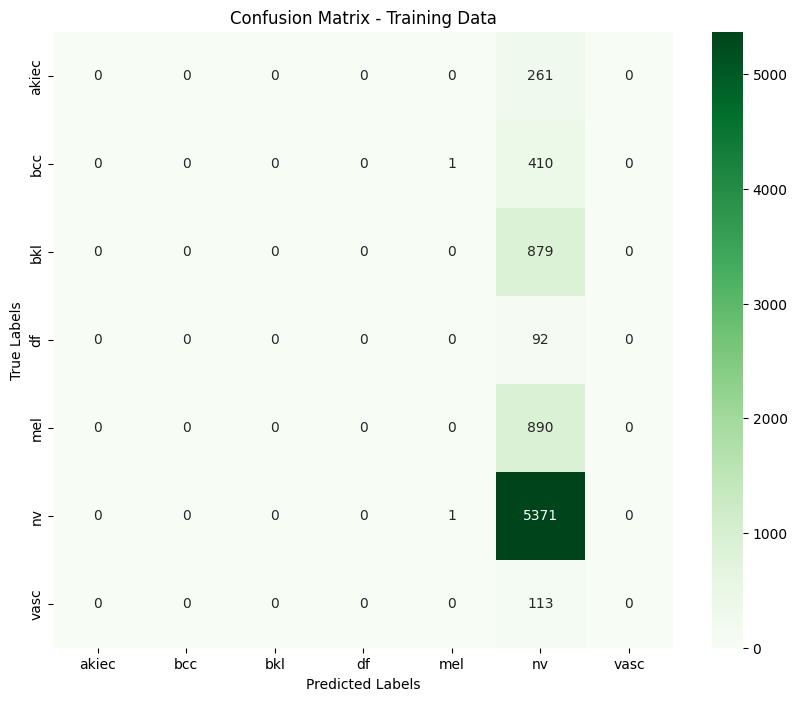

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.00      0.00      0.00       890
          nv       0.67      1.00      0.80      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.67      8018
   macro avg       0.10      0.14      0.11      8018
weighted avg       0.45      0.67      0.54      8018

126/126 [==============================] - 33s 261ms/step


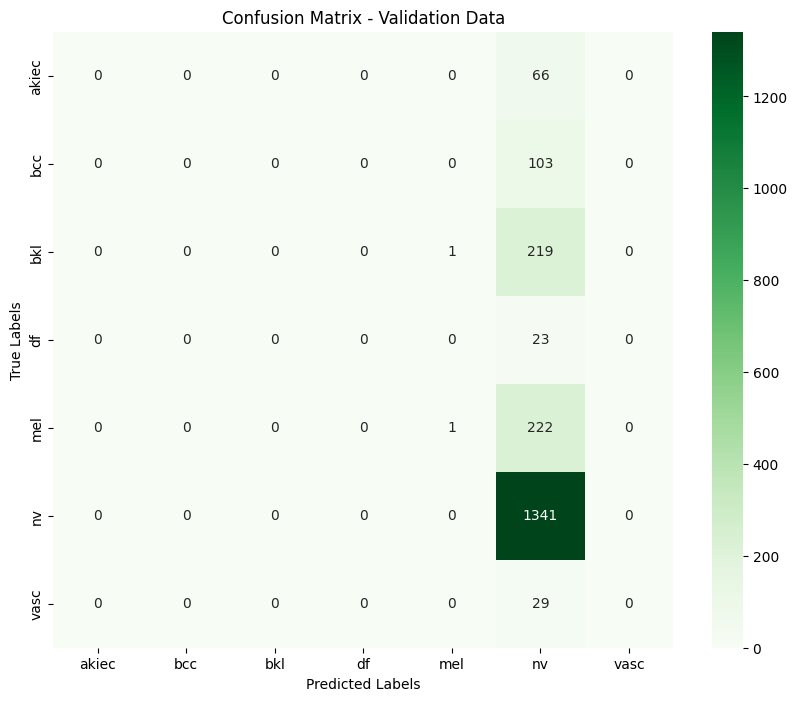

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.50      0.00      0.01       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.17      0.14      0.12      2005
weighted avg       0.50      0.67      0.54      2005

95/95 [==============================] - 25s 261ms/step


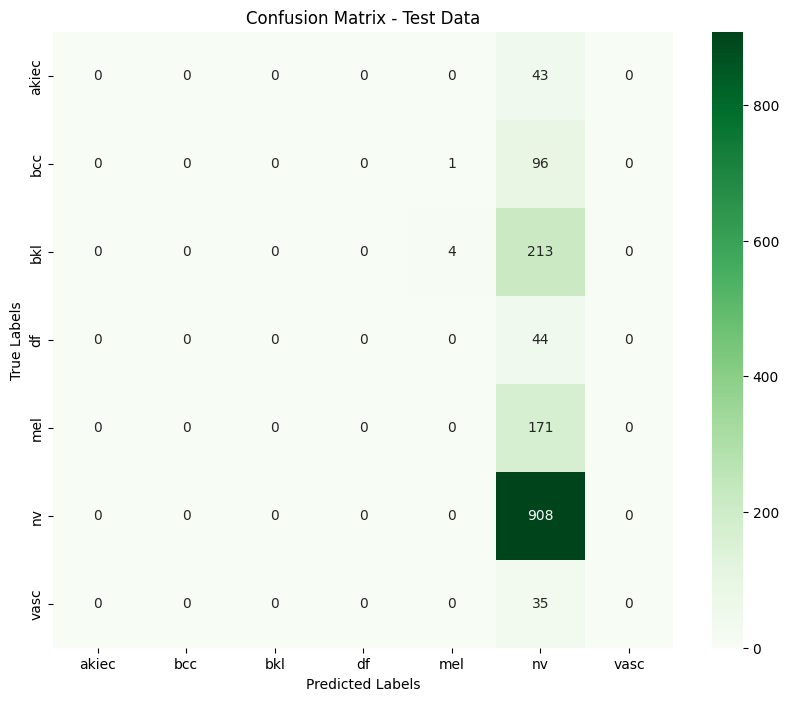

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.00      0.00      0.00       171
          nv       0.60      1.00      0.75       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.60      1515
   macro avg       0.09      0.14      0.11      1515
weighted avg       0.36      0.60      0.45      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldVGG19.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')

Xception

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load filenames and labels
train_data = glob(os.path.join(train_dir, '*', '*.jpg'))  # List of image file paths
train_labels = [path.split('\\')[-2] for path in train_data]  # Extract the class names from directory structure

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Set up 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Train on each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f'Fold {fold + 1}')
    
    # Split the data
    train_data_fold = np.array(train_data)[train_idx]
    val_data_fold = np.array(train_data)[val_idx]
    train_labels_fold = train_labels_encoded[train_idx]
    val_labels_fold = train_labels_encoded[val_idx]
    
    # Convert integer-encoded labels back to string labels
    train_labels_fold_str = label_encoder.inverse_transform(train_labels_fold)
    val_labels_fold_str = label_encoder.inverse_transform(val_labels_fold)
    
    # Set up ImageDataGenerator for this fold using string labels
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_data_fold, 'class': train_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_data_fold, 'class': val_labels_fold_str}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

    # Freeze the base_model layers to prevent them from being trained
    for layer in base_model.layers[-30:]:
        layer.trainable = False

    # Add custom layers on top of the base model without L2 regularization
    x = base_model.output
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)

    # Add Dense layers without L2 regularization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)

    # Final output layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

    # Metrics callback for precision
    class MetricsCallback(Callback):
        def __init__(self, val_generator):
            super(MetricsCallback, self).__init__()
            self.val_generator = val_generator

        def on_epoch_end(self, epoch, logs=None):
            y_true = self.val_generator.classes
            y_pred = self.model.predict(self.val_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)

            # Calculate precision only
            precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

            val_loss = logs['val_loss']
            val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

            print(f'Epoch {epoch + 1} - '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}, '
                  f'Validation Precision: {precision:.4f}')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Model checkpoint
    checkpoint = ModelCheckpoint(
        f'5foldXception.h5',  # Save model for each fold
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Train the model for this fold
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, MetricsCallback(val_generator), checkpoint, reduce_lr],
        verbose=2
    )


Fold 1
Found 6414 validated image filenames belonging to 7 classes.
Found 1604 validated image filenames belonging to 7 classes.
Epoch 1/1000
101/101 [==============================] - 16s 152ms/step
Epoch 1 - Validation Loss: 0.7900, Validation Accuracy: 0.6951, Validation Precision: 0.5511

Epoch 1: val_loss improved from inf to 0.79004, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 328s - loss: 1.0172 - acc: 0.6476 - val_loss: 0.7900 - val_acc: 0.6951 - lr: 1.0000e-04 - 328s/epoch - 817ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 0.7090, Validation Accuracy: 0.7332, Validation Precision: 0.6653

Epoch 2: val_loss improved from 0.79004 to 0.70904, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 321s - loss: 0.7863 - acc: 0.7007 - val_loss: 0.7090 - val_acc: 0.7332 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 3/1000
101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 0.6219, Validation Accuracy: 0.7631, Validation Precision: 0.7695

Epoch 3: val_loss improved from 0.70904 to 0.62189, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 321s - loss: 0.6715 - acc: 0.7543 - val_loss: 0.6219 - val_acc: 0.7631 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 4/1000
101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 0.6037, Validation Accuracy: 0.8017, Validation Precision: 0.7671

Epoch 4: val_loss improved from 0.62189 to 0.60366, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 321s - loss: 0.5659 - acc: 0.8028 - val_loss: 0.6037 - val_acc: 0.8017 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 5/1000
101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 0.4593, Validation Accuracy: 0.8498, Validation Precision: 0.8459

Epoch 5: val_loss improved from 0.60366 to 0.45935, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 321s - loss: 0.4873 - acc: 0.8310 - val_loss: 0.4593 - val_acc: 0.8498 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 6/1000
101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 0.5939, Validation Accuracy: 0.8279, Validation Precision: 0.8214

Epoch 6: val_loss did not improve from 0.45935
401/401 - 321s - loss: 0.4028 - acc: 0.8655 - val_loss: 0.5939 - val_acc: 0.8279 - lr: 1.0000e-04 - 321s/epoch - 800ms/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 7 - Validation Loss: 0.7192, Validation Accuracy: 0.8061, Validation Precision: 0.8372

Epoch 7: val_loss did not improve from 0.45935
401/401 - 321s - loss: 0.3409 - acc: 0.8870 - val_loss: 0.7192 - val_acc: 0.8061 - lr: 1.0000e-04 - 321s/epoch - 800ms/step
Epoch 8/1000
101/101 [==============================] - 15s 152ms/step
Epoch 8 - Validation Loss: 0.5981, Validation Accuracy: 0.8323, Validation Precision: 0.8571

Epoch 8: val_loss did not improve from 0.45935
401/401 - 321s - loss: 0.2981 - acc: 0.9038 - val_loss: 0.5981 - val_acc: 0.8323 - lr: 1.0000e-04 - 321s/epoch - 799ms/step
Epoch 9/1000
101/101 [==============================] - 15s 152ms/step
Epoch 9 - Validation Loss: 0.7922, Validation Accuracy: 0.7830, Validation Precision: 0.8629

Epoch 9: val_loss did not improve from 0.45935
401/401 - 320s - loss: 0.2548 - acc: 0.9186 - val_loss: 0.7922 - val_acc: 0.7830 - lr: 1.0000e-04 - 320s/epoch - 799ms/step
Epoch

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 16s 152ms/step
Epoch 1 - Validation Loss: 0.8542, Validation Accuracy: 0.7126, Validation Precision: 0.6735

Epoch 1: val_loss improved from inf to 0.85425, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 323s - loss: 0.9373 - acc: 0.6738 - val_loss: 0.8542 - val_acc: 0.7126 - lr: 1.0000e-04 - 323s/epoch - 806ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 0.6202, Validation Accuracy: 0.7681, Validation Precision: 0.7715

Epoch 2: val_loss improved from 0.85425 to 0.62021, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 320s - loss: 0.7380 - acc: 0.7234 - val_loss: 0.6202 - val_acc: 0.7681 - lr: 1.0000e-04 - 320s/epoch - 799ms/step
Epoch 3/1000
101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 0.6064, Validation Accuracy: 0.7874, Validation Precision: 0.8193

Epoch 3: val_loss improved from 0.62021 to 0.60643, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 320s - loss: 0.6373 - acc: 0.7636 - val_loss: 0.6064 - val_acc: 0.7874 - lr: 1.0000e-04 - 320s/epoch - 799ms/step
Epoch 4/1000
101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 0.7742, Validation Accuracy: 0.7656, Validation Precision: 0.8374

Epoch 4: val_loss did not improve from 0.60643
401/401 - 320s - loss: 0.5292 - acc: 0.8148 - val_loss: 0.7742 - val_acc: 0.7656 - lr: 1.0000e-04 - 320s/epoch - 797ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 0.6947, Validation Accuracy: 0.7637, Validation Precision: 0.8296

Epoch 5: val_loss did not improve from 0.60643
401/401 - 319s - loss: 0.4565 - acc: 0.8446 - val_loss: 0.6947 - val_acc: 0.7637 - lr: 1.0000e-04 - 319s/epoch - 796ms/step
Epoch 6/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 0.5445, Validation Accuracy: 0.8342, Validation Precision: 0.8531

Epoch 6: val_loss improved from 0.60643 to 0.54447, saving model to 5foldXception.h5
401/401 - 320s - loss: 0.3829 - acc: 0.8681 - val_loss: 0.5445 - val_acc: 0.8342 - lr: 1.0000e-04 - 320s/epoch - 799ms/step
Epoch 7/1000
101/101 [==============================] - 15s 152ms/step
Epoch 7 - Validation Loss: 0.7144, Validation Accuracy: 0.8030, Validation Precision: 0.8432

Epoch 7: val_loss did not improve from 0.54447
401/401 - 320s - loss: 0.3302 - acc: 0.8870 - val_loss: 0.7144 - val_acc: 0.8030 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 8/1000
101/101 [==============================] - 15s 152ms/step
Epoch 8 - Validation Loss: 0.4668, Validation Accuracy: 0.8491, Validation Precision: 0.8573

Epoch 8: val_loss improved from 0.54447 to 0.46677, saving model to 5foldXception.h5
401/401 - 320s - loss: 0.2934 - acc: 0.9016 - val_los

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 325s - loss: 1.1787 - acc: 0.5474 - val_loss: 0.7837 - val_acc: 0.7045 - lr: 1.0000e-04 - 325s/epoch - 810ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 0.6865, Validation Accuracy: 0.7232, Validation Precision: 0.7700

Epoch 2: val_loss improved from 0.78369 to 0.68652, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 322s - loss: 0.7813 - acc: 0.7169 - val_loss: 0.6865 - val_acc: 0.7232 - lr: 1.0000e-04 - 322s/epoch - 802ms/step
Epoch 3/1000
101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 0.5898, Validation Accuracy: 0.7712, Validation Precision: 0.8016

Epoch 3: val_loss improved from 0.68652 to 0.58981, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 321s - loss: 0.6728 - acc: 0.7572 - val_loss: 0.5898 - val_acc: 0.7712 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 4/1000
101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 0.5991, Validation Accuracy: 0.7718, Validation Precision: 0.8090

Epoch 4: val_loss did not improve from 0.58981
401/401 - 321s - loss: 0.5706 - acc: 0.7953 - val_loss: 0.5991 - val_acc: 0.7718 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 0.4638, Validation Accuracy: 0.8367, Validation Precision: 0.8462

Epoch 5: val_loss improved from 0.58981 to 0.46379, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 322s - loss: 0.4892 - acc: 0.8315 - val_loss: 0.4638 - val_acc: 0.8367 - lr: 1.0000e-04 - 322s/epoch - 802ms/step
Epoch 6/1000
101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 0.4226, Validation Accuracy: 0.8566, Validation Precision: 0.8598

Epoch 6: val_loss improved from 0.46379 to 0.42262, saving model to 5foldXception.h5
401/401 - 321s - loss: 0.4175 - acc: 0.8553 - val_loss: 0.4226 - val_acc: 0.8566 - lr: 1.0000e-04 - 321s/epoch - 801ms/step
Epoch 7/1000
101/101 [==============================] - 15s 152ms/step
Epoch 7 - Validation Loss: 0.6427, Validation Accuracy: 0.7899, Validation Precision: 0.8583

Epoch 7: val_loss did not improve from 0.42262
401/401 - 321s - loss: 0.3660 - acc: 0.8689 - val_loss: 0.6427 - val_acc: 0.7899 - lr: 1.0000e-04 - 321s/epoch - 800ms/step
Epoch 8/1000
101/101 [==============================] - 15s 152ms/step
Epoch 8 - Validation Loss: 0.8227, Validation Accuracy: 0.7550, Validation Precision: 0.8260

E

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 325s - loss: 0.9606 - acc: 0.6695 - val_loss: 0.7531 - val_acc: 0.7211 - lr: 1.0000e-04 - 325s/epoch - 810ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 0.7715, Validation Accuracy: 0.7012, Validation Precision: 0.7364

Epoch 2: val_loss did not improve from 0.75314
401/401 - 319s - loss: 0.7585 - acc: 0.7160 - val_loss: 0.7715 - val_acc: 0.7012 - lr: 1.0000e-04 - 319s/epoch - 796ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 0.7969, Validation Accuracy: 0.7068, Validation Precision: 0.7982

Epoch 3: val_loss did not improve from 0.75314
401/401 - 319s - loss: 0.6477 - acc: 0.7596 - val_loss: 0.7969 - val_acc: 0.7068 - lr: 1.0000e-04 - 319s/epoch - 796ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 0.6986, Validation Accuracy: 0.7536, Validation Precision: 0.8210

Epoch 4: val_loss improved from 0.75314 to 0.69865, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 320s - loss: 0.5281 - acc: 0.8100 - val_loss: 0.6986 - val_acc: 0.7536 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 5/1000
101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 0.6690, Validation Accuracy: 0.7686, Validation Precision: 0.8314

Epoch 5: val_loss improved from 0.69865 to 0.66901, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 320s - loss: 0.4480 - acc: 0.8426 - val_loss: 0.6690 - val_acc: 0.7686 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 6/1000
101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 0.5099, Validation Accuracy: 0.8247, Validation Precision: 0.8477

Epoch 6: val_loss improved from 0.66901 to 0.50986, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 320s - loss: 0.3858 - acc: 0.8683 - val_loss: 0.5099 - val_acc: 0.8247 - lr: 1.0000e-04 - 320s/epoch - 797ms/step
Epoch 7/1000
101/101 [==============================] - 15s 152ms/step
Epoch 7 - Validation Loss: 0.5786, Validation Accuracy: 0.8110, Validation Precision: 0.8371

Epoch 7: val_loss did not improve from 0.50986
401/401 - 319s - loss: 0.3381 - acc: 0.8843 - val_loss: 0.5786 - val_acc: 0.8110 - lr: 1.0000e-04 - 319s/epoch - 796ms/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 8 - Validation Loss: 0.5475, Validation Accuracy: 0.8272, Validation Precision: 0.8555

Epoch 8: val_loss did not improve from 0.50986
401/401 - 320s - loss: 0.2782 - acc: 0.9054 - val_loss: 0.5475 - val_acc: 0.8272 - lr: 1.0000e-04 - 320s/epoch - 797ms/step
Epoch 9/1000
101/101 [==============================] - 15s 152ms/step
Epoch 9 - Validation Loss: 0.8128, Validation Accuracy: 0.7804, Validation Precision: 0.8562

Epoch 9: val_loss did not improve from 0.50986
401/401 - 320s - loss: 0.2508 - acc: 0.9147 - val_loss: 0.8128 - val_acc: 0.7804 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 10/1000
101/101 [==============================] - 15s 152ms/step
Epoch 10 - Validation Loss: 0.5816, Validation Accuracy: 0.8384, Validation Precision: 0.8693

Epoch 10: val_loss did not improve from 0.50986
401/401 - 319s - loss: 0.2098 - acc: 0.9320 - val_loss: 0.5816 - val_acc: 0.8384 - lr: 1.0000e-04 - 319s/epoch - 796ms/step
Ep

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/1000
101/101 [==============================] - 16s 152ms/step
Epoch 1 - Validation Loss: 0.8739, Validation Accuracy: 0.6949, Validation Precision: 0.5373

Epoch 1: val_loss improved from inf to 0.87393, saving model to 5foldXception.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


401/401 - 324s - loss: 0.9291 - acc: 0.6720 - val_loss: 0.8739 - val_acc: 0.6949 - lr: 1.0000e-04 - 324s/epoch - 809ms/step
Epoch 2/1000
101/101 [==============================] - 15s 152ms/step
Epoch 2 - Validation Loss: 1.0901, Validation Accuracy: 0.5365, Validation Precision: 0.6911

Epoch 2: val_loss did not improve from 0.87393
401/401 - 320s - loss: 0.7518 - acc: 0.7057 - val_loss: 1.0901 - val_acc: 0.5365 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 3/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 3 - Validation Loss: 1.2056, Validation Accuracy: 0.5284, Validation Precision: 0.7628

Epoch 3: val_loss did not improve from 0.87393
401/401 - 320s - loss: 0.6455 - acc: 0.7454 - val_loss: 1.2056 - val_acc: 0.5284 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


101/101 [==============================] - 15s 152ms/step
Epoch 4 - Validation Loss: 1.4834, Validation Accuracy: 0.4255, Validation Precision: 0.7862

Epoch 4: val_loss did not improve from 0.87393
401/401 - 320s - loss: 0.5572 - acc: 0.8059 - val_loss: 1.4834 - val_acc: 0.4255 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 5/1000
101/101 [==============================] - 15s 152ms/step
Epoch 5 - Validation Loss: 1.1047, Validation Accuracy: 0.6176, Validation Precision: 0.7759

Epoch 5: val_loss did not improve from 0.87393
401/401 - 320s - loss: 0.4645 - acc: 0.8369 - val_loss: 1.1047 - val_acc: 0.6176 - lr: 1.0000e-04 - 320s/epoch - 798ms/step
Epoch 6/1000
101/101 [==============================] - 15s 152ms/step
Epoch 6 - Validation Loss: 1.5862, Validation Accuracy: 0.4704, Validation Precision: 0.5373

Epoch 6: val_loss did not improve from 0.87393
401/401 - 320s - loss: 0.3996 - acc: 0.8605 - val_loss: 1.5862 - val_acc: 0.4704 - lr: 1.0000e-04 - 320s/epoch - 798ms/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 299, 224, 32  864         ['input_47[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 299, 224, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 19s 154ms/step - loss: 0.7660 - acc: 0.6943
Validation accuracy: 0.6942643523216248
126/126 [==============================] - 19s 152ms/step
Validation Precision: 0.5299
Validation Recall: 0.6943
Validation F1-Score: 0.6006



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 15s 155ms/step - loss: 0.9342 - acc: 0.6238
Test accuracy: 0.6237623691558838
95/95 [==============================] - 14s 152ms/step
Test Precision: 0.4374
Test Recall: 0.6238
Test F1-Score: 0.5141



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 226s 450ms/step


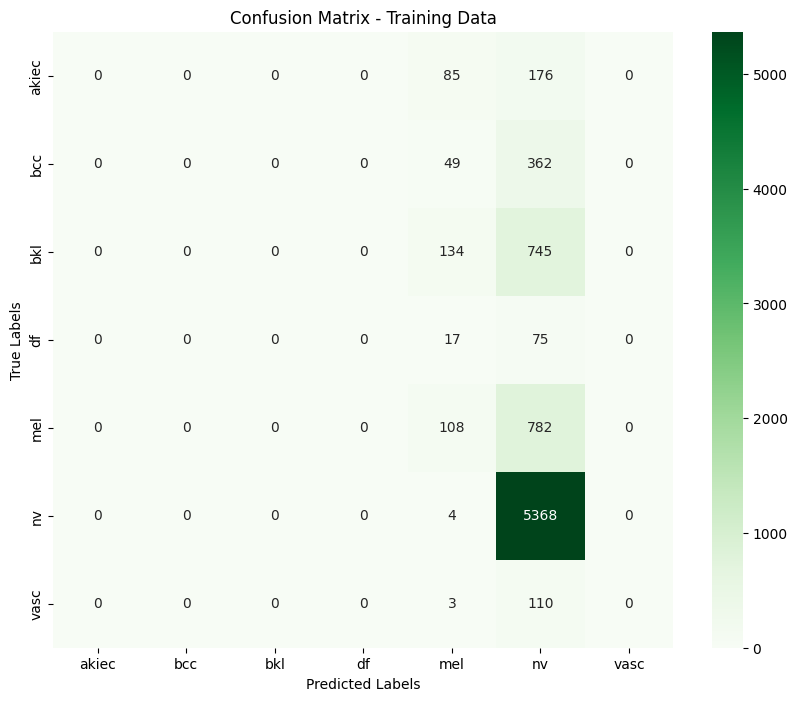

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       261
         bcc       0.00      0.00      0.00       411
         bkl       0.00      0.00      0.00       879
          df       0.00      0.00      0.00        92
         mel       0.27      0.12      0.17       890
          nv       0.70      1.00      0.83      5372
        vasc       0.00      0.00      0.00       113

    accuracy                           0.68      8018
   macro avg       0.14      0.16      0.14      8018
weighted avg       0.50      0.68      0.57      8018

126/126 [==============================] - 19s 152ms/step


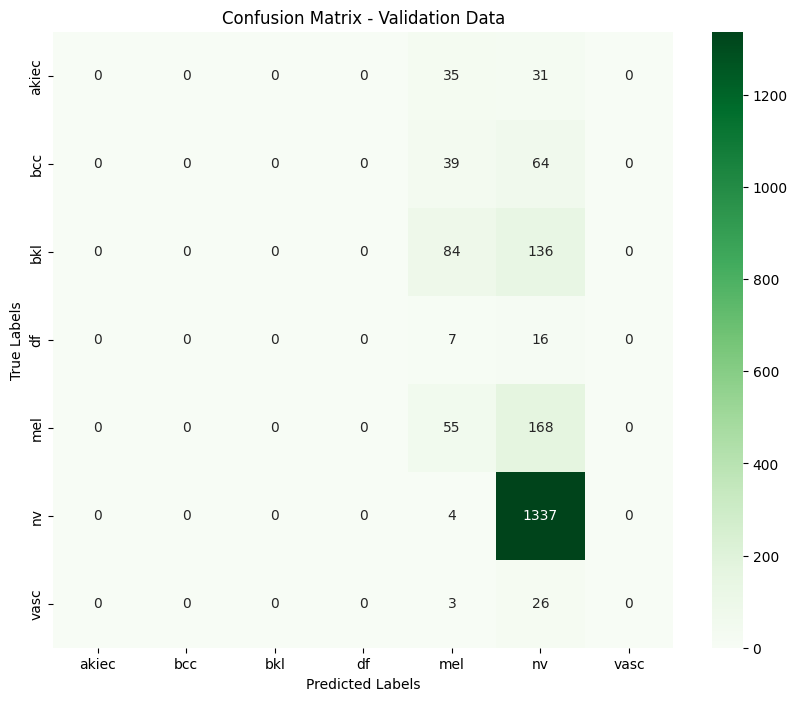

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        66
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.24      0.25      0.24       223
          nv       0.75      1.00      0.86      1341
        vasc       0.00      0.00      0.00        29

    accuracy                           0.69      2005
   macro avg       0.14      0.18      0.16      2005
weighted avg       0.53      0.69      0.60      2005



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

95/95 [==============================] - 14s 152ms/step


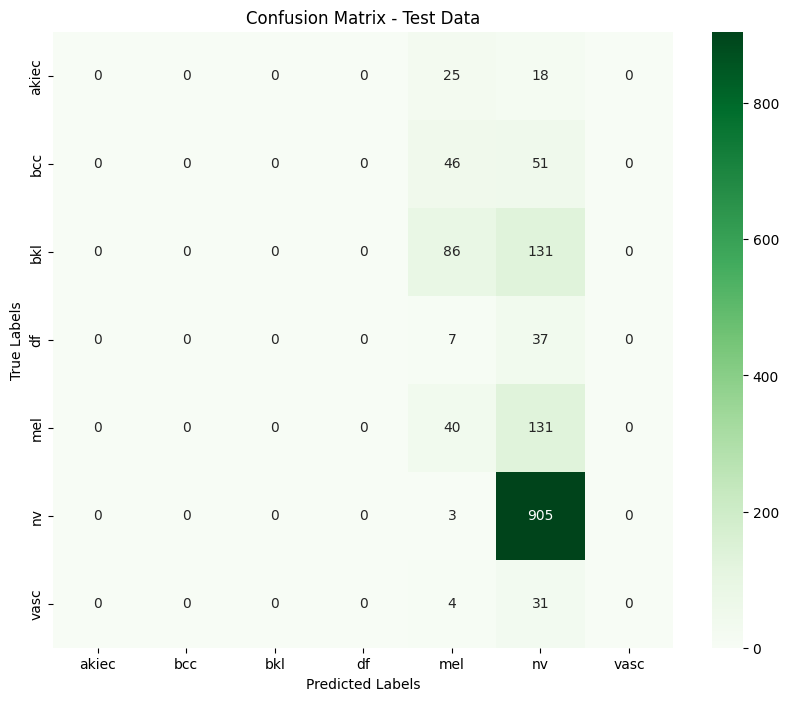

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        43
         bcc       0.00      0.00      0.00        97
         bkl       0.00      0.00      0.00       217
          df       0.00      0.00      0.00        44
         mel       0.19      0.23      0.21       171
          nv       0.69      1.00      0.82       908
        vasc       0.00      0.00      0.00        35

    accuracy                           0.62      1515
   macro avg       0.13      0.18      0.15      1515
weighted avg       0.44      0.62      0.51      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
from collections import Counter
import shutil
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('5foldXception.h5')

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Function to compute and print precision, recall, and F1-score for a dataset
def compute_metrics(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    # Print results
    print(f'{generator_name} Precision: {precision:.4f}')
    print(f'{generator_name} Recall: {recall:.4f}')
    print(f'{generator_name} F1-Score: {f1:.4f}')
    print()

# Evaluate accuracy and compute precision, recall, F1 for train, val, and test data
train_score = model.evaluate(train_generator)
print('Train accuracy:', train_score[1])
compute_metrics(train_generator, 'Training')

val_score = model.evaluate(val_generator)
print('Validation accuracy:', val_score[1])
compute_metrics(val_generator, 'Validation')

test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])
compute_metrics(test_generator, 'Test')

# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')